In [4]:
import cv2
import mediapipe as mp
import numpy as np
from numpy import asarray
from numpy import save

In [5]:
# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence = 0.5)

In [6]:
# Getting the input video for pose estimation

cap = cv2.VideoCapture('1_5-1.mp4')
#cap = cv2.VideoCapture('v1_5-1.mp4')
#cap = cv2.VideoCapture('2v_5-1.mp4')
#cap = cv2.VideoCapture('2_5-3.mp4')

# Number to convert the real world coordinate from meters to milimeters
num = 1000

In [7]:
# Landmarks dictionary to define body segments landmarks according to BlazePose Topology

landmarks_coordinates = {}

thigh_segments = {"Left Thigh": [23, 25], "Right Thigh": [24, 26]}

upperarm_segments = {"Left Upper Arm": [11, 13], "Right Upper Arm": [12, 14]}

forearm_segments = {"Left Fore Arm": [13, 15], "Right Fore Arm": [14, 16]}

leg_segments = {"Left Leg": [25, 27], "Right Leg": [26, 28]}

foot_segments = {"Left foot": [27, 31], "Right foot": [28, 32]}

hands_segments = {"Left hand": [15, 19], "Right hand": [16, 20]}

shoulder_segment = {"Shoulder": [12, 11]}

hips_segment = {"Hips": [24, 23]}

trunk_segment = {"trunk": [34, 33]}

In [8]:
# Function to calculate CoM coordinates for segments defined in the dictionary

def calculate_foot_CoM(x_i, x_j, y_i, y_j, z_i, z_j):
    x1 = (x_i + x_j) * 0.5
    y1 = (y_i + y_j) * 0.5
    z1 = (z_i + z_j) * 0.5

    return x1, y1, z1

def calculate_Leg_CoM(x_g, x_h, y_g, y_h, z_g, z_h):
    x2 = x_g + 0.433 * (x_h - x_g)
    y2 = y_g - 0.433 * (y_g - y_h)
    z2 = z_g - 0.433 * (z_g - z_h)

    return x2, y2, z2


def calculate_thigh_CoM(x_a, x_b, y_a, y_b, z_a, z_b):
    x3 = x_a + 0.433 * (x_b - x_a)
    y3 = y_a - 0.433 * (y_a - y_b)
    z3 = z_a - 0.433 * (z_a - z_b)

    return x3, y3, z3


def calculate_UpperArm_CoM(x_c, x_d, y_c, y_d, z_c, z_d):
    x4 = x_c + 0.436 * (x_d - x_c)
    y4 = y_c - 0.436 * (y_c - y_d)
    z4 = z_c - 0.436 * (z_c - z_d)

    return x4, y4, z4


def calculate_ForeArm_CoM(x_e, x_f, y_e, y_f, z_e, z_f):
    x5 = x_e + 0.430 * (x_f - x_e)
    y5 = y_e - 0.430 * (y_e - y_f)
    z5 = z_e - 0.430 * (z_e - z_f)

    return x5, y5, z5


def calculate_hands_CoM(x_o, x_p, y_o, y_p, z_o, z_p):
    x6 = x_o + 0.506 * (x_p - x_o)
    y6 = y_o - 0.506 * (y_o - y_p)
    z6 = z_o - 0.506 * (z_o - z_p)

    return x6, y6, z6


def calculate_trunk_CoM(x_q, x_r, y_q, y_r, z_q, z_r):
    x7 = x_q - 0.66 * (x_q - x_r)
    y7 = y_q - 0.66 * (y_q - y_r)
    z7 = z_q - 0.66 * (z_q - z_r)    

    return x7, y7, z7


def calculate_average(x_l, x_r, y_l, y_r, z_l, z_r):
    x = (x_l + x_r) * 0.5
    y = (y_l + y_r) * 0.5
    z = (z_l + z_r) * 0.5
    
    return x, y, z

In [6]:
### Pose estimation for one individual in a video

# While the video is running, perform pose detection 
while True:
    success, image = cap.read()
    results = pose.process(image)
    
    # Defining a variable to calculate the whole body CoM in the end, by getting
    # all the segment´s CoM coordinates values
    com_body = 0
    
    # Check if any landmarks are found.
    if results.pose_world_landmarks:
        # draw the connections between joint landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 ) 
        # Enumerate each landmark according to BlazePose Topology 
        for idx, lm in enumerate(results.pose_landmarks.landmark):
            h, w, c = image.shape
            cx, cy = int(lm.x * w), int(lm.y * h)
            #cv2.circle(image, (cx, cy), 2, (0, 0, 255), cv2.FILLED)
            if idx == 29:
                #print(idx, lm.x, lm.y, lm.z)
                print("[%s, %s, %s],\n" % (str(lm.x), str(lm.y), str(lm.z)))
            landmarks_coordinates[idx] = {"x": lm.x, "y": lm.y, "z": lm.z}

       # Calculating trunk CoM coordinates by defining the average point in the shoulder and
        # hips segment
        x_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["x"]
        y_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["y"]
        z_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["z"]
        x_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["x"]
        y_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["y"]
        z_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["z"]
        x_average_shoulder, y_average_shoulder, z_average_shoulder = calculate_average(
            x_left_shoulder, x_right_shoulder, y_left_shoulder, y_right_shoulder, z_left_shoulder, z_right_shoulder
        )

        landmarks_coordinates[33] = {"x": x_average_shoulder, "y": y_average_shoulder, "z": z_average_shoulder}

        x_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["x"]
        y_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["y"]
        z_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["z"]
        x_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["x"]
        y_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["y"]
        z_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["y"]
        x_average_hips, y_average_hips, z_average_hips = calculate_average(
            x_left_hips, x_right_hips, y_left_hips, y_right_hips, z_left_hips, z_right_hips
        )

        landmarks_coordinates[34] = {"x": x_average_hips, "y": y_average_hips, "z": z_average_hips}

    # Calculate Body segments CoM

    foot_com_x = 0
    foot_com_y = 0
    foot_com_z = 0
    for segment in foot_segments:
        # print("%s COM:" % segment)
        x_i = landmarks_coordinates[foot_segments[segment][0]]["x"]
        x_j = landmarks_coordinates[foot_segments[segment][1]]["x"]
        y_i = landmarks_coordinates[foot_segments[segment][0]]["y"]
        y_j = landmarks_coordinates[foot_segments[segment][1]]["y"]
        z_i = landmarks_coordinates[foot_segments[segment][0]]["z"]
        z_j = landmarks_coordinates[foot_segments[segment][1]]["z"]
        
        x1, y1, z1 = calculate_foot_CoM(x_i, x_j, y_i, y_j, z_i, z_j)
        #print("x: %s, y: %s\n" % (str(x1), str(y1)))
        #print("[%s, %s],\n" % (str(x1), str(y1)))
        #print("[%s, %s],\n" % (str(y_i), str(y_j)))

        #h, w, c = image.shape
        cx, cy = int(x1*w), int(y1*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        foot_com_x += x1
        foot_com_y += y1
        foot_com_z += z1

    leg_com_x = 0
    leg_com_y = 0
    leg_com_z = 0
    for segment in leg_segments:
        # print("%s COM:" % segment)
        x_g = landmarks_coordinates[leg_segments[segment][0]]["x"]
        x_h = landmarks_coordinates[leg_segments[segment][1]]["x"]
        y_g = landmarks_coordinates[leg_segments[segment][0]]["y"]
        y_h = landmarks_coordinates[leg_segments[segment][1]]["y"]
        z_g = landmarks_coordinates[leg_segments[segment][0]]["z"]
        z_h = landmarks_coordinates[leg_segments[segment][1]]["z"]
        
        x2, y2, z2 = calculate_Leg_CoM(x_g, x_h, y_g, y_h, z_g, z_h)
        # print("x: %s, y: %s\n" % (str(x2), str(y2)))

        #h, w, c = image.shape
        cx, cy = int(x2*w), int(y2*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        leg_com_x += x2
        leg_com_y += y2
        leg_com_z += z2
        
    thigh_com_x = 0
    thigh_com_y = 0
    thigh_com_z = 0
    for segment in thigh_segments:
        # print("%s COM:" % segment)
        x_a = landmarks_coordinates[thigh_segments[segment][0]]["x"]
        x_b = landmarks_coordinates[thigh_segments[segment][1]]["x"]
        y_a = landmarks_coordinates[thigh_segments[segment][0]]["y"]
        y_b = landmarks_coordinates[thigh_segments[segment][1]]["y"]
        z_a = landmarks_coordinates[thigh_segments[segment][0]]["z"]
        z_b = landmarks_coordinates[thigh_segments[segment][1]]["z"]
        
        x3, y3, z3 = calculate_thigh_CoM(x_a, x_b, y_a, y_b, z_a, z_b)
        #print("x: %s, y: %s\n" % (str(x3), str(y3)))

        #h, w, c = image.shape
        cx, cy = int(x3*w), int(y3*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        thigh_com_x += x3
        thigh_com_y += y3
        thigh_com_z += z3

    upperarm_com_x = 0
    upperarm_com_y = 0
    upperarm_com_z = 0
    for segment in upperarm_segments:
        # print("%s COM:" % segment)
        x_c = landmarks_coordinates[upperarm_segments[segment][0]]["x"]
        x_d = landmarks_coordinates[upperarm_segments[segment][1]]["x"]
        y_c = landmarks_coordinates[upperarm_segments[segment][0]]["y"]
        y_d = landmarks_coordinates[upperarm_segments[segment][1]]["y"]
        z_c = landmarks_coordinates[upperarm_segments[segment][0]]["z"]
        z_d = landmarks_coordinates[upperarm_segments[segment][1]]["z"]
        
        x4, y4, z4 = calculate_UpperArm_CoM(x_c, x_d, y_c, y_d, z_c, z_d)
        # print("x: %s, y: %s\n" % (str(x4), str(y4)))

        #h, w, c = image.shape
        cx, cy = int(x4*w), int(y4*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        upperarm_com_x += x4
        upperarm_com_y += y4
        upperarm_com_z += z4

    forearm_com_x = 0
    forearm_com_y = 0
    forearm_com_z = 0
    for segment in forearm_segments:
        # print("%s COM:" % segment)
        x_e = landmarks_coordinates[forearm_segments[segment][0]]["x"]
        x_f = landmarks_coordinates[forearm_segments[segment][1]]["x"]
        y_e = landmarks_coordinates[forearm_segments[segment][0]]["y"]
        y_f = landmarks_coordinates[forearm_segments[segment][1]]["y"]
        z_e = landmarks_coordinates[forearm_segments[segment][0]]["z"]
        z_f = landmarks_coordinates[forearm_segments[segment][1]]["z"]
        
        x5, y5, z5 = calculate_ForeArm_CoM(x_e, x_f, y_e, y_f, z_e, z_f)
        # print("x: %s, y: %s\n" % (str(x5), str(y5)))

        #h, w, c = image.shape
        cx, cy = int(x5*w), int(y5*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        forearm_com_x += x5
        forearm_com_y += y5
        forearm_com_z += z5

    hands_com_x = 0
    hands_com_y = 0
    hands_com_z = 0
    for segment in hands_segments:
        # print("%s COM:" % segment)
        x_o = landmarks_coordinates[hands_segments[segment][0]]["x"]
        x_p = landmarks_coordinates[hands_segments[segment][1]]["x"]
        y_o = landmarks_coordinates[hands_segments[segment][0]]["y"]
        y_p = landmarks_coordinates[hands_segments[segment][1]]["y"]
        z_o = landmarks_coordinates[hands_segments[segment][0]]["z"]
        z_p = landmarks_coordinates[hands_segments[segment][1]]["z"]
        
        x6, y6, z6 = calculate_hands_CoM(x_o, x_p, y_o, y_p, z_o, z_p)
        # print("x: %s, y: %s\n" % (str(x6), str(y6)))

        #h, w, c = image.shape
        cx, cy = int(x6*w), int(y6*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        hands_com_x += x6
        hands_com_y += y6

    trunk_com_x = 0
    trunk_com_y = 0
    trunk_com_z = 0
    for segment in trunk_segment:
        # print("%s COM:" % segment)
        x_q = landmarks_coordinates[trunk_segment[segment][0]]["x"]
        x_r = landmarks_coordinates[trunk_segment[segment][1]]["x"]
        y_q = landmarks_coordinates[trunk_segment[segment][0]]["y"]
        y_r = landmarks_coordinates[trunk_segment[segment][1]]["y"]
        z_q = landmarks_coordinates[trunk_segment[segment][0]]["z"]
        z_r = landmarks_coordinates[trunk_segment[segment][1]]["z"]
        
        x7, y7, z7 = calculate_trunk_CoM(x_q, x_r, y_q, y_r, z_q, z_r)
        #print("x: %s, y: %s\n" % (str(x7), str(y7)))

        #h, w, c = image.shape
        cx, cy = int(x7*w), int(y7*h)
        #  cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        trunk_com_x += x7
        trunk_com_y += y7
        trunk_com_z += z7

    # Calculate the whole body CoM
    body_com_x = (0.0145 * foot_com_x + 0.0465 * leg_com_x + 0.1 * thigh_com_x + 0.578 * trunk_com_x + 0.006 * hands_com_x + 0.028 * upperarm_com_x + 0.016 * forearm_com_x)
    body_com_y = (0.0145 * foot_com_y + 0.0465 * leg_com_y + 0.1 * thigh_com_y + 0.578 * trunk_com_y + 0.006 * hands_com_y + 0.028 * upperarm_com_y + 0.016 * forearm_com_y)
    body_com_z = (0.0145 * foot_com_z + 0.0465 * leg_com_z + 0.1 * thigh_com_z + 0.578 * trunk_com_z + 0.006 * hands_com_z + 0.028 * upperarm_com_z + 0.016 * forearm_com_z)
    
    cx, cy = int(body_com_x * w), int(body_com_y * h)
    cv2.circle(image, (cx, cy), 5, (0, 255, 255), cv2.FILLED)
    #print("[ %s,  %s, %s],\n" % (str(body_com_x), str(body_com_y), str(body_com_z)))
    
    # Show the output image with the pose estimation and the CoM plotted
    #cv2.imshow("Video", image)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


[0.5350512862205505, 0.4885689318180084, 0.24213014543056488],

[0.5349753499031067, 0.48762258887290955, 0.22159074246883392],

[0.5350122451782227, 0.48743799328804016, 0.21882754564285278],

[0.5351741909980774, 0.48686981201171875, 0.21828533709049225],

[0.53523850440979, 0.48680147528648376, 0.21958675980567932],

[0.5353322625160217, 0.4871673285961151, 0.22947977483272552],

[0.5355206727981567, 0.48724299669265747, 0.2346900850534439],

[0.5356046557426453, 0.48728635907173157, 0.2368236780166626],

[0.5357216596603394, 0.4876468777656555, 0.2387552559375763],

[0.5359926819801331, 0.4878808259963989, 0.2544117569923401],

[0.5366017818450928, 0.48812612891197205, 0.2622525990009308],

[0.5368891358375549, 0.4883284270763397, 0.2627275884151459],

[0.5370564460754395, 0.48904183506965637, 0.26836341619491577],

[0.5370588302612305, 0.4891762435436249, 0.27131950855255127],

[0.5370152592658997, 0.4891412556171417, 0.25616133213043213],

[0.5369289517402649, 0.4891510009765625,

[0.6411027908325195, 0.3126404583454132, 0.21866926550865173],

[0.6408946514129639, 0.31281402707099915, 0.2079288810491562],

[0.6394867897033691, 0.3128531575202942, 0.20289863646030426],

[0.6384303569793701, 0.31265929341316223, 0.19183345139026642],

[0.6384819746017456, 0.31231802701950073, 0.17989927530288696],

[0.638450026512146, 0.3124006688594818, 0.17977090179920197],

[0.6384825110435486, 0.3128429055213928, 0.1546766757965088],

[0.6385838389396667, 0.31324502825737, 0.15969966351985931],

[0.6371583938598633, 0.31284281611442566, 0.10765011608600616],

[0.6372591853141785, 0.31284430623054504, 0.08366917073726654],



AttributeError: 'NoneType' object has no attribute 'shape'

Teste 1-1

In [8]:
foot29 = np.array([[0.5350512862205505, 0.4885689318180084, 0.24213014543056488],

[0.5349753499031067, 0.48762258887290955, 0.22159074246883392],

[0.5350122451782227, 0.48743799328804016, 0.21882754564285278],

[0.5351741909980774, 0.48686981201171875, 0.21828533709049225],

[0.53523850440979, 0.48680147528648376, 0.21958675980567932],

[0.5353322625160217, 0.4871673285961151, 0.22947977483272552],

[0.5355206727981567, 0.48724299669265747, 0.2346900850534439],

[0.5356046557426453, 0.48728635907173157, 0.2368236780166626],

[0.5357216596603394, 0.4876468777656555, 0.2387552559375763],

[0.5359926819801331, 0.4878808259963989, 0.2544117569923401],

[0.5366017818450928, 0.48812612891197205, 0.2622525990009308],

[0.5368891358375549, 0.4883284270763397, 0.2627275884151459],

[0.5370564460754395, 0.48904183506965637, 0.26836341619491577],

[0.5370588302612305, 0.4891762435436249, 0.27131950855255127],

[0.5370152592658997, 0.4891412556171417, 0.25616133213043213],

[0.5369289517402649, 0.4891510009765625, 0.24393697082996368],

[0.53678959608078, 0.4892103374004364, 0.2516089379787445],

[0.5367925763130188, 0.4892129600048065, 0.25429266691207886],

[0.5365738868713379, 0.48940032720565796, 0.26299577951431274],

[0.5361343622207642, 0.48940309882164, 0.2451639473438263],

[0.5361124277114868, 0.48937466740608215, 0.2113746553659439],

[0.5361153483390808, 0.48877981305122375, 0.20057953894138336],

[0.5361148715019226, 0.4886082708835602, 0.2145811915397644],

[0.5361146926879883, 0.4874444901943207, 0.21586252748966217],

[0.5361577868461609, 0.4871077537536621, 0.21964386105537415],

[0.5360155701637268, 0.48689159750938416, 0.22972123324871063],

[0.5355318188667297, 0.48672690987586975, 0.23234696686267853],

[0.5351793766021729, 0.486276775598526, 0.23236988484859467],

[0.5346556305885315, 0.48567983508110046, 0.24620293080806732],

[0.5346626043319702, 0.48500150442123413, 0.24880868196487427],

[0.5343950390815735, 0.4849990904331207, 0.2529064416885376],

[0.5342245697975159, 0.48598426580429077, 0.25378575921058655],

[0.5351384282112122, 0.48746031522750854, 0.25199225544929504],

[0.5355895161628723, 0.4915024936199188, 0.2868482768535614],

[0.5345770120620728, 0.49339500069618225, 0.27540719509124756],

[0.5329011082649231, 0.495136559009552, 0.27014365792274475],

[0.5291549563407898, 0.49040737748146057, 0.24075014889240265],

[0.5261452794075012, 0.49795427918434143, 0.33218905329704285],

[0.5230919718742371, 0.5042207837104797, 0.4014612138271332],

[0.5200825333595276, 0.5073363780975342, 0.4581625759601593],

[0.5202535390853882, 0.5053300261497498, 0.4530300199985504],

[0.5208800435066223, 0.5038917660713196, 0.44433459639549255],

[0.5213293433189392, 0.4966071844100952, 0.42656210064888],

[0.5214862823486328, 0.482493132352829, 0.3737141489982605],

[0.5217375755310059, 0.4733000099658966, 0.2916273772716522],

[0.5203408002853394, 0.4645872414112091, 0.23221224546432495],

[0.5191635489463806, 0.4601210653781891, 0.22137458622455597],

[0.5194587111473083, 0.46123209595680237, 0.24547870457172394],

[0.519682765007019, 0.45989879965782166, 0.2119653970003128],

[0.5198355317115784, 0.45893165469169617, 0.18355172872543335],

[0.5210045576095581, 0.45503270626068115, 0.1912708580493927],

[0.5223703980445862, 0.45288166403770447, 0.1720976084470749],

[0.5223799347877502, 0.45158275961875916, 0.18545545637607574],

[0.5187736749649048, 0.4476667046546936, 0.04871739074587822],

[0.5179800987243652, 0.448781818151474, 0.07488492876291275],

[0.5157988667488098, 0.44873324036598206, 0.052497755736112595],

[0.5152234435081482, 0.44765761494636536, 0.10876093059778214],

[0.5154741406440735, 0.4491530954837799, 0.1876613199710846],

[0.5156792998313904, 0.44985026121139526, 0.2237214297056198],

[0.5174483060836792, 0.4496976137161255, 0.2033604383468628],

[0.5206998586654663, 0.44935503602027893, 0.24676507711410522],

[0.5223201513290405, 0.44540485739707947, 0.2679673135280609],

[0.5246554613113403, 0.44462233781814575, 0.2868984639644623],

[0.526921808719635, 0.4430975615978241, 0.3012527525424957],

[0.5284963846206665, 0.4422759711742401, 0.32876306772232056],

[0.5293906927108765, 0.4430798590183258, 0.40194275975227356],

[0.5298928618431091, 0.44314345717430115, 0.45823934674263],

[0.5304722785949707, 0.4436509311199188, 0.4822661876678467],

[0.5313413143157959, 0.4493407905101776, 0.5235167741775513],

[0.5311555862426758, 0.44973137974739075, 0.486421138048172],

[0.5303577184677124, 0.4513980746269226, 0.4589294195175171],

[0.5277901887893677, 0.46181759238243103, 0.5017244815826416],

[0.5266032814979553, 0.46261900663375854, 0.5141422748565674],

[0.5274227857589722, 0.4650574028491974, 0.5573071241378784],

[0.5309737920761108, 0.4646358788013458, 0.5402511954307556],

[0.5387142896652222, 0.4473603069782257, 0.4941229820251465],

[0.544454038143158, 0.4318762421607971, 0.422360897064209],

[0.5469272136688232, 0.42049840092658997, 0.33133023977279663],

[0.5524777770042419, 0.40999719500541687, 0.2570750415325165],

[0.5569713711738586, 0.4027441143989563, 0.24620118737220764],

[0.5560683012008667, 0.40168485045433044, 0.2794073522090912],

[0.5543302297592163, 0.40068259835243225, 0.27897438406944275],

[0.5537993907928467, 0.400940865278244, 0.2693069577217102],

[0.5540115833282471, 0.3956349194049835, 0.20475374162197113],

[0.5594659447669983, 0.3884766697883606, 0.21571524441242218],

[0.5605246424674988, 0.3866584002971649, 0.22289597988128662],

[0.5623329877853394, 0.3887020945549011, 0.24817398190498352],

[0.5613012313842773, 0.38806262612342834, 0.25832992792129517],

[0.5607784986495972, 0.3863427937030792, 0.29087987542152405],

[0.5606671571731567, 0.38653647899627686, 0.23973436653614044],

[0.5603490471839905, 0.3881475031375885, 0.2358921766281128],

[0.5601558685302734, 0.3894156515598297, 0.34103405475616455],

[0.5608475804328918, 0.38720470666885376, 0.4264775216579437],

[0.5613719820976257, 0.38725045323371887, 0.37463727593421936],

[0.563002347946167, 0.37745893001556396, 0.36188405752182007],

[0.5637578368186951, 0.37371304631233215, 0.34590792655944824],

[0.5636280179023743, 0.376164048910141, 0.4081384539604187],

[0.5638530254364014, 0.3779377043247223, 0.4098202586174011],

[0.5668202638626099, 0.3789786100387573, 0.44451871514320374],

[0.5686572790145874, 0.3790544867515564, 0.5532872080802917],

[0.5731295943260193, 0.3790407180786133, 0.6182786226272583],

[0.5830338597297668, 0.3695789873600006, 0.5088065266609192],

[0.5905798077583313, 0.3704938590526581, 0.41466397047042847],

[0.5897504687309265, 0.3583451807498932, 0.495231956243515],

[0.6176861524581909, 0.360540509223938, 0.6130743026733398],

[0.6633644700050354, 0.3717247247695923, 0.48602691292762756],

[0.6809009313583374, 0.37205636501312256, 0.39675477147102356],

[0.6990694403648376, 0.3680248260498047, 0.4565012753009796],

[0.7146749496459961, 0.3675631582736969, 0.4771784543991089],

[0.7191975712776184, 0.35933154821395874, 0.44784480333328247],

[0.7319281101226807, 0.3527615964412689, 0.4063347280025482],

[0.7354536652565002, 0.344612717628479, 0.31206926703453064],

[0.7221688628196716, 0.3410961329936981, 0.25762245059013367],

[0.711408793926239, 0.33343976736068726, 0.2621188163757324],

[0.7075310349464417, 0.32770735025405884, 0.2591969668865204],

[0.6915768384933472, 0.32241642475128174, 0.19496704638004303],

[0.682073175907135, 0.32105308771133423, 0.18493430316448212],

[0.6732691526412964, 0.3166988790035248, 0.14346085488796234],

[0.6623009443283081, 0.3154427707195282, 0.09843806177377701],

[0.6491729617118835, 0.31436219811439514, 0.08379366248846054],

[0.6409676671028137, 0.3152475357055664, 0.09402275830507278],

[0.6353763341903687, 0.3143109381198883, 0.03670584782958031],

[0.6369614601135254, 0.3141753375530243, 0.055379051715135574],

[0.6397621035575867, 0.3143853545188904, 0.09056414663791656],

[0.6413493156433105, 0.313761442899704, 0.10605213046073914],

[0.6416434049606323, 0.31435006856918335, 0.18617548048496246],

[0.6420083045959473, 0.3130565881729126, 0.22674469649791718],

[0.6412555575370789, 0.3132360875606537, 0.20281635224819183],

[0.6409328579902649, 0.3132552206516266, 0.1998087763786316],

[0.6410034894943237, 0.31286269426345825, 0.19252710044384003],

[0.6411027908325195, 0.3126404583454132, 0.21866926550865173],

[0.6408946514129639, 0.31281402707099915, 0.2079288810491562],

[0.6394867897033691, 0.3128531575202942, 0.20289863646030426],

[0.6384303569793701, 0.31265929341316223, 0.19183345139026642],

[0.6384819746017456, 0.31231802701950073, 0.17989927530288696],

[0.638450026512146, 0.3124006688594818, 0.17977090179920197],

[0.6384825110435486, 0.3128429055213928, 0.1546766757965088],

[0.6385838389396667, 0.31324502825737, 0.15969966351985931],

[0.6371583938598633, 0.31284281611442566, 0.10765011608600616],

[0.6372591853141785, 0.31284430623054504, 0.08366917073726654]])


foot30 = np.array([[0.5748584270477295, 0.4896586239337921, 0.33934706449508667],

[0.5747188925743103, 0.4890402555465698, 0.2818010747432709],

[0.5747913718223572, 0.4890435039997101, 0.28430917859077454],

[0.5750102996826172, 0.4884413778781891, 0.26139190793037415],

[0.5749918222427368, 0.4883599579334259, 0.2659964859485626],

[0.5749738812446594, 0.4883553683757782, 0.2686196565628052],

[0.57496178150177, 0.48823249340057373, 0.2707403004169464],

[0.5749396085739136, 0.4881899058818817, 0.2709091305732727],

[0.5749291181564331, 0.48819446563720703, 0.26727527379989624],

[0.5749117732048035, 0.48805275559425354, 0.27219295501708984],

[0.5748304724693298, 0.48799261450767517, 0.2818613350391388],

[0.5746209621429443, 0.4879932701587677, 0.28200942277908325],

[0.5742723345756531, 0.48821067810058594, 0.3048318922519684],

[0.5740084052085876, 0.4882192015647888, 0.30750933289527893],

[0.5738916397094727, 0.48787766695022583, 0.3040141463279724],

[0.5737662315368652, 0.4876345694065094, 0.2967994213104248],

[0.5731556415557861, 0.48762908577919006, 0.3007330894470215],

[0.5727957487106323, 0.48768725991249084, 0.29998481273651123],

[0.5715044140815735, 0.48795875906944275, 0.3118271827697754],

[0.5691506266593933, 0.4883873760700226, 0.3089226484298706],

[0.5686857104301453, 0.4890314042568207, 0.306768536567688],

[0.5685169100761414, 0.48892778158187866, 0.2683625817298889],

[0.5678377747535706, 0.4889479875564575, 0.2731494903564453],

[0.5672375559806824, 0.4887068569660187, 0.27267441153526306],

[0.5671868324279785, 0.48794400691986084, 0.2740224003791809],

[0.5666115283966064, 0.48648515343666077, 0.27630341053009033],

[0.565996527671814, 0.4836283028125763, 0.26720669865608215],

[0.5652672648429871, 0.482614129781723, 0.2618790864944458],

[0.5648252367973328, 0.4814769923686981, 0.262174129486084],

[0.5648711323738098, 0.4804273843765259, 0.25625425577163696],

[0.564568042755127, 0.47902995347976685, 0.2529568374156952],

[0.5630366802215576, 0.47717079520225525, 0.2473318874835968],

[0.5628080368041992, 0.4763760566711426, 0.2432907074689865],

[0.5615185499191284, 0.474575936794281, 0.17481984198093414],

[0.5526048541069031, 0.47208085656166077, 0.14595849812030792],

[0.5497541427612305, 0.4711182415485382, 0.16798409819602966],

[0.5486338138580322, 0.47151944041252136, 0.23507645726203918],

[0.5474348664283752, 0.4722054600715637, 0.20714977383613586],

[0.5469701290130615, 0.47263965010643005, 0.14972642064094543],

[0.5481455326080322, 0.47284623980522156, 0.17139163613319397],

[0.5513895153999329, 0.47330597043037415, 0.23456619679927826],

[0.5515527129173279, 0.47317034006118774, 0.23236839473247528],

[0.5521602630615234, 0.47227904200553894, 0.2983768880367279],

[0.5519019961357117, 0.47057777643203735, 0.3340720534324646],

[0.5516765713691711, 0.46930137276649475, 0.33932504057884216],

[0.5508784055709839, 0.4670087397098541, 0.3358899652957916],

[0.5500025153160095, 0.4658203423023224, 0.3653066158294678],

[0.5498261451721191, 0.4663796126842499, 0.3993332087993622],

[0.5483431816101074, 0.46683013439178467, 0.45944952964782715],

[0.5465139746665955, 0.4701235592365265, 0.5198304057121277],

[0.546602189540863, 0.47084933519363403, 0.5047906041145325],

[0.5466482639312744, 0.47114360332489014, 0.5448236465454102],

[0.5466825366020203, 0.47224119305610657, 0.5704604983329773],

[0.5467707514762878, 0.47472327947616577, 0.6938403844833374],

[0.5468335151672363, 0.47928324341773987, 0.7408832907676697],

[0.5468569993972778, 0.48407235741615295, 0.7579314112663269],

[0.5465459227561951, 0.4855615198612213, 0.7414990067481995],

[0.5459562540054321, 0.48619645833969116, 0.7228847742080688],

[0.5459819436073303, 0.48480290174484253, 0.7024778127670288],

[0.5463510751724243, 0.4789333641529083, 0.6165032982826233],

[0.5485132336616516, 0.4671408534049988, 0.5179944038391113],

[0.5500445365905762, 0.4512556493282318, 0.37559840083122253],

[0.5528295636177063, 0.4431488811969757, 0.3260699212551117],

[0.5565330982208252, 0.4346652030944824, 0.2337707281112671],

[0.567048192024231, 0.4294811487197876, 0.20317842066287994],

[0.5752682685852051, 0.4242735803127289, 0.14014685153961182],

[0.5912383794784546, 0.4232727289199829, 0.12122004479169846],

[0.5942193865776062, 0.4203813374042511, 0.08089454472064972],

[0.5884882211685181, 0.41513362526893616, 0.021852295845746994],

[0.584713339805603, 0.41404464840888977, 0.13679218292236328],

[0.5828884840011597, 0.41422775387763977, 0.18632496893405914],

[0.583668053150177, 0.414413720369339, 0.2857343852519989],

[0.5836225152015686, 0.4093393087387085, 0.21339887380599976],

[0.5836046934127808, 0.41106748580932617, 0.19233417510986328],

[0.5842440128326416, 0.41351595520973206, 0.32062891125679016],

[0.5840703248977661, 0.414490282535553, 0.42688778042793274],

[0.5844193696975708, 0.41577476263046265, 0.4234529137611389],

[0.5831769704818726, 0.4157983064651489, 0.40655457973480225],

[0.5832613110542297, 0.4130084216594696, 0.36318472027778625],

[0.5839045643806458, 0.4122074842453003, 0.36642080545425415],

[0.5830870866775513, 0.4134107530117035, 0.5012797713279724],

[0.5781781673431396, 0.4139595329761505, 0.5669124126434326],

[0.5741353034973145, 0.4143928289413452, 0.5837981700897217],

[0.5732547640800476, 0.41571515798568726, 0.6478879451751709],

[0.5751625299453735, 0.41789478063583374, 0.6744576096534729],

[0.5793277025222778, 0.41929852962493896, 0.6816979050636292],

[0.5812432765960693, 0.4239977300167084, 0.6698931455612183],

[0.5814372301101685, 0.43185099959373474, 0.6960981488227844],

[0.582435667514801, 0.43813765048980713, 0.7097422480583191],

[0.5846503973007202, 0.4383610188961029, 0.7746456265449524],

[0.5860949754714966, 0.4377959966659546, 0.7869315147399902],

[0.5874802470207214, 0.4341210126876831, 0.739369809627533],

[0.5906039476394653, 0.41659605503082275, 0.6623058915138245],

[0.5918734669685364, 0.3985999822616577, 0.41761112213134766],

[0.5961751937866211, 0.37957194447517395, 0.33238837122917175],

[0.5995571613311768, 0.36886268854141235, 0.28882259130477905],

[0.6012982130050659, 0.3629814684391022, 0.2762584388256073],

[0.6004458665847778, 0.3619922399520874, 0.2375427782535553],

[0.5984562039375305, 0.36326533555984497, 0.24852916598320007],

[0.5983595252037048, 0.35036009550094604, -0.06089763715863228],

[0.5978643298149109, 0.347205251455307, -0.14284244179725647],

[0.6018342971801758, 0.3437024652957916, -0.08473944664001465],

[0.6019552946090698, 0.3434525430202484, -0.21785292029380798],

[0.6015106439590454, 0.3338090777397156, -0.1615682691335678],

[0.6031981110572815, 0.3366958200931549, -0.24975772202014923],

[0.6090009808540344, 0.33768758177757263, -0.19412203133106232],

[0.6110769510269165, 0.33716529607772827, -0.13811692595481873],

[0.6103619337081909, 0.33029118180274963, -0.017609963193535805],

[0.6110637784004211, 0.329340398311615, -0.013493945822119713],

[0.6138453483581543, 0.3267498314380646, -0.04059421271085739],

[0.613676130771637, 0.3255719244480133, -0.06157046556472778],

[0.6097369194030762, 0.32579129934310913, -0.07735683768987656],

[0.6119557023048401, 0.3270125389099121, -0.07050438970327377],

[0.6151692271232605, 0.3268737494945526, -0.062050387263298035],

[0.6167535781860352, 0.32733583450317383, -0.029240090399980545],

[0.6163332462310791, 0.32499390840530396, -0.02329893223941326],

[0.6177549958229065, 0.3212023079395294, -0.018371930345892906],

[0.6169054508209229, 0.31921228766441345, -0.03762403875589371],

[0.6139655709266663, 0.3159535825252533, -0.0376620776951313],

[0.598267674446106, 0.3148636221885681, 0.022116608917713165],

[0.5828639268875122, 0.3150371313095093, 0.10496163368225098],

[0.577255129814148, 0.3151518404483795, 0.1272260695695877],

[0.5743884444236755, 0.31442609429359436, 0.14442092180252075],

[0.5733857154846191, 0.3137984275817871, 0.19903534650802612],

[0.576166570186615, 0.3120497465133667, 0.19474731385707855],

[0.5774330496788025, 0.31150856614112854, 0.2540118992328644],

[0.5755105018615723, 0.3110694885253906, 0.3291010856628418],

[0.5719698071479797, 0.3114263117313385, 0.3007538318634033],

[0.5718065500259399, 0.3117172122001648, 0.263912171125412],

[0.5724987983703613, 0.3117690682411194, 0.26459580659866333],

[0.571891725063324, 0.3116210699081421, 0.32682904601097107],

[0.5719121098518372, 0.3116363286972046, 0.3062901198863983],

[0.5716063976287842, 0.3111717402935028, 0.2857024371623993],

[0.5709207653999329, 0.31118810176849365, 0.2781713604927063],

[0.5710985064506531, 0.31121018528938293, 0.2806931734085083],

[0.5713728666305542, 0.3112231492996216, 0.27761733531951904],

[0.5709280371665955, 0.3112545907497406, 0.2662326395511627],

[0.5698494911193848, 0.3113018274307251, 0.26536330580711365],

[0.5687488913536072, 0.3117831349372864, 0.2482151985168457],

[0.568855881690979, 0.31195563077926636, 0.2260642647743225]])


foot31 = np.array([[0.535953164100647, 0.46518734097480774, 0.01298578828573227],

[0.5360180139541626, 0.46541231870651245, -0.008048737421631813],

[0.5366291999816895, 0.46552303433418274, -0.01114030834287405],

[0.5372262001037598, 0.4655342996120453, -0.009677576832473278],

[0.537362813949585, 0.4655698835849762, -0.007140749134123325],

[0.5375174880027771, 0.4655707776546478, 0.007843135856091976],

[0.5379664897918701, 0.4654468297958374, 0.013082586228847504],

[0.5381172299385071, 0.46543678641319275, 0.014023656025528908],

[0.5383744239807129, 0.46553367376327515, 0.01579023338854313],

[0.5387403964996338, 0.46549302339553833, 0.03531705215573311],

[0.5402019619941711, 0.4654282331466675, 0.04280581325292587],

[0.5409995317459106, 0.4649331867694855, 0.04331814870238304],

[0.5416755676269531, 0.46470198035240173, 0.050130054354667664],

[0.5419091582298279, 0.4645605981349945, 0.05188075825572014],

[0.5418823957443237, 0.4646388590335846, 0.033308371901512146],

[0.5421642661094666, 0.4649166166782379, 0.0222270879894495],

[0.5418785214424133, 0.4650920331478119, 0.028722871094942093],

[0.5418670773506165, 0.4654504656791687, 0.030732477083802223],

[0.5415650606155396, 0.46544599533081055, 0.03994151949882507],

[0.5416063070297241, 0.4649735689163208, 0.01951686292886734],

[0.5416041612625122, 0.4649265706539154, -0.013278462924063206],

[0.5416361689567566, 0.4635910987854004, -0.023888159543275833],

[0.5416498780250549, 0.46269848942756653, -0.010691426694393158],

[0.5416324138641357, 0.4606725871562958, -0.013154640793800354],

[0.5414368510246277, 0.46004772186279297, -0.007555379532277584],

[0.540640652179718, 0.4599613845348358, -0.0038026468828320503],

[0.5399999618530273, 0.4600343406200409, -0.0024404111318290234],

[0.5400557518005371, 0.46010905504226685, -0.001393782440572977],

[0.5404326319694519, 0.4601406753063202, 0.016544794663786888],

[0.5403075814247131, 0.4601978659629822, 0.019771115854382515],

[0.5402951836585999, 0.4625638425350189, 0.02740243636071682],

[0.5403405427932739, 0.465666800737381, 0.03641953319311142],

[0.5406451225280762, 0.46734440326690674, 0.03392178937792778],

[0.5405457019805908, 0.47023868560791016, 0.0791442021727562],

[0.5401890873908997, 0.4720475971698761, 0.06236443668603897],

[0.5389547348022461, 0.47428181767463684, 0.06012311950325966],

[0.5394984483718872, 0.4733627140522003, 0.04002520814538002],

[0.5391034483909607, 0.4755818247795105, 0.14714759588241577],

[0.5373736023902893, 0.4777359366416931, 0.2260001003742218],

[0.527593731880188, 0.4762457013130188, 0.29000991582870483],

[0.5191861987113953, 0.47323915362358093, 0.2736385464668274],

[0.516952395439148, 0.46859925985336304, 0.2569805085659027],

[0.5144143104553223, 0.46224892139434814, 0.2286965548992157],

[0.5137551426887512, 0.4561958312988281, 0.14487247169017792],

[0.5111603140830994, 0.4486408233642578, 0.06107763200998306],

[0.5104252099990845, 0.4422098994255066, 0.0017903654370456934],

[0.5121797919273376, 0.4407700002193451, -0.008836151100695133],

[0.5217595100402832, 0.4425099194049835, 0.01546812616288662],

[0.5258877277374268, 0.44139936566352844, -0.014205382205545902],

[0.5270218253135681, 0.4400247037410736, -0.04423830285668373],

[0.5267788171768188, 0.4346275329589844, -0.035944774746894836],

[0.5266785025596619, 0.4340645968914032, -0.05689651146531105],

[0.527442991733551, 0.4312084913253784, -0.04889295995235443],

[0.5269916653633118, 0.42723122239112854, -0.20770612359046936],

[0.527062714099884, 0.4273624122142792, -0.18281805515289307],

[0.5269912481307983, 0.42660143971443176, -0.20854200422763824],

[0.5259808301925659, 0.4255320429801941, -0.1403852105140686],

[0.5262538194656372, 0.42498424649238586, -0.04798557981848717],

[0.5254852175712585, 0.42369988560676575, -0.0030428438913077116],

[0.5252135396003723, 0.42126500606536865, -0.03193620964884758],

[0.5266897678375244, 0.41967931389808655, 0.0014086756855249405],

[0.5266945958137512, 0.41912177205085754, 0.021539224311709404],

[0.5262070298194885, 0.41887956857681274, 0.047098882496356964],

[0.5249354839324951, 0.41914671659469604, 0.0628264993429184],

[0.5240971446037292, 0.4187932312488556, 0.08995580673217773],

[0.5243104696273804, 0.4188529849052429, 0.17229564487934113],

[0.5239049196243286, 0.419199138879776, 0.2362050712108612],

[0.5241705775260925, 0.4191122353076935, 0.26673510670661926],

[0.5259580612182617, 0.4192727208137512, 0.32039976119995117],

[0.5259475708007812, 0.41914838552474976, 0.2738904058933258],

[0.5259215235710144, 0.4189211428165436, 0.2572149336338043],

[0.5245311856269836, 0.4190543293952942, 0.32872164249420166],

[0.5247226357460022, 0.4198355972766876, 0.3472000062465668],

[0.5267747044563293, 0.4200895130634308, 0.39960068464279175],

[0.5283997058868408, 0.41647347807884216, 0.3602059781551361],

[0.533158004283905, 0.4065965414047241, 0.25318461656570435],

[0.5446168184280396, 0.3990151584148407, 0.15622685849666595],

[0.5492055416107178, 0.39001086354255676, 0.06253524124622345],

[0.5515433549880981, 0.38561978936195374, -0.007111629005521536],

[0.5547979474067688, 0.3783707320690155, -0.018206261098384857],

[0.5564231276512146, 0.37431564927101135, 0.017831027507781982],

[0.5634512305259705, 0.37424948811531067, 0.009959050454199314],

[0.5678122043609619, 0.3778309226036072, 0.0018738495418801904],

[0.5668872594833374, 0.3741235136985779, -0.0696546658873558],

[0.5668312311172485, 0.36692163348197937, -0.05968409776687622],

[0.5651622414588928, 0.3565373718738556, -0.05352058634161949],

[0.5649805665016174, 0.35382845997810364, -0.016521545127034187],

[0.5642615556716919, 0.3546142876148224, -0.0033232339192181826],

[0.5640514492988586, 0.35223856568336487, 0.04014306515455246],

[0.5637416839599609, 0.3529723584651947, -0.023711824789643288],

[0.5637469291687012, 0.35392841696739197, -0.029847145080566406],

[0.5653513669967651, 0.35402992367744446, 0.061123140156269073],

[0.5654773712158203, 0.3505898714065552, 0.1530468761920929],

[0.5652536749839783, 0.34645959734916687, 0.0949990525841713],

[0.5653218626976013, 0.3424922823905945, 0.046455420553684235],

[0.5640105605125427, 0.34016162157058716, 0.019126202911138535],

[0.5592094659805298, 0.34066975116729736, 0.10100128501653671],

[0.5553290843963623, 0.34265249967575073, 0.1275535672903061],

[0.5538479685783386, 0.34349268674850464, 0.17470373213291168],

[0.5155777335166931, 0.3476211726665497, 0.3226037919521332],

[0.5065319538116455, 0.34869229793548584, 0.4230300486087799],

[0.49905598163604736, 0.33901670575141907, 0.3207782208919525],

[0.4900139570236206, 0.3378973603248596, 0.2673604488372803],

[0.47125568985939026, 0.3391900360584259, 0.3899238705635071],

[0.48667004704475403, 0.3610411584377289, 0.5325281023979187],

[0.5549429655075073, 0.36584529280662537, 0.38255950808525085],

[0.5810662508010864, 0.35542866587638855, 0.32105809450149536],

[0.5803975462913513, 0.3569352924823761, 0.3750879466533661],

[0.5903529524803162, 0.3585527241230011, 0.3856630027294159],

[0.594089150428772, 0.35749897360801697, 0.3845008909702301],

[0.6041260361671448, 0.3534488379955292, 0.2973731756210327],

[0.611552894115448, 0.3457251787185669, 0.18987680971622467],

[0.6288006901741028, 0.34144365787506104, 0.14596225321292877],

[0.6300497055053711, 0.34159186482429504, 0.16134464740753174],

[0.6325987577438354, 0.33898332715034485, 0.1619550585746765],

[0.6352234482765198, 0.3350718915462494, 0.08498480916023254],

[0.6308146119117737, 0.3365609049797058, 0.09423316270112991],

[0.625823438167572, 0.3190802335739136, 0.03140269219875336],

[0.6233574748039246, 0.3204582929611206, -0.0019121778896078467],

[0.6236575841903687, 0.3252623677253723, -0.015898309648036957],

[0.6234908103942871, 0.3261498212814331, 0.0024981205351650715],

[0.6240269541740417, 0.32817044854164124, -0.05580941215157509],

[0.624732255935669, 0.3313845694065094, -0.04105476289987564],

[0.6274332404136658, 0.3350052237510681, -0.006507578771561384],

[0.6277856826782227, 0.33507993817329407, 0.0072361258789896965],

[0.6275202631950378, 0.336963027715683, 0.09492937475442886],

[0.6273267269134521, 0.3391502797603607, 0.13990318775177002],

[0.6273649334907532, 0.33974555134773254, 0.11328063160181046],

[0.6273209452629089, 0.3401269316673279, 0.11320320516824722],

[0.6273381114006042, 0.34010371565818787, 0.10284025967121124],

[0.6290155053138733, 0.33968082070350647, 0.13428446650505066],

[0.6288918852806091, 0.3390844166278839, 0.12139344215393066],

[0.6286282539367676, 0.33907392621040344, 0.1069025918841362],

[0.6284300088882446, 0.33895769715309143, 0.09853971004486084],

[0.6287967562675476, 0.33891919255256653, 0.0912349671125412],

[0.6280848979949951, 0.3403640687465668, 0.09174259006977081],

[0.6287177801132202, 0.34170112013816833, 0.06051928177475929],

[0.6288065314292908, 0.3437333106994629, 0.0609520860016346],

[0.6294776797294617, 0.3396904766559601, 0.010658930987119675],

[0.6299182772636414, 0.33968275785446167, -0.014502044767141342]])


foot32 = np.array([[0.5848453640937805, 0.46867048740386963, 0.12630487978458405],

[0.5850073099136353, 0.4686836004257202, 0.06639564037322998],

[0.5858497023582458, 0.4688323438167572, 0.06818056106567383],

[0.5858714580535889, 0.4683459401130676, 0.044353462755680084],

[0.5873688459396362, 0.4684620797634125, 0.05108100175857544],

[0.5876525640487671, 0.4683488607406616, 0.052659183740615845],

[0.5878968834877014, 0.4682009816169739, 0.054509785026311874],

[0.5879105925559998, 0.46818169951438904, 0.05426172539591789],

[0.5878956913948059, 0.4682808518409729, 0.051034849137067795],

[0.5878835320472717, 0.4682044982910156, 0.05618375167250633],

[0.5879959464073181, 0.4681733548641205, 0.06677786260843277],

[0.5881994366645813, 0.4681129455566406, 0.0671258270740509],

[0.5889935493469238, 0.468139111995697, 0.0917394831776619],

[0.5896004438400269, 0.4681371748447418, 0.09476978331804276],

[0.5905208587646484, 0.4681797921657562, 0.09054962545633316],

[0.5908892750740051, 0.46822699904441833, 0.08459868282079697],

[0.5907712578773499, 0.46826279163360596, 0.08682622015476227],

[0.5907929539680481, 0.46849173307418823, 0.0861332044005394],

[0.5902138352394104, 0.4684912860393524, 0.09846866875886917],

[0.5902032256126404, 0.46833133697509766, 0.0960259661078453],

[0.5898399949073792, 0.4683602750301361, 0.0947200357913971],

[0.588729739189148, 0.46771612763404846, 0.0596945583820343],

[0.5868115425109863, 0.4672437608242035, 0.06857408583164215],

[0.5826292634010315, 0.46522653102874756, 0.06047649309039116],

[0.5792924761772156, 0.4635358154773712, 0.053130827844142914],

[0.5753741264343262, 0.46225205063819885, 0.05421800911426544],

[0.5731462836265564, 0.46052849292755127, 0.03935723006725311],

[0.5725236535072327, 0.4600362777709961, 0.03432673588395119],

[0.5723563432693481, 0.45998725295066833, 0.034584347158670425],

[0.5723687410354614, 0.45995238423347473, 0.025803744792938232],

[0.572073221206665, 0.46033430099487305, 0.022697051987051964],

[0.5711830854415894, 0.4605041444301605, 0.019088441506028175],

[0.5700035691261292, 0.4605284333229065, 0.013612475246191025],

[0.5681303143501282, 0.4606424570083618, -0.06101890280842781],

[0.5682971477508545, 0.45963969826698303, -0.08527940511703491],

[0.5680342316627502, 0.4581511914730072, -0.054762061685323715],

[0.5680736303329468, 0.4573526084423065, 0.029159730300307274],

[0.567310631275177, 0.45743709802627563, -0.0021599845495074987],

[0.5652155876159668, 0.4573952853679657, -0.0700671374797821],

[0.5645917654037476, 0.4561240077018738, -0.04801398143172264],

[0.5626557469367981, 0.4552021920681, 0.013370399363338947],

[0.5613845586776733, 0.4535500407218933, 0.007156677544116974],

[0.5618197321891785, 0.4517259895801544, 0.07215635478496552],

[0.5621715784072876, 0.450066477060318, 0.10542591661214828],

[0.5623895525932312, 0.448574423789978, 0.11983543634414673],

[0.5631936192512512, 0.4476872384548187, 0.12169571220874786],

[0.5634151101112366, 0.44762569665908813, 0.15450672805309296],

[0.5634899139404297, 0.4479787051677704, 0.19109143316745758],

[0.5655555129051208, 0.4482240080833435, 0.266432523727417],

[0.5673037767410278, 0.4482863247394562, 0.3379555642604828],

[0.5672996640205383, 0.44831812381744385, 0.3213358521461487],

[0.5675976872444153, 0.44852694869041443, 0.3694172203540802],

[0.567598819732666, 0.44863587617874146, 0.39603814482688904],

[0.5679495334625244, 0.4491516947746277, 0.5195755362510681],

[0.5678710341453552, 0.4500964283943176, 0.5709545016288757],

[0.5676238536834717, 0.45140156149864197, 0.5891098380088806],

[0.5676332116127014, 0.45250800251960754, 0.5764837265014648],

[0.5679900646209717, 0.4527525007724762, 0.5735501050949097],

[0.5687987804412842, 0.45151469111442566, 0.5540693402290344],

[0.5704956650733948, 0.445360392332077, 0.44980496168136597],

[0.5753721594810486, 0.4346550405025482, 0.31865647435188293],

[0.5814316272735596, 0.42372456192970276, 0.14493387937545776],

[0.5851465463638306, 0.4172772169113159, 0.0834255963563919],

[0.5843445658683777, 0.41112425923347473, -0.025035565719008446],

[0.5845261812210083, 0.4091193377971649, -0.06254708021879196],

[0.5876445770263672, 0.40810152888298035, -0.1299957036972046],

[0.5882150530815125, 0.4097908139228821, -0.14892682433128357],

[0.5904487371444702, 0.40653133392333984, -0.18727165460586548],

[0.593263566493988, 0.4011000394821167, -0.25185033679008484],

[0.596160352230072, 0.39681476354599, -0.1311730146408081],

[0.5981189608573914, 0.39481842517852783, -0.06774397194385529],

[0.5981341004371643, 0.3943750560283661, 0.04823258891701698],

[0.6010104417800903, 0.3931472897529602, -0.022136284038424492],

[0.6014668345451355, 0.39273157715797424, -0.042636070400476456],

[0.6015679240226746, 0.392113596200943, 0.07895664125680923],

[0.6011413335800171, 0.3920624554157257, 0.17343544960021973],

[0.6039612889289856, 0.391806423664093, 0.16006596386432648],

[0.6066625118255615, 0.39050203561782837, 0.1495690792798996],

[0.6074203252792358, 0.3903665840625763, 0.11095888167619705],

[0.6067838668823242, 0.3892272114753723, 0.11657591909170151],

[0.6074661016464233, 0.3889138102531433, 0.27518442273139954],

[0.6084030866622925, 0.3892245292663574, 0.34719330072402954],

[0.6085521578788757, 0.3892715871334076, 0.37324872612953186],

[0.6085418462753296, 0.38987305760383606, 0.4556242525577545],

[0.6084924936294556, 0.39016836881637573, 0.4865424931049347],

[0.6084566712379456, 0.39026516675949097, 0.4893230199813843],

[0.60843825340271, 0.3903234601020813, 0.48817235231399536],

[0.6083577275276184, 0.3933252990245819, 0.525671660900116],

[0.6081811189651489, 0.39498433470726013, 0.5497286319732666],

[0.6113518476486206, 0.3958854377269745, 0.6076037287712097],

[0.6142695546150208, 0.3958056569099426, 0.6167452335357666],

[0.6185433864593506, 0.387964129447937, 0.5431988835334778],

[0.6202894449234009, 0.37433403730392456, 0.43199726939201355],

[0.6210929751396179, 0.35986799001693726, 0.13511735200881958],

[0.6223393082618713, 0.34705841541290283, 0.03848002851009369],

[0.6222310662269592, 0.3373754322528839, -0.017369188368320465],

[0.606026828289032, 0.33397430181503296, -0.05120449885725975],

[0.5825986862182617, 0.335544615983963, -0.08490372449159622],

[0.5687237977981567, 0.3361629843711853, -0.0727931335568428],

[0.5374957323074341, 0.3378082513809204, -0.3866797983646393],

[0.5209963917732239, 0.3354962170124054, -0.44554615020751953],

[0.5118722319602966, 0.3269456624984741, -0.3448443114757538],

[0.4965231418609619, 0.3221631348133087, -0.45148229598999023],

[0.48116353154182434, 0.31776198744773865, -0.37158024311065674],

[0.47999030351638794, 0.3194698691368103, -0.4455893337726593],

[0.47953367233276367, 0.3204217553138733, -0.38151228427886963],

[0.4787750840187073, 0.31825584173202515, -0.3209606409072876],

[0.47495073080062866, 0.3175666928291321, -0.16632571816444397],

[0.47850465774536133, 0.31780317425727844, -0.17248991131782532],

[0.4813265800476074, 0.31782418489456177, -0.1999804824590683],

[0.4814009964466095, 0.3164462745189667, -0.21180762350559235],

[0.48348525166511536, 0.3173336088657379, -0.21755528450012207],

[0.4839906394481659, 0.3177246153354645, -0.2038659155368805],

[0.48693400621414185, 0.3181284964084625, -0.1695042997598648],

[0.4938727021217346, 0.31819456815719604, -0.1335522085428238],

[0.5154972076416016, 0.31940141320228577, -0.13998880982398987],

[0.5247252583503723, 0.3222825825214386, -0.11896174401044846],

[0.5212404727935791, 0.32227689027786255, -0.12988421320915222],

[0.5250527858734131, 0.3232104182243347, -0.14321430027484894],

[0.5300395488739014, 0.3248179256916046, -0.0814400389790535],

[0.5294610261917114, 0.3270570933818817, 0.008985323831439018],

[0.5287526249885559, 0.3276325464248657, 0.02785511314868927],

[0.5278036594390869, 0.3288258910179138, 0.04234669357538223],

[0.5295885801315308, 0.32927799224853516, 0.10170011222362518],

[0.5292134881019592, 0.3288044035434723, 0.09112948179244995],

[0.5278536081314087, 0.32795098423957825, 0.15176323056221008],

[0.5273916125297546, 0.328587144613266, 0.23711228370666504],

[0.5254561305046082, 0.3300483822822571, 0.209550142288208],

[0.5199591517448425, 0.3299524188041687, 0.1729874163866043],

[0.5184321403503418, 0.3296729624271393, 0.16937151551246643],

[0.5167462825775146, 0.3285306990146637, 0.23723813891410828],

[0.5227330327033997, 0.327841579914093, 0.21197766065597534],

[0.5226218104362488, 0.32785117626190186, 0.18886925280094147],

[0.5225339531898499, 0.3279302716255188, 0.18448419868946075],

[0.523332953453064, 0.328084260225296, 0.18935811519622803],

[0.5218605399131775, 0.32900163531303406, 0.18206870555877686],

[0.5218803882598877, 0.32928216457366943, 0.17124564945697784],

[0.5231919288635254, 0.33006078004837036, 0.17063100636005402],

[0.5276939272880554, 0.33005326986312866, 0.15563064813613892],

[0.5278867483139038, 0.33023378252983093, 0.13250486552715302]])


body_com = np.array([[ 0.5473135036302209,  0.6856573383294047, -0.06744695941283181],

[ 0.5477839780460297,  0.684806633828789, -0.0886720875633927],

[ 0.5478268472760618,  0.68441418706806, -0.09174986345621758],

[ 0.5478983965233266,  0.684300857691899, -0.0909438449115623],

[ 0.5479497125239073,  0.6842848450822085, -0.08910977722578405],

[ 0.5479996971913278,  0.684232995565325, -0.08895859927630285],

[ 0.5480406705005765,  0.6841239626444131, -0.08508121600847088],

[ 0.5481079660924971,  0.6841065340539813, -0.09081893539454743],

[ 0.5481392352737189,  0.6841303062395452, -0.08939987496090356],

[ 0.5481937911097109,  0.6839876883270295, -0.08979164304010105],

[ 0.5482619471137226,  0.6837731631777586, -0.08869838315852452],

[ 0.5481865015155672,  0.6836943929243684, -0.08575543600076345],

[ 0.5480247107610107,  0.6835752960853725, -0.08416368462270032],

[ 0.5476313293686211,  0.6834493986534477, -0.08245499170382323],

[ 0.5469979301678239,  0.6834200195872636, -0.09224020574843139],

[ 0.5461431801655888,  0.6833647290261535, -0.09115389124182426],

[ 0.5450164472810328,  0.6833440686149298, -0.08830083733416164],

[ 0.5436764362562895,  0.6834846649841965, -0.07488804897594917],

[ 0.5421462220731378,  0.683389468516469, -0.08037059447102904],

[ 0.5408683222873807,  0.6834140480864792, -0.08065411373693311],

[ 0.5399051543832123,  0.6834499493161589, -0.09148798478909398],

[ 0.5391897999224068,  0.6835234646064191, -0.09779102219310123],

[ 0.5383983943827152,  0.683598941059485, -0.09207256287205404],

[ 0.5376849140717984,  0.6836305615630446, -0.09557140453621746],

[ 0.5373890820747912,  0.6834388254327476, -0.1065558847104842],

[ 0.5371759530228675,  0.6831307829661368, -0.10758228335049841],

[ 0.5369977506738604,  0.6828217592315972, -0.10809275387129676],

[ 0.5368583247878849,  0.6825293420624138, -0.10707821782334104],

[ 0.5369353976837397,  0.6817058033587337, -0.1073468502679821],

[ 0.5370144086325168,  0.6807921444061696, -0.11240982043901739],

[ 0.5371539296586811,  0.679739350903973, -0.11113675812446978],

[ 0.5372693418397605,  0.6789150453931242, -0.11176325924240985],

[ 0.5377675900168717,  0.678499545661956, -0.1129380290419478],

[ 0.538333090625763,  0.6784103120996504, -0.11330925857681037],

[ 0.5388026244780422,  0.6782314857066571, -0.09680479733265938],

[ 0.539495205794692,  0.6781210969871283, -0.09043022830427251],

[ 0.5407282801325918,  0.6786867970250249, -0.06908881889771765],

[ 0.5414138642341793,  0.6798292467328161, -0.06020036421495909],

[ 0.5418307033752501,  0.6811622364660055, -0.05102620832118206],

[ 0.5424970131182075,  0.681521550115794, -0.05641615699657425],

[ 0.5429110597381293,  0.6814995468569547, -0.05193107033963316],

[ 0.54313111564821,  0.6815633091992139, -0.05724100518717244],

[ 0.5438584290578067,  0.6809833538439124, -0.05297980394856772],

[ 0.5442245863653422,  0.6803844552024454, -0.07156524731321064],

[ 0.5446516222510934,  0.6800409285468906, -0.08222411850366836],

[ 0.5444055318827032,  0.6796761434243321, -0.08327704305203491],

[ 0.5445179260097741,  0.6791946678339987, -0.08214595618318021],

[ 0.5448608124780954,  0.6788463289539962, -0.08514185972692818],

[ 0.5448745813328921,  0.6774127451864184, -0.08146164286584594],

[ 0.5447079406779409,  0.6766878728869259, -0.07266356891310029],

[ 0.5443456321060358,  0.6758130000092833, -0.07316479339719753],

[ 0.5439006173874139,  0.6754773884277046, -0.07330508311014625],

[ 0.5431618953256905,  0.6752584821994007, -0.09551544799530877],

[ 0.5414904993827641,  0.6753536433630137, -0.10354819171738067],

[ 0.5399224939808249,  0.6760633374915718, -0.10959263915786147],

[ 0.5387292470102907,  0.6772764461700022, -0.1144004652040191],

[ 0.5377352948065102,  0.6780702927924991, -0.10742809051192555],

[ 0.5367006606330871,  0.6782954715652764, -0.10048372567066552],

[ 0.5360327078098654,  0.6785504303604215, -0.08003947215320495],

[ 0.5355797255106568,  0.6787812209381311, -0.09448325201170193],

[ 0.5357730374013782,  0.6786428312432765, -0.10919965023276257],

[ 0.5359826055062711,  0.6780119897786677, -0.10345776521648932],

[ 0.537010390155226,  0.6773791358148603, -0.10415607981761406],

[ 0.538799495971173,  0.676323760206744, -0.10623536729004235],

[ 0.5401919191839695,  0.6738782546446324, -0.10144946436034957],

[ 0.5418409570056796,  0.6716736661380529, -0.09159927028777068],

[ 0.5436732121690808,  0.6698112125502973, -0.08664169312211871],

[ 0.5458960007778109,  0.6686937862514853, -0.06813009256763011],

[ 0.5486881984434723,  0.667186808351934, -0.06631523499684688],

[ 0.5518009506134688,  0.6667684910317658, -0.07610478181583806],

[ 0.5556703377653658,  0.6665579620449543, -0.06987483524475713],

[ 0.5589510098128616,  0.6664922494832575, -0.07212458826341854],

[ 0.5611817026152015,  0.6668544713345019, -0.07417113220682182],

[ 0.56322604140383,  0.6675202644287199, -0.06606511401953921],

[ 0.565135840786904,  0.6685771355850101, -0.08490036325919628],

[ 0.5667745845409333,  0.6694645526758134, -0.11151621138116019],

[ 0.5679414478121101,  0.6706681645409613, -0.11238481197329984],

[ 0.5693799883522094,  0.6709466547082812, -0.11888835005652344],

[ 0.5707023760820031,  0.670908292714417, -0.08243648088369426],

[ 0.5715570179099143,  0.6696666568359434, -0.06861221540794894],

[ 0.5722721934860349,  0.6689306107938439, -0.06806868486292847],

[ 0.5722528524118067,  0.6681648710439205, -0.06061820734381487],

[ 0.5725425517133771,  0.6675584367812573, -0.06541358368382301],

[ 0.572187673435986,  0.6662319415511041, -0.05268431583111361],

[ 0.5718713820527195,  0.6650217040910572, -0.0655553329232447],

[ 0.5707601976249815,  0.6638771512609869, -0.06950263938561083],

[ 0.5689113804149329,  0.6635263913987877, -0.06602590195284785],

[ 0.5665529096480011,  0.663683658932805, -0.09326496698549251],

[ 0.564427557159543,  0.6630912770378738, -0.09451301187249318],

[ 0.563226394524604,  0.6635900696484446, -0.09021199744631538],

[ 0.56234705259341,  0.6643724666071831, -0.09002572294974141],

[ 0.5609834764070809,  0.6660032394380271, -0.11224502965545843],

[ 0.560404054460913,  0.665431985947594, -0.10254006906077254],

[ 0.5596665136187078,  0.6670588456803263, -0.10794577879482078],

[ 0.5589547876192629,  0.6671105446589738, -0.11508026044078473],

[ 0.5578742796360553,  0.6666820530500561, -0.1029154740519966],

[ 0.5562002461767196,  0.6662155762877165, -0.08925207884751447],

[ 0.5550002611552178,  0.666162386486128, -0.0796583259891784],

[ 0.5538257120715976,  0.666162217637524, -0.0772618055651989],

[ 0.5528008268615007,  0.6657187395108193, -0.07368985910707898],

[ 0.5511517569892704,  0.6648234839011729, -0.030570687014646845],

[ 0.550697854037106,  0.6618320424820185, 0.028796110421769303],

[ 0.548352795035243,  0.6620569029319734, 0.062213128101430815],

[ 0.5468751490929127,  0.6616145350466965, 0.04540052105522154],

[ 0.5471585904811919,  0.6625744535769225, 0.05682258521254359],

[ 0.549025130725801,  0.6651454498355686, 0.06584857396053521],

[ 0.5508213732861579,  0.6666343254382908, 0.08468840776504576],

[ 0.5486680282871423,  0.667567149436146, 0.09058216773489769],

[ 0.5501396293630898,  0.6689571962237657, 0.08684246023629513],

[ 0.5491423420387506,  0.6725379342981725, 0.08249708142074756],

[ 0.5469836270021498,  0.674213516519472, 0.08905871570499241],

[ 0.5478419139146506,  0.6741266919118015, 0.09344218381576239],

[ 0.5497546803477109,  0.6744428775494843, 0.10314776357150822],

[ 0.549061144652754,  0.6732168772724121, 0.10708633826610445],

[ 0.5477752780184746,  0.6715754194601775, 0.10676168232996201],

[ 0.5506941295933127,  0.6704737597059459, 0.10635456065566558],

[ 0.5520808386225998,  0.670171786457911, 0.10707089062213711],

[ 0.5511751937480867,  0.6695490308017432, 0.09756669823921471],

[ 0.5529401445589661,  0.6692054724428653, 0.09712091174420644],

[ 0.5549036543759108,  0.6689805005181582, 0.08800072985264344],

[ 0.5588457271129191,  0.6687172348036914, 0.07890497913121153],

[ 0.5622289920399487,  0.6685723450701833, 0.06828054105941578],

[ 0.5645033011880217,  0.667830146145329, 0.03698926507267331],

[ 0.5659007264420688,  0.6673684841420799, 0.007057019387279641],

[ 0.5668384382424653,  0.6665917310202717, 0.002750812026540757],

[ 0.5680296453629137,  0.6661478239960671, 0.007899423981836039],

[ 0.5696788331065477,  0.6650274417861551, -0.015163196212772302],

[ 0.5702026957539319,  0.6645667951431572, -0.018288575166402397],

[ 0.5702666550827026,  0.6641918282450139, -0.0124858130312115],

[ 0.5708255923960209,  0.663835555109188, -0.014867026732623597],

[ 0.5718121736826003,  0.6633763329814374, -0.0023571905193813265],

[ 0.5728505672896504,  0.6630580561978519, -0.012365033609617508],

[ 0.5744764463459253,  0.6627935882074237, -0.03721919783796929],

[ 0.5746704629824162,  0.662544593206957, -0.021608941199451684],

[ 0.5755226730480492,  0.6625301329534052, -0.007891292983669803],

[ 0.5762164039390386,  0.6630821516200454, -0.006906656796127563],

[ 0.5768031152918041,  0.6639183070388138, -0.009727236029911782],

[ 0.5778360317976773,  0.6642797214905469, -0.011282980521561566],

[ 0.5782120760967433,  0.664238330566734, -0.0011390046559553763],

[ 0.5789160406823158,  0.6642989473688454, -0.0033436495415216784]])

Teste 1v-1

In [17]:
foot29 = np.array([[0.540031373500824, 0.49875709414482117, 0.28010427951812744],

[0.540107011795044, 0.49778515100479126, 0.25332021713256836],

[0.5401850342750549, 0.4963717460632324, 0.2403348833322525],

[0.5401870608329773, 0.49634867906570435, 0.24639341235160828],

[0.5404226779937744, 0.49627259373664856, 0.24863332509994507],

[0.5404022932052612, 0.4960150420665741, 0.244121715426445],

[0.5403746366500854, 0.49577611684799194, 0.22853447496891022],

[0.539675235748291, 0.49588242173194885, 0.22612164914608002],

[0.539582371711731, 0.49589383602142334, 0.22187164425849915],

[0.5395669937133789, 0.49651047587394714, 0.2244667261838913],

[0.5394808053970337, 0.4972752630710602, 0.22928813099861145],

[0.5393655300140381, 0.49765074253082275, 0.22680944204330444],

[0.539356529712677, 0.4979615807533264, 0.2044951468706131],

[0.539355993270874, 0.4981296956539154, 0.20354463160037994],

[0.5392223000526428, 0.49825701117515564, 0.20123136043548584],

[0.5380489826202393, 0.49826520681381226, 0.20323307812213898],

[0.5373369455337524, 0.4980403780937195, 0.1885974258184433],

[0.5371871590614319, 0.4976767301559448, 0.1867348700761795],

[0.5371173024177551, 0.49757862091064453, 0.18418318033218384],

[0.5370858907699585, 0.4971131682395935, 0.1717706173658371],

[0.5368062257766724, 0.4970313012599945, 0.18066883087158203],

[0.5364696383476257, 0.49702638387680054, 0.18242725729942322],

[0.5360121130943298, 0.4969474673271179, 0.18428879976272583],

[0.5358204245567322, 0.49688631296157837, 0.18181484937667847],

[0.5355806946754456, 0.4966447055339813, 0.18328161537647247],

[0.5355716347694397, 0.4965392053127289, 0.19278500974178314],

[0.5355373620986938, 0.496310830116272, 0.18369615077972412],

[0.5355690121650696, 0.4962942898273468, 0.1841246634721756],

[0.5358232259750366, 0.49634912610054016, 0.1842629313468933],

[0.5358244776725769, 0.495940238237381, 0.1796211153268814],

[0.5357717275619507, 0.495779424905777, 0.18289220333099365],

[0.5357716083526611, 0.49577629566192627, 0.1884465217590332],

[0.5357413291931152, 0.49577751755714417, 0.19980788230895996],

[0.535432755947113, 0.49572041630744934, 0.19839149713516235],

[0.5346051454544067, 0.49566689133644104, 0.1964060515165329],

[0.5343554615974426, 0.4956669509410858, 0.19581110775470734],

[0.5339955687522888, 0.4957595467567444, 0.19470025599002838],

[0.5339924097061157, 0.4963497817516327, 0.20397967100143433],

[0.5341356992721558, 0.4971570670604706, 0.20233717560768127],

[0.5338757634162903, 0.4978443682193756, 0.2021341621875763],

[0.5335007309913635, 0.49803292751312256, 0.1830517202615738],

[0.5333317518234253, 0.4981624484062195, 0.1846519410610199],

[0.5330320000648499, 0.4981441795825958, 0.20540085434913635],

[0.5327402949333191, 0.4981072247028351, 0.20499448478221893],

[0.5327083468437195, 0.4978782832622528, 0.20254452526569366],

[0.5326694846153259, 0.4978181719779968, 0.20616614818572998],

[0.5325830578804016, 0.49775928258895874, 0.20483168959617615],

[0.5325814485549927, 0.49767544865608215, 0.2038869559764862],

[0.5326101779937744, 0.4974808394908905, 0.20417320728302002],

[0.5326522588729858, 0.49718332290649414, 0.20363985002040863],

[0.5326452851295471, 0.4970175325870514, 0.20583520829677582],

[0.5326325297355652, 0.4967866837978363, 0.21034401655197144],

[0.5327101349830627, 0.4967838525772095, 0.22583873569965363],

[0.5329782962799072, 0.49687737226486206, 0.22576168179512024],

[0.5335604548454285, 0.4974396824836731, 0.23010338842868805],

[0.5335973501205444, 0.49778807163238525, 0.24448129534721375],

[0.5336790680885315, 0.4980558454990387, 0.2496216893196106],

[0.5338711738586426, 0.4983360171318054, 0.24532586336135864],

[0.5339441895484924, 0.4989105761051178, 0.22994767129421234],

[0.5339877009391785, 0.4991050362586975, 0.23323245346546173],

[0.533369243144989, 0.5052454471588135, 0.29500770568847656],

[0.5333553552627563, 0.5044151544570923, 0.29361483454704285],

[0.5331961512565613, 0.506540834903717, 0.3058662712574005],

[0.5328325033187866, 0.5119444727897644, 0.3282308876514435],

[0.5317110419273376, 0.5136067867279053, 0.32277432084083557],

[0.5317238569259644, 0.5143464803695679, 0.3341201841831207],

[0.531794548034668, 0.5127605199813843, 0.3384401798248291],

[0.5315750241279602, 0.5072442889213562, 0.3420591354370117],

[0.5316352248191833, 0.5000550150871277, 0.33070307970046997],

[0.532177746295929, 0.49114811420440674, 0.30004796385765076],

[0.5318408608436584, 0.48253244161605835, 0.23284953832626343],

[0.5316793918609619, 0.47642984986305237, 0.17467163503170013],

[0.5316189527511597, 0.47166159749031067, 0.15750782191753387],

[0.5316229462623596, 0.4690927565097809, 0.11876720935106277],

[0.5332803726196289, 0.4705336391925812, 0.1665361374616623],

[0.5349506139755249, 0.471051961183548, 0.1855047345161438],

[0.535273015499115, 0.4677906334400177, 0.17504523694515228],

[0.5368110537528992, 0.46786123514175415, 0.1666358858346939],

[0.5388657450675964, 0.4684777855873108, 0.1758449375629425],

[0.5399903655052185, 0.4674009382724762, 0.16829116642475128],

[0.5409116148948669, 0.46739286184310913, 0.17594650387763977],

[0.5407865047454834, 0.4678649604320526, 0.18950963020324707],

[0.5410144329071045, 0.4684736132621765, 0.22901059687137604],

[0.540991485118866, 0.4688945710659027, 0.24950504302978516],

[0.5409342646598816, 0.4691474139690399, 0.2769901752471924],

[0.5408948659896851, 0.46932926774024963, 0.2802788317203522],

[0.5415134429931641, 0.4660781919956207, 0.26669803261756897],

[0.5414690971374512, 0.45878663659095764, 0.25811541080474854],

[0.5420310497283936, 0.45864781737327576, 0.2589230537414551],

[0.5430247783660889, 0.45799216628074646, 0.2641837000846863],

[0.5435582399368286, 0.4588925540447235, 0.2902834415435791],

[0.5445513129234314, 0.4595893919467926, 0.2822771966457367],

[0.5452327728271484, 0.45963960886001587, 0.31301259994506836],

[0.5451995134353638, 0.4641779363155365, 0.3712674677371979],

[0.5449486970901489, 0.46663734316825867, 0.39997464418411255],

[0.5448570847511292, 0.46684280037879944, 0.38395771384239197],

[0.5443341732025146, 0.4711512625217438, 0.4306638538837433],

[0.5441887974739075, 0.4769197404384613, 0.4617871940135956],

[0.5442850589752197, 0.4802101254463196, 0.5069514513015747],

[0.5460644364356995, 0.47944584488868713, 0.5247044563293457],

[0.5502467751502991, 0.47738775610923767, 0.48428043723106384],

[0.5502960085868835, 0.4645809829235077, 0.45344430208206177],

[0.5557343363761902, 0.4477876126766205, 0.31890350580215454],

[0.5660442113876343, 0.4385947585105896, 0.3138841390609741],

[0.5719621181488037, 0.42624005675315857, 0.21045418083667755],

[0.5759597420692444, 0.4227452576160431, 0.19529341161251068],

[0.5770066380500793, 0.41932302713394165, 0.16694802045822144],

[0.5818343162536621, 0.41636353731155396, 0.11700206249952316],

[0.5848903656005859, 0.4188248813152313, 0.20429541170597076],

[0.5911765694618225, 0.4159996211528778, 0.21494674682617188],

[0.5983844995498657, 0.4102911651134491, 0.14999355375766754],

[0.5976662635803223, 0.4109503924846649, 0.1902891844511032],

[0.5992264747619629, 0.41093170642852783, 0.2048201858997345],

[0.6006555557250977, 0.409024715423584, 0.18083207309246063],

[0.59824138879776, 0.4093185365200043, 0.25800368189811707],

[0.5968350172042847, 0.41139402985572815, 0.2968769073486328],

[0.5964573621749878, 0.4121883511543274, 0.32012906670570374],

[0.5958232283592224, 0.41411110758781433, 0.34487539529800415],

[0.595929741859436, 0.4109199345111847, 0.3312702178955078],

[0.5961353778839111, 0.40236160159111023, 0.2884925305843353],

[0.5972687602043152, 0.3989676237106323, 0.28656548261642456],

[0.599900484085083, 0.39750465750694275, 0.3088016211986542],

[0.6009389162063599, 0.3997975289821625, 0.3768209218978882],

[0.6013715267181396, 0.40054094791412354, 0.37264034152030945],

[0.6054613590240479, 0.40039077401161194, 0.40330830216407776],

[0.6063896417617798, 0.4010273814201355, 0.47714370489120483],

[0.6061649322509766, 0.4012333154678345, 0.4734480679035187],

[0.6064431667327881, 0.4014011025428772, 0.4742274582386017],

[0.6063059568405151, 0.4123079180717468, 0.5537933707237244],

[0.605050802230835, 0.41845446825027466, 0.6053950786590576],

[0.6006467342376709, 0.41798195242881775, 0.5647709965705872],

[0.5997229218482971, 0.42843306064605713, 0.6340664625167847],

[0.599193811416626, 0.4254085421562195, 0.5699564218521118],

[0.5998539924621582, 0.4233893156051636, 0.5831252336502075],

[0.6010380387306213, 0.4129417836666107, 0.5734733939170837],

[0.606094241142273, 0.38453394174575806, 0.3626931309700012],

[0.6081458330154419, 0.3695702850818634, 0.24687081575393677],

[0.6280974745750427, 0.35249409079551697, 0.16380524635314941],

[0.6437221169471741, 0.34486332535743713, 0.12517809867858887],

[0.6724095344543457, 0.3358457684516907, 0.13940328359603882],

[0.6872006058692932, 0.3310019075870514, 0.18351413309574127],

[0.7055199146270752, 0.33186089992523193, 0.23528526723384857],

[0.7227708697319031, 0.32214614748954773, 0.1814415454864502],

[0.7222042083740234, 0.32065802812576294, 0.22144727408885956],

[0.7238821387290955, 0.3209090530872345, 0.22778382897377014],

[0.7245717644691467, 0.3208596408367157, 0.2575477957725525],

[0.7248756289482117, 0.3233910799026489, 0.28795817494392395],

[0.7361410856246948, 0.32692962884902954, 0.3609026074409485],

[0.7337873578071594, 0.3271145522594452, 0.30556440353393555],

[0.7324693202972412, 0.3282057046890259, 0.2716856002807617],

[0.7359200119972229, 0.3279319107532501, 0.2720211148262024],

[0.7445226311683655, 0.32928574085235596, 0.28812354803085327],

[0.7661624550819397, 0.35365045070648193, 0.5799404382705688],

[0.7703060507774353, 0.36152365803718567, 0.6017389297485352],

[0.7807791233062744, 0.357711523771286, 0.46884143352508545],

[0.771780788898468, 0.33828723430633545, 0.43612268567085266],

[0.7589852213859558, 0.3324745297431946, 0.42926064133644104],

[0.7590502500534058, 0.32619717717170715, 0.42147746682167053],

[0.741015613079071, 0.32140830159187317, 0.35991424322128296],

[0.741132915019989, 0.3193604052066803, 0.31060925126075745],

[0.7541539072990417, 0.31652384996414185, 0.29449906945228577],

[0.7645322680473328, 0.30928513407707214, 0.2631916105747223],

[0.7660643458366394, 0.30770108103752136, 0.26655587553977966],

[0.7645372152328491, 0.3061581552028656, 0.23679260909557343],

[0.7589343786239624, 0.3039146363735199, 0.19854497909545898],

[0.7517610788345337, 0.30024296045303345, 0.18430806696414948],

[0.7429749369621277, 0.2961704432964325, 0.14967013895511627],

[0.7111631035804749, 0.29662132263183594, 0.14539653062820435],

[0.694797933101654, 0.2936358153820038, 0.16109919548034668],

[0.6780579686164856, 0.29443299770355225, 0.18323639035224915]])


foot30 = np.array([[0.5702735781669617, 0.5007216930389404, 0.36698371171951294],

[0.5702171325683594, 0.5003253221511841, 0.31154078245162964],

[0.5702928304672241, 0.49921953678131104, 0.2799431085586548],

[0.5702924132347107, 0.4991675615310669, 0.2892448902130127],

[0.5708373785018921, 0.49916964769363403, 0.2927897572517395],

[0.5711613893508911, 0.4990794360637665, 0.28718921542167664],

[0.5718098878860474, 0.49844762682914734, 0.25306108593940735],

[0.5718166828155518, 0.4984453320503235, 0.2537790536880493],

[0.5718792080879211, 0.49843770265579224, 0.2556471526622772],

[0.5720070004463196, 0.49844950437545776, 0.2623331844806671],

[0.5721014142036438, 0.49847230315208435, 0.2608007788658142],

[0.5721957087516785, 0.4984588325023651, 0.24812401831150055],

[0.5722765922546387, 0.49834445118904114, 0.23354212939739227],

[0.5724012851715088, 0.4983500838279724, 0.2335452139377594],

[0.5725870132446289, 0.4984050691127777, 0.23584169149398804],

[0.5725916624069214, 0.4984169006347656, 0.24228157103061676],

[0.5725903511047363, 0.49835479259490967, 0.23866280913352966],

[0.5725915431976318, 0.49834394454956055, 0.23751138150691986],

[0.572479248046875, 0.4983690083026886, 0.24019752442836761],

[0.5724084973335266, 0.49832838773727417, 0.24204178154468536],

[0.5723738074302673, 0.4983295798301697, 0.2454555332660675],

[0.5718331336975098, 0.49831241369247437, 0.24591350555419922],

[0.5714322328567505, 0.4982544779777527, 0.2444504350423813],

[0.5711904168128967, 0.49814853072166443, 0.24420304596424103],

[0.5708920955657959, 0.4979488253593445, 0.2443465292453766],

[0.5706785917282104, 0.4979366958141327, 0.24297600984573364],

[0.5705861449241638, 0.49780526757240295, 0.2421964555978775],

[0.5705208778381348, 0.4977990686893463, 0.24896883964538574],

[0.5705291628837585, 0.4978305697441101, 0.24715982377529144],

[0.570375919342041, 0.4972524642944336, 0.2571438252925873],

[0.5701630711555481, 0.4970712959766388, 0.2471272498369217],

[0.5700141191482544, 0.4969860017299652, 0.2319869101047516],

[0.5699406266212463, 0.4968528747558594, 0.2321852594614029],

[0.5692797899246216, 0.496740460395813, 0.23239700496196747],

[0.5685992240905762, 0.4966571033000946, 0.2360469251871109],

[0.568303108215332, 0.49664923548698425, 0.23828354477882385],

[0.5680804252624512, 0.49661609530448914, 0.23860210180282593],

[0.5679572224617004, 0.4966341555118561, 0.24063166975975037],

[0.5678929090499878, 0.49688413739204407, 0.23848119378089905],

[0.5677420496940613, 0.49697262048721313, 0.23249408602714539],

[0.5672277808189392, 0.4969267249107361, 0.2233758419752121],

[0.5658612251281738, 0.4971221387386322, 0.22398604452610016],

[0.563761830329895, 0.4972054362297058, 0.24852052330970764],

[0.5616657137870789, 0.4972025752067566, 0.24728497862815857],

[0.5596602559089661, 0.49720463156700134, 0.26589521765708923],

[0.5591098070144653, 0.49729472398757935, 0.2660564184188843],

[0.558819055557251, 0.49731385707855225, 0.26276543736457825],

[0.5588253140449524, 0.49740034341812134, 0.260439932346344],

[0.5589429140090942, 0.4970839321613312, 0.25916972756385803],

[0.5590350031852722, 0.4965703785419464, 0.2582334280014038],

[0.5591070055961609, 0.4948797821998596, 0.25229087471961975],

[0.5591683387756348, 0.4926358461380005, 0.251200795173645],

[0.5592797994613647, 0.4913106858730316, 0.252165824174881],

[0.5597518086433411, 0.4899299740791321, 0.2531883418560028],

[0.5606274008750916, 0.4895597994327545, 0.2560766339302063],

[0.5610425472259521, 0.4886415898799896, 0.25701263546943665],

[0.5614375472068787, 0.48844459652900696, 0.26541176438331604],

[0.5614349246025085, 0.4858245551586151, 0.24871185421943665],

[0.5606146454811096, 0.4841615557670593, 0.19892802834510803],

[0.5600398778915405, 0.4829557538032532, 0.2027965486049652],

[0.55941241979599, 0.4829023778438568, 0.20360888540744781],

[0.5608416795730591, 0.4834253191947937, 0.25200214982032776],

[0.5623579025268555, 0.48330920934677124, 0.2706525921821594],

[0.5626341700553894, 0.4830743372440338, 0.26707080006599426],

[0.5627856850624084, 0.4833070635795593, 0.27824336290359497],

[0.5627622604370117, 0.4834684133529663, 0.2930765450000763],

[0.5629689693450928, 0.4836510717868805, 0.308571457862854],

[0.5627257227897644, 0.4836842715740204, 0.3290117681026459],

[0.5624314546585083, 0.48310911655426025, 0.3206726312637329],

[0.5619156360626221, 0.48173803091049194, 0.3120400309562683],

[0.5573202967643738, 0.4801941215991974, 0.31347084045410156],

[0.5546231269836426, 0.47866377234458923, 0.30868324637413025],

[0.5525463819503784, 0.47691428661346436, 0.3113974332809448],

[0.5520874857902527, 0.47643449902534485, 0.314617782831192],

[0.5522687435150146, 0.47684532403945923, 0.3422393798828125],

[0.5525545477867126, 0.4786328971385956, 0.3855057954788208],

[0.5526492595672607, 0.4806690216064453, 0.4672584533691406],

[0.5542816519737244, 0.48245617747306824, 0.4713728129863739],

[0.5546382069587708, 0.48364025354385376, 0.5004377961158752],

[0.5579054951667786, 0.48637503385543823, 0.5324352979660034],

[0.5592713356018066, 0.4885667562484741, 0.5269261598587036],

[0.5610759258270264, 0.49506890773773193, 0.5897517800331116],

[0.5627233982086182, 0.4990631639957428, 0.6229864954948425],

[0.5632771253585815, 0.4976724684238434, 0.6034092307090759],

[0.5635806322097778, 0.4962494671344757, 0.593585193157196],

[0.5642123818397522, 0.4905480444431305, 0.5372481346130371],

[0.5655391216278076, 0.4782463610172272, 0.3820599913597107],

[0.5681394338607788, 0.46512940526008606, 0.31132662296295166],

[0.5709766745567322, 0.4554688334465027, 0.2748390734195709],

[0.575065553188324, 0.4485292136669159, 0.2287927269935608],

[0.5829855799674988, 0.4461323618888855, 0.1663445234298706],

[0.5918924808502197, 0.44506746530532837, 0.196695014834404],

[0.6005798578262329, 0.44201189279556274, 0.15329401195049286],

[0.6015986800193787, 0.4337674677371979, 0.017809269949793816],

[0.5971208214759827, 0.42952510714530945, 0.03314972668886185],

[0.5949963331222534, 0.42922160029411316, 0.0825083926320076],

[0.5942285060882568, 0.42923063039779663, 0.21584856510162354],

[0.5965846180915833, 0.4302358329296112, 0.24310551583766937],

[0.5979587435722351, 0.4321402907371521, 0.25864529609680176],

[0.6002271175384521, 0.4312445819377899, 0.24730032682418823],

[0.5992029309272766, 0.4328388273715973, 0.3358803391456604],

[0.5986496210098267, 0.4323199391365051, 0.3678702116012573],

[0.595930278301239, 0.43025457859039307, 0.3278108239173889],

[0.5957539677619934, 0.4288099408149719, 0.3280249536037445],

[0.5957676768302917, 0.42451250553131104, 0.23977623879909515],

[0.5957006216049194, 0.4259878695011139, 0.25551894307136536],

[0.5923031568527222, 0.4243193566799164, 0.3101504147052765],

[0.5872412919998169, 0.4230480194091797, 0.2638204097747803],

[0.5870072245597839, 0.4241655170917511, 0.3329349458217621],

[0.5871696472167969, 0.4247293174266815, 0.3757803440093994],

[0.5879332423210144, 0.42983439564704895, 0.4501928389072418],

[0.5902782678604126, 0.437980979681015, 0.534347653388977],

[0.5944186449050903, 0.441531240940094, 0.55953449010849],

[0.5977908372879028, 0.4485109746456146, 0.6307944655418396],

[0.6004267334938049, 0.45755085349082947, 0.6893250346183777],

[0.6081861257553101, 0.4605382978916168, 0.696008026599884],

[0.6155778169631958, 0.4559885859489441, 0.6570136547088623],

[0.620610773563385, 0.44838038086891174, 0.5683062672615051],

[0.625751256942749, 0.4243481457233429, 0.4158783257007599],

[0.6299492120742798, 0.40583401918411255, 0.29146063327789307],

[0.6332176327705383, 0.39753392338752747, 0.3185858726501465],

[0.6413915753364563, 0.39033639430999756, 0.31311818957328796],

[0.6530736088752747, 0.386241614818573, 0.27226725220680237],

[0.6688140034675598, 0.38192513585090637, 0.28543585538864136],

[0.6766648888587952, 0.3754549026489258, 0.22151896357536316],

[0.6811490654945374, 0.3735104203224182, 0.20628638565540314],

[0.6715467572212219, 0.36903080344200134, 0.21599215269088745],

[0.6671035885810852, 0.36638930439949036, 0.15738637745380402],

[0.6643139123916626, 0.3678745627403259, 0.21132530272006989],

[0.6651819944381714, 0.3662439286708832, 0.2179563045501709],

[0.6638257503509521, 0.36211735010147095, 0.1261577159166336],

[0.6634783744812012, 0.3654238283634186, 0.18812862038612366],

[0.6583967208862305, 0.3658636808395386, 0.2007024586200714],

[0.6570634245872498, 0.36948826909065247, 0.34969544410705566],

[0.6533330678939819, 0.3706746995449066, 0.3612530529499054],

[0.6499244570732117, 0.3632608950138092, 0.3184480667114258],

[0.647100567817688, 0.35957685112953186, 0.3026505410671234],

[0.6548569798469543, 0.35953569412231445, 0.2609131634235382],

[0.65751713514328, 0.35509756207466125, 0.18352068960666656],

[0.6766418814659119, 0.3511914312839508, 0.21134257316589355],

[0.6911464929580688, 0.35113927721977234, 0.21460574865341187],

[0.7261410355567932, 0.3512931764125824, 0.22712883353233337],

[0.7242659330368042, 0.3437921106815338, 0.16413997113704681],

[0.7302432656288147, 0.3791573643684387, 0.46346014738082886],

[0.7363333106040955, 0.36844485998153687, 0.35785627365112305],

[0.7426210641860962, 0.35768601298332214, 0.33396095037460327],

[0.7675446271896362, 0.3592519760131836, 0.34778547286987305],

[0.8023490905761719, 0.37778666615486145, 0.35616281628608704],

[0.8038206100463867, 0.38502490520477295, 0.22170433402061462],

[0.821201503276825, 0.38830044865608215, 0.10626646876335144],

[0.8288194537162781, 0.38470056653022766, -0.007038690149784088],

[0.8204126358032227, 0.36639711260795593, -0.15574012696743011],

[0.8103384971618652, 0.3308444917201996, -0.2786444425582886],

[0.7942633032798767, 0.31726503372192383, -0.22003617882728577],

[0.7624513506889343, 0.3102901577949524, -0.10490890592336655],

[0.7333869934082031, 0.304735004901886, -0.07368522882461548],

[0.7067527770996094, 0.3048953711986542, -0.08782300353050232],

[0.6932798624038696, 0.30356353521347046, -0.09573538601398468],

[0.6533095836639404, 0.301536500453949, -0.0865827277302742],

[0.6288148760795593, 0.29918044805526733, -0.12147673219442368],

[0.609933614730835, 0.2997383177280426, -0.09874309599399567],

[0.584256112575531, 0.2968904376029968, -0.11775124818086624],

[0.5590431094169617, 0.29803428053855896, -0.11072351038455963],

[0.5483807325363159, 0.29992929100990295, -0.10746466368436813],

[0.5471055507659912, 0.3005140423774719, -0.026538075879216194],

[0.544887900352478, 0.2995414733886719, -0.025418585166335106],

[0.5463289022445679, 0.2982083857059479, 0.01723121479153633],

[0.5458076000213623, 0.29881149530410767, 0.13587935268878937],

[0.550499677658081, 0.2981015741825104, 0.21206024289131165],

[0.5495213866233826, 0.29742467403411865, 0.23732401430606842]])


foot31 = np.array([[0.5348360538482666, 0.4779554605484009, 0.051605723798274994],

[0.5348450541496277, 0.47720494866371155, 0.028286777436733246],

[0.5346614718437195, 0.47681352496147156, 0.01679520308971405],

[0.5346812605857849, 0.4766125977039337, 0.022132420912384987],

[0.5353571772575378, 0.4764043688774109, 0.023789668455719948],

[0.5356935262680054, 0.4756080210208893, 0.014742379076778889],

[0.5356916785240173, 0.47561997175216675, 0.0004017819301225245],

[0.5356908440589905, 0.4756489396095276, -0.00011113537766505033],

[0.5359548330307007, 0.47614800930023193, -0.0038799007888883352],

[0.5360720157623291, 0.4766460359096527, -0.0008726131054572761],

[0.5360741019248962, 0.4768548011779785, 0.009675402194261551],

[0.5361148715019226, 0.4771380126476288, 0.0038996608927845955],

[0.5361047983169556, 0.477236807346344, -0.012925836257636547],

[0.5361441373825073, 0.4769666790962219, -0.0141960633918643],

[0.5360058546066284, 0.47655025124549866, -0.016354460269212723],

[0.5360078811645508, 0.4764820337295532, -0.018903503194451332],

[0.5360515117645264, 0.47642600536346436, -0.036125876009464264],

[0.5362303853034973, 0.47616809606552124, -0.038529302924871445],

[0.5364571809768677, 0.47599393129348755, -0.038885697722435],

[0.5365468859672546, 0.4757295250892639, -0.0498235858976841],

[0.5366449356079102, 0.4754983186721802, -0.04163443297147751],

[0.5366658568382263, 0.4754907488822937, -0.04027978703379631],

[0.5366686582565308, 0.4754529297351837, -0.03917541727423668],

[0.5365332961082458, 0.47533178329467773, -0.04322798550128937],

[0.536512017250061, 0.47521352767944336, -0.041259557008743286],

[0.5359649658203125, 0.47522127628326416, -0.029614076018333435],

[0.5357577800750732, 0.47523918747901917, -0.041784435510635376],

[0.5361037850379944, 0.47526657581329346, -0.04063694551587105],

[0.5379421710968018, 0.4752468764781952, -0.04160920903086662],

[0.5388424396514893, 0.4752446413040161, -0.04950687661767006],

[0.5386108756065369, 0.47520506381988525, -0.04544076696038246],

[0.5384907126426697, 0.475204735994339, -0.037119437009096146],

[0.5384753942489624, 0.4752054214477539, -0.025241680443286896],

[0.5387399196624756, 0.47524669766426086, -0.026114413514733315],

[0.5388039946556091, 0.47528165578842163, -0.029799602925777435],

[0.538838803768158, 0.47533130645751953, -0.03032776154577732],

[0.538885772228241, 0.47536373138427734, -0.030743051320314407],

[0.538876473903656, 0.4754389226436615, -0.019722377881407738],

[0.5386359691619873, 0.4756203293800354, -0.02129761502146721],

[0.5383712649345398, 0.4755513072013855, -0.022545261308550835],

[0.5381670594215393, 0.47562116384506226, -0.03803275153040886],

[0.5378724932670593, 0.4756868779659271, -0.03741767629981041],

[0.5367406606674194, 0.4756251871585846, -0.019900694489479065],

[0.5361091494560242, 0.4755525588989258, -0.021257953718304634],

[0.5359927415847778, 0.47499364614486694, -0.02162070758640766],

[0.5358975529670715, 0.474094957113266, -0.016970042139291763],

[0.5358515977859497, 0.47401323914527893, -0.018632426857948303],

[0.5358601808547974, 0.4740033447742462, -0.019546857103705406],

[0.5359910130500793, 0.4739118814468384, -0.02020580880343914],

[0.5359996557235718, 0.47370418906211853, -0.02283710613846779],

[0.5359216332435608, 0.4735930562019348, -0.02199574187397957],

[0.5350150465965271, 0.4737585783004761, -0.018061023205518723],

[0.5348506569862366, 0.47394946217536926, 0.004868319723755121],

[0.5352638363838196, 0.4739508330821991, 0.00404489366337657],

[0.5353068709373474, 0.4740253686904907, 0.0031848493963479996],

[0.5358375310897827, 0.47468656301498413, 0.018073121085762978],

[0.5358453989028931, 0.47553178668022156, 0.021068764850497246],

[0.5359027981758118, 0.4777432084083557, 0.014422577805817127],

[0.5358611345291138, 0.48018673062324524, 0.01122360210865736],

[0.536592960357666, 0.4797680974006653, 0.024191927164793015],

[0.536228358745575, 0.48114487528800964, 0.114061139523983],

[0.5344129800796509, 0.480963796377182, 0.09015011787414551],

[0.5345640182495117, 0.4806199371814728, 0.11789785325527191],

[0.5346387624740601, 0.48045963048934937, 0.15750613808631897],

[0.534565269947052, 0.48026689887046814, 0.1621733456850052],

[0.533562958240509, 0.4805324971675873, 0.1775204986333847],

[0.5324207544326782, 0.4803991913795471, 0.17490887641906738],

[0.529468297958374, 0.4764091670513153, 0.16576774418354034],

[0.5293236374855042, 0.4713335633277893, 0.14771288633346558],

[0.5293745994567871, 0.4665182828903198, 0.08567251265048981],

[0.529804527759552, 0.4609587490558624, 0.010228032246232033],

[0.5313851833343506, 0.4567544758319855, -0.0425792895257473],

[0.5334241986274719, 0.4534730613231659, -0.05594182014465332],

[0.5372268557548523, 0.4522789418697357, -0.09593551605939865],

[0.5444864630699158, 0.45341193675994873, -0.0459299199283123],

[0.5466302037239075, 0.4534660577774048, -0.02388027310371399],

[0.5461493730545044, 0.4501173198223114, -0.04606509953737259],

[0.5453907251358032, 0.4483721852302551, -0.05618875101208687],

[0.5459731817245483, 0.44704267382621765, -0.037797559052705765],

[0.545588493347168, 0.44309166073799133, -0.04960310086607933],

[0.5456404685974121, 0.4423710107803345, -0.04355952888727188],

[0.5450771450996399, 0.4414779543876648, -0.035217300057411194],

[0.5449146032333374, 0.44161468744277954, 0.0028853833209723234],

[0.5446304082870483, 0.44065427780151367, 0.026215925812721252],

[0.5445727109909058, 0.43992042541503906, 0.058304138481616974],

[0.5445204973220825, 0.43854302167892456, 0.05231522023677826],

[0.544725775718689, 0.43672704696655273, 0.036049824208021164],

[0.5446610450744629, 0.43516281247138977, 0.03346014767885208],

[0.5446407794952393, 0.4347130358219147, 0.027998873963952065],

[0.5435603857040405, 0.435110479593277, 0.03001132607460022],

[0.5432061553001404, 0.4350648522377014, 0.0544760562479496],

[0.5431894659996033, 0.4346277415752411, 0.05070209875702858],

[0.5426912307739258, 0.4350004196166992, 0.0871574655175209],

[0.5438917279243469, 0.4355861246585846, 0.1653582751750946],

[0.5438021421432495, 0.43576526641845703, 0.2038063257932663],

[0.5431792736053467, 0.4366438090801239, 0.18393392860889435],

[0.5418251752853394, 0.43669795989990234, 0.2311730682849884],

[0.5417280197143555, 0.4367433488368988, 0.274259477853775],

[0.5401054620742798, 0.4376593828201294, 0.33148419857025146],

[0.5408499240875244, 0.43770578503608704, 0.3679918348789215],

[0.5416386127471924, 0.4350292980670929, 0.360502153635025],

[0.5424760580062866, 0.42780065536499023, 0.335673987865448],

[0.5495785474777222, 0.41863977909088135, 0.11405916512012482],

[0.5568075180053711, 0.4147931635379791, 0.08468300104141235],

[0.5643216967582703, 0.41023412346839905, -0.02913787215948105],

[0.5687822699546814, 0.40089699625968933, -0.04290510341525078],

[0.5792742967605591, 0.4006962478160858, -0.08103051036596298],

[0.5900742411613464, 0.40253064036369324, -0.12787948548793793],

[0.5931920409202576, 0.3988027572631836, -0.03678015246987343],

[0.6006230115890503, 0.3948623239994049, -0.03072725608944893],

[0.6048775911331177, 0.38849350810050964, -0.09093577414751053],

[0.6068470478057861, 0.384467214345932, -0.05015506595373154],

[0.6075417399406433, 0.38154661655426025, -0.03329373151063919],

[0.6077683568000793, 0.38224056363105774, -0.06231002137064934],

[0.6073312163352966, 0.3813651204109192, 0.010556655935943127],

[0.6079306602478027, 0.3801248371601105, 0.05098365992307663],

[0.6087433695793152, 0.37877705693244934, 0.06393585354089737],

[0.6091077923774719, 0.37843430042266846, 0.0823822095990181],

[0.610213577747345, 0.377149373292923, 0.05902358144521713],

[0.6099157333374023, 0.3732393980026245, 0.0001176757796201855],

[0.6140000224113464, 0.37292420864105225, -0.0021624695509672165],

[0.6145065426826477, 0.3730228841304779, 0.016245491802692413],

[0.6138155460357666, 0.37131205201148987, 0.08933355659246445],

[0.6132168769836426, 0.36971256136894226, 0.07984621077775955],

[0.6128981709480286, 0.36965590715408325, 0.12301085889339447],

[0.6124574542045593, 0.36975714564323425, 0.22488616406917572],

[0.612207293510437, 0.37018632888793945, 0.2217605710029602],

[0.6120198965072632, 0.3703977167606354, 0.22475656867027283],

[0.6079512238502502, 0.3734615743160248, 0.3333454132080078],

[0.6079668998718262, 0.3770638108253479, 0.38635551929473877],

[0.6087027192115784, 0.37698981165885925, 0.3535107374191284],

[0.6082284450531006, 0.381168931722641, 0.4472639262676239],

[0.6015405654907227, 0.3801550567150116, 0.3591807186603546],

[0.5968104004859924, 0.37622126936912537, 0.34911155700683594],

[0.595730721950531, 0.3639713227748871, 0.29215914011001587],

[0.596036434173584, 0.34919485449790955, 0.06754306703805923],

[0.6018203496932983, 0.33611470460891724, -0.05554581433534622],

[0.6245507597923279, 0.3237299621105194, -0.14719943702220917],

[0.6394854187965393, 0.3195507824420929, -0.18223249912261963],

[0.6449866890907288, 0.3133377432823181, -0.15811380743980408],

[0.6472684741020203, 0.30655625462532043, -0.10786250978708267],

[0.6504135727882385, 0.3068447709083557, -0.05342324823141098],

[0.6458752155303955, 0.30570465326309204, -0.09967061132192612],

[0.6446169018745422, 0.303366482257843, -0.062285926192998886],

[0.6448275446891785, 0.3029833137989044, -0.04311150312423706],

[0.6445719599723816, 0.3018284738063812, -0.007585140410810709],

[0.644826352596283, 0.3007827401161194, 0.03778987005352974],

[0.648385763168335, 0.3011409342288971, 0.13541296124458313],

[0.6477989554405212, 0.3013879656791687, 0.09646029770374298],

[0.6420958638191223, 0.30042871832847595, 0.12272046506404877],

[0.6420799493789673, 0.3009633421897888, 0.15347035229206085],

[0.6448060870170593, 0.3016533851623535, 0.17339743673801422],

[0.667111873626709, 0.3166179060935974, 0.4981873035430908],

[0.6642718315124512, 0.3350149989128113, 0.5372145771980286],

[0.6661888360977173, 0.3286951184272766, 0.3572425842285156],

[0.6556094288825989, 0.3271055519580841, 0.3211600184440613],

[0.6301647424697876, 0.3271597623825073, 0.3233872950077057],

[0.6330798268318176, 0.3279379606246948, 0.30424827337265015],

[0.5957330465316772, 0.3270311951637268, 0.26824820041656494],

[0.6077289581298828, 0.32635730504989624, 0.21773764491081238],

[0.6323871612548828, 0.3192826509475708, 0.19649800658226013],

[0.6399197578430176, 0.31911566853523254, 0.1510360687971115],

[0.6586208939552307, 0.3185652196407318, 0.17776930332183838],

[0.66513592004776, 0.3175419569015503, 0.16164562106132507],

[0.6739344596862793, 0.31713926792144775, 0.15449394285678864],

[0.6756142377853394, 0.3171709179878235, 0.12973424792289734],

[0.6828572750091553, 0.31751394271850586, 0.09385674446821213],

[0.6833019852638245, 0.31753426790237427, 0.08199211210012436],

[0.6839513778686523, 0.3204120099544525, 0.0989876240491867],

[0.6814889311790466, 0.32291799783706665, 0.11180459707975388]])


foot32 = np.array([[0.5802138447761536, 0.4799504280090332, 0.15894384682178497],

[0.5850461721420288, 0.4800182282924652, 0.09659569710493088],

[0.5848676562309265, 0.4800097346305847, 0.060390274971723557],

[0.5847029089927673, 0.47997570037841797, 0.07243992388248444],

[0.5846951007843018, 0.4798201620578766, 0.07642713189125061],

[0.5846040844917297, 0.4794919192790985, 0.06735756993293762],

[0.5839219689369202, 0.47952142357826233, 0.030938826501369476],

[0.5838723182678223, 0.4792121350765228, 0.03576533496379852],

[0.583828866481781, 0.47921404242515564, 0.03888315334916115],

[0.5836019515991211, 0.47921621799468994, 0.04484645277261734],

[0.583259642124176, 0.47912582755088806, 0.04386848583817482],

[0.583264172077179, 0.47892969846725464, 0.03159361705183983],

[0.5832515358924866, 0.4787067770957947, 0.024907495826482773],

[0.5832217931747437, 0.47831079363822937, 0.025175102055072784],

[0.582770049571991, 0.4778577387332916, 0.028388405218720436],

[0.5826356410980225, 0.4778478443622589, 0.029372354969382286],

[0.5822905898094177, 0.47786086797714233, 0.030608035624027252],

[0.5819841027259827, 0.4778696894645691, 0.03059307113289833],

[0.5816202163696289, 0.47788679599761963, 0.034264884889125824],

[0.5816226005554199, 0.47789955139160156, 0.03486835956573486],

[0.5817062854766846, 0.4779064357280731, 0.04207376018166542],

[0.5818613171577454, 0.47798091173171997, 0.04084339365363121],

[0.5821718573570251, 0.4779984652996063, 0.037292737513780594],

[0.5824158191680908, 0.477981299161911, 0.035985201597213745],

[0.5827970504760742, 0.4778708815574646, 0.035929735749959946],

[0.58282470703125, 0.47786563634872437, 0.033269982784986496],

[0.582834780216217, 0.47784218192100525, 0.029702339321374893],

[0.5829780101776123, 0.477848619222641, 0.03568679839372635],

[0.5831542611122131, 0.47780942916870117, 0.03357613459229469],

[0.5840244889259338, 0.47787562012672424, 0.04209315404295921],

[0.5836386680603027, 0.477847158908844, 0.03235134109854698],

[0.5822206735610962, 0.47777557373046875, 0.017639243975281715],

[0.5813491940498352, 0.4777565598487854, 0.01744214817881584],

[0.5813669562339783, 0.47781431674957275, 0.019167350605130196],

[0.5821219086647034, 0.4779195785522461, 0.02221837267279625],

[0.5825203061103821, 0.47799909114837646, 0.023466259241104126],

[0.5832233428955078, 0.4780265688896179, 0.025778992101550102],

[0.5829806327819824, 0.4780087172985077, 0.027248181402683258],

[0.5825805068016052, 0.47801458835601807, 0.025240318849682808],

[0.5816828608512878, 0.4779006540775299, 0.01906944438815117],

[0.582012414932251, 0.4779038429260254, 0.012246191501617432],

[0.5819893479347229, 0.4779762625694275, 0.015901487320661545],

[0.5802799463272095, 0.4776751399040222, 0.03642090782523155],

[0.5798424482345581, 0.4774944484233856, 0.034881591796875],

[0.5798360705375671, 0.4772660434246063, 0.06053966283798218],

[0.5795438289642334, 0.47676941752433777, 0.05886879563331604],

[0.5795618295669556, 0.4767354726791382, 0.054566215723752975],

[0.5795204043388367, 0.47664472460746765, 0.05151992663741112],

[0.5795184373855591, 0.476051390171051, 0.04538959264755249],

[0.5794979929924011, 0.4748336970806122, 0.041954074054956436],

[0.5789228677749634, 0.4733114540576935, 0.030557749792933464],

[0.5783720016479492, 0.4723303020000458, 0.028991850093007088],

[0.5781583786010742, 0.4715847373008728, 0.03158626705408096],

[0.5767720341682434, 0.46981021761894226, 0.03207506239414215],

[0.5746951103210449, 0.4689689576625824, 0.03251834586262703],

[0.5742447376251221, 0.46897682547569275, 0.03271394595503807],

[0.5740631818771362, 0.46919187903404236, 0.035489771515131],

[0.5734836459159851, 0.46988239884376526, 0.024053815752267838],

[0.5733462572097778, 0.47027602791786194, -0.025811349973082542],

[0.574453592300415, 0.46843674778938293, -0.016636449843645096],

[0.5744638442993164, 0.46766433119773865, -0.011032439768314362],

[0.573650598526001, 0.46711480617523193, 0.031887173652648926],

[0.5736802816390991, 0.46513989567756653, 0.06071268767118454],

[0.5735359191894531, 0.46505099534988403, 0.06003391742706299],

[0.5728775858879089, 0.4647504687309265, 0.07785426825284958],

[0.572204053401947, 0.465030699968338, 0.0946066826581955],

[0.5719961524009705, 0.4652058482170105, 0.10665304213762283],

[0.5712670087814331, 0.4647065997123718, 0.12158636748790741],

[0.5711522698402405, 0.4630641043186188, 0.1069919541478157],

[0.571164608001709, 0.46242424845695496, 0.09742068499326706],

[0.5723522901535034, 0.4619590938091278, 0.10124438256025314],

[0.5736464262008667, 0.46154043078422546, 0.10036507993936539],

[0.5737577676773071, 0.46006932854652405, 0.1094050407409668],

[0.5764857530593872, 0.45963171124458313, 0.11779245734214783],

[0.5763890743255615, 0.4597932994365692, 0.1500353366136551],

[0.5766699910163879, 0.45995524525642395, 0.20318132638931274],

[0.5770231485366821, 0.4600904583930969, 0.2847827970981598],

[0.5771288871765137, 0.4602441191673279, 0.29092878103256226],

[0.5771735906600952, 0.46046409010887146, 0.32491615414619446],

[0.5771458148956299, 0.4606088697910309, 0.36853310465812683],

[0.5755503177642822, 0.4606325924396515, 0.3592310845851898],

[0.5749743580818176, 0.46119439601898193, 0.43480128049850464],

[0.5759011507034302, 0.4641132652759552, 0.4682528078556061],

[0.5789609551429749, 0.46406736969947815, 0.4405226707458496],

[0.5814465284347534, 0.4621569812297821, 0.4316689372062683],

[0.5832120776176453, 0.4559813439846039, 0.35366877913475037],

[0.5869944095611572, 0.44715145230293274, 0.16273555159568787],

[0.5921996831893921, 0.4376833140850067, 0.07587235420942307],

[0.5940865278244019, 0.43061450123786926, 0.034886684268713],

[0.5939011573791504, 0.4275093376636505, -0.023077961057424545],

[0.5937755703926086, 0.42626336216926575, -0.09604962915182114],

[0.5934823155403137, 0.42802894115448, -0.057951632887125015],

[0.5957390666007996, 0.42963549494743347, -0.10626175254583359],

[0.599990963935852, 0.4266912639141083, -0.24470610916614532],

[0.6044068932533264, 0.41915789246559143, -0.22021445631980896],

[0.6064141392707825, 0.4149121046066284, -0.17054277658462524],

[0.607232928276062, 0.4133407175540924, -0.0373159684240818],

[0.6086815595626831, 0.4133947491645813, 0.001908792182803154],

[0.6075611114501953, 0.41317978501319885, 0.020977914333343506],

[0.6093544960021973, 0.41165533661842346, 0.004340189974755049],

[0.6090795397758484, 0.41245269775390625, 0.09645985066890717],

[0.6091299057006836, 0.40962162613868713, 0.128067284822464],

[0.6092466115951538, 0.40807268023490906, 0.0876539945602417],

[0.6093252301216125, 0.4095187783241272, 0.08118213713169098],

[0.6121727824211121, 0.4104439318180084, -0.010901984758675098],

[0.6118373274803162, 0.4091790020465851, 0.023890776559710503],

[0.6121618151664734, 0.40800338983535767, 0.06883257627487183],

[0.6118890643119812, 0.40850287675857544, 0.024420447647571564],

[0.6117557287216187, 0.40602561831474304, 0.08657415956258774],

[0.612115204334259, 0.4058542549610138, 0.1473110020160675],

[0.612181544303894, 0.40618908405303955, 0.2603646218776703],

[0.6128692030906677, 0.4062458574771881, 0.35457494854927063],

[0.6128025650978088, 0.41094860434532166, 0.39208611845970154],

[0.6151764988899231, 0.4140709340572357, 0.47409573197364807],

[0.620628297328949, 0.4184829890727997, 0.534699559211731],

[0.6246991753578186, 0.4206995368003845, 0.542992889881134],

[0.6290886402130127, 0.41794008016586304, 0.48505672812461853],

[0.6370974779129028, 0.40141695737838745, 0.35117247700691223],

[0.6491619348526001, 0.3859902322292328, 0.1631021648645401],

[0.6598502397537231, 0.37562820315361023, 0.02269827201962471],

[0.672034502029419, 0.36727410554885864, 0.03965373709797859],

[0.677321195602417, 0.3616745173931122, 0.02675442211329937],

[0.6792345643043518, 0.358695387840271, -0.036652181297540665],

[0.6834574937820435, 0.35778287053108215, -0.02938697673380375],

[0.6779986619949341, 0.35941559076309204, -0.09244130551815033],

[0.6757493615150452, 0.3551979064941406, -0.09883885085582733],

[0.6782798767089844, 0.34885746240615845, -0.07974857091903687],

[0.6769007444381714, 0.34369605779647827, -0.1433645635843277],

[0.6760697364807129, 0.34153684973716736, -0.07519111037254333],

[0.677252471446991, 0.34180542826652527, -0.052868448197841644],

[0.6833205223083496, 0.34060704708099365, -0.15121237933635712],

[0.6811621785163879, 0.3425446152687073, -0.09184009581804276],

[0.6782171726226807, 0.34235188364982605, -0.09053824841976166],

[0.6681115031242371, 0.3428475558757782, 0.05245869979262352],

[0.6660367846488953, 0.3404330909252167, 0.06216850131750107],

[0.6665765047073364, 0.3350742757320404, -0.006540979258716106],

[0.6722133159637451, 0.3332577049732208, -0.005997941829264164],

[0.6873389482498169, 0.3339664340019226, -0.03576570749282837],

[0.6863517761230469, 0.33305299282073975, -0.11407467722892761],

[0.6916329860687256, 0.3341977000236511, -0.08236865699291229],

[0.6860526204109192, 0.33165299892425537, -0.051911432296037674],

[0.70287024974823, 0.32395559549331665, -0.05036308988928795],

[0.7152889370918274, 0.3252319097518921, -0.12311552464962006],

[0.7142252326011658, 0.33400365710258484, 0.2423544079065323],

[0.7163302302360535, 0.3246116638183594, 0.09674686938524246],

[0.7541223168373108, 0.3258148431777954, 0.06303729861974716],

[0.7679270505905151, 0.3265279233455658, 0.0980582982301712],

[0.7656837701797485, 0.32798129320144653, 0.13710467517375946],

[0.7562680244445801, 0.32810983061790466, 0.05936794355511665],

[0.7612623572349548, 0.3281964361667633, -0.02476027049124241],

[0.7633781433105469, 0.32461345195770264, -0.13560405373573303],

[0.7193816900253296, 0.30108508467674255, -0.3154785633087158],

[0.6735742688179016, 0.2988981306552887, -0.4556116461753845],

[0.6375757455825806, 0.29706475138664246, -0.39066797494888306],

[0.6217247843742371, 0.29689082503318787, -0.2678951919078827],

[0.5830826759338379, 0.2948452830314636, -0.23291319608688354],

[0.5528514981269836, 0.2981981337070465, -0.2303287535905838],

[0.5395680069923401, 0.2995759844779968, -0.24596363306045532],

[0.5144500732421875, 0.30022838711738586, -0.23415684700012207],

[0.496471107006073, 0.30408650636672974, -0.2649455666542053],

[0.48859405517578125, 0.3052422106266022, -0.2521516680717468],

[0.4997119903564453, 0.3100316822528839, -0.26769647002220154],

[0.5173282027244568, 0.3127839267253876, -0.2046545147895813],

[0.5284644365310669, 0.3126870393753052, -0.1821746975183487],

[0.5259243845939636, 0.31515827775001526, -0.0802452489733696],

[0.5277559757232666, 0.3149178922176361, -0.09793449193239212],

[0.5285235643386841, 0.31474462151527405, -0.04851644113659859],

[0.5312154293060303, 0.31468114256858826, 0.07119864225387573],

[0.5323232412338257, 0.31685835123062134, 0.15338176488876343],

[0.5337269902229309, 0.31772658228874207, 0.17974963784217834]])


body_com = np.array([[ 0.550985615772903,  0.6977032256370782, -0.03466069168289112],

[ 0.5509424877034724,  0.6969025979730188, -0.02798129579015066],

[ 0.5507136716894209,  0.6963985068684816, -0.04392628471657518],

[ 0.5503967280698419,  0.6959725887014866, -0.05492416252596212],

[ 0.5503146089707612,  0.6951486282598077, -0.05665213772255019],

[ 0.5504362099352776,  0.6943756518404782, -0.07484534719298384],

[ 0.5506624054370224,  0.694344636246562, -0.07117528834293994],

[ 0.5511479116148947,  0.6942271077091395, -0.07621785628333635],

[ 0.5515329865358473,  0.6944248167007863, -0.07094528248876661],

[ 0.5518661993564665,  0.6947669024021625, -0.07676634434736741],

[ 0.5519556005431414,  0.6950462966433764, -0.07459917386410385],

[ 0.5521997455678285,  0.6952921240543724, -0.07913676620462677],

[ 0.5525238847027122,  0.6951694911155402, -0.0838497790463525],

[ 0.5528219613370897,  0.695120684253484, -0.07983815254613896],

[ 0.5530700794237852,  0.6950559406599998, -0.06979899349401288],

[ 0.5532527870166004,  0.6949006216328144, -0.08144481838909444],

[ 0.5533039334415197,  0.6949185911876559, -0.07948579581438564],

[ 0.5531903368869125,  0.6947057110737265, -0.07720731318636706],

[ 0.5530556008846164,  0.6945515007568299, -0.0873774042307837],

[ 0.5527763894932569,  0.6945703394060135, -0.10103361810248718],

[ 0.5525685748845636,  0.6944344565401077, -0.09737415467347905],

[ 0.5525280452659428,  0.6945055799818038, -0.0908762737520677],

[ 0.5521516737617851,  0.694503425714612, -0.08949474991707225],

[ 0.5516320569232405,  0.694536538564831, -0.09627257930095307],

[ 0.5511094040213526,  0.6944232257615328, -0.09521515645463392],

[ 0.5505395867709516,  0.6945740272155403, -0.08559695783844498],

[ 0.5501817364429832,  0.6951748739452361, -0.09940739973129145],

[ 0.5496048822926878,  0.694873517907977, -0.09729602738763299],

[ 0.5489324862596989,  0.6945437667613328, -0.08602412053791247],

[ 0.5482156803145408,  0.6943212308816313, -0.08935247630506245],

[ 0.5478696833914817,  0.6942092338804007, -0.08429122578541516],

[ 0.5474171693224608,  0.6942424201959073, -0.08217508649699039],

[ 0.5470773950778246,  0.6942027455018758, -0.07756040055924654],

[ 0.5466495336248278,  0.6942087819820344, -0.07712912029561285],

[ 0.545968785187155,  0.6941768859285712, -0.07834629407276844],

[ 0.5454257490285933,  0.69417572445485, -0.0800463929283789],

[ 0.544822901939094,  0.6940247663441, -0.08020689415016724],

[ 0.5443081594184637,  0.6939529067524373, -0.08776673612694584],

[ 0.5437421343770623,  0.6937180039680004, -0.08992625872133253],

[ 0.5428078076685666,  0.6937308352829815, -0.08782372881183237],

[ 0.5421581598353087,  0.6938869475135206, -0.0923592785664541],

[ 0.5415470357832014,  0.6939515323919055, -0.09932140269096873],

[ 0.5409083680418134,  0.6939912811695038, -0.1051327210669322],

[ 0.5403463443433344,  0.6941202540160716, -0.10658808917245596],

[ 0.5399766736193895,  0.694051396654725, -0.10371465711764152],

[ 0.5396992088148593,  0.6940344474645553, -0.10835620600142587],

[ 0.5393909036149979,  0.6939670841457545, -0.11220130777644322],

[ 0.539008111063063,  0.6939617602687775, -0.11905764779463412],

[ 0.5385116805185675,  0.6937842056733369, -0.12381773294103282],

[ 0.5381967078180612,  0.6934619508427083, -0.1339277944580568],

[ 0.5378688371568321,  0.6933346931063532, -0.13229269621902895],

[ 0.5377052497195005,  0.6929129875572919, -0.12732197192495828],

[ 0.5378008662554621,  0.6921910673826337, -0.10826928341454503],

[ 0.5380159938235283,  0.6916475452028364, -0.11061611203294808],

[ 0.5381617708515822,  0.6912247382164746, -0.13009170636086445],

[ 0.5384838025934398,  0.6910191209401936, -0.12536905694707626],

[ 0.539469387677133,  0.6905187401197106, -0.13502514376397234],

[ 0.5407578639223276,  0.6902880292437076, -0.13014343868143616],

[ 0.5421198258310258,  0.69004676085788, -0.13335897349851392],

[ 0.5439356616411806,  0.689650443429619, -0.1262020410471279],

[ 0.5461162644502222,  0.689850035931632, -0.09455056157376804],

[ 0.5479155912426114,  0.6902230264813751, -0.09248000108734333],

[ 0.5506149604191184,  0.6908381253481954, -0.06359469457340336],

[ 0.5524512314667404,  0.6911534405440987, -0.06813654830089468],

[ 0.5538456471357047,  0.6917638324330895, -0.07336532929223091],

[ 0.5550737887073159,  0.6923552326878756, -0.07365928430818769],

[ 0.5560128517915904,  0.6927618846121579, -0.07882434724591111],

[ 0.556993665017277,  0.6925331952475012, -0.08086584789036402],

[ 0.5576170161392691,  0.6921727059856057, -0.08916317712406069],

[ 0.558376541712582,  0.6916741605833171, -0.08703228522016575],

[ 0.5582763387797476,  0.6911632704598606, -0.09448082362973133],

[ 0.5585835886413751,  0.6906644959393441, -0.09330687755830215],

[ 0.5593336595407129,  0.6894752035388202, -0.08959301574365794],

[ 0.5598904407607317,  0.6886847376182824, -0.08928627766511218],

[ 0.5601787196877301,  0.687149668101713, -0.08883921783286705],

[ 0.5602640603534579,  0.6861475399695188, -0.08306584515033477],

[ 0.5601719963225424,  0.6854268218284995, -0.09788447029700689],

[ 0.560102201178044,  0.6854457539535462, -0.10775435490064324],

[ 0.559723725704193,  0.685418179240182, -0.10730240316053109],

[ 0.5590845217607914,  0.6856636744758636, -0.10093523466592469],

[ 0.5581390329414606,  0.6864892329495251, -0.10378433862887883],

[ 0.557486802096784,  0.6874036675281225, -0.09231241625303592],

[ 0.5565223838680685,  0.6884043148436995, -0.09009444918320654],

[ 0.5562306973213553,  0.6887480512730777, -0.08938870111445804],

[ 0.5560269733454585,  0.6889404525478183, -0.09539358168338266],

[ 0.5558475230354369,  0.6892803349933773, -0.10056810384281166],

[ 0.5559223343200683,  0.689833932620421, -0.10726857268645562],

[ 0.5563279504912495,  0.6892910056552887, -0.1047337953309866],

[ 0.5574163700858353,  0.6884681108174027, -0.10352708644641005],

[ 0.5584863781948983,  0.6876087347384393, -0.10483174710634911],

[ 0.5598361997034252,  0.6866535874764622, -0.11633778843799791],

[ 0.5622228444565236,  0.6859601961714924, -0.11199149249173704],

[ 0.5649145244408549,  0.6845313669127523, -0.11153937877289903],

[ 0.5687999279559552,  0.6832530401907564, -0.10897556572041989],

[ 0.5716923385189175,  0.6816920430742203, -0.09016256504257583],

[ 0.5745269241383968,  0.681795496765107, -0.09310114175279159],

[ 0.5767947069679499,  0.6809990269528031, -0.10008280812179345],

[ 0.5799998130024373,  0.6810160453065931, -0.09558693927054482],

[ 0.5825106879891158,  0.6807589588795305, -0.10527249659000151],

[ 0.5847423010736406,  0.6817085902490466, -0.11831973516020458],

[ 0.5868079263075292,  0.6826611388887316, -0.11340391892368046],

[ 0.5894478665522039,  0.6822650981286467, -0.09554084439878027],

[ 0.5916120582795142,  0.6822715528780072, -0.09937386066002771],

[ 0.5944297942220867,  0.6821944857578426, -0.09864702696341837],

[ 0.5959926751318574,  0.6818367143314777, -0.10125757683532732],

[ 0.5973333256767394,  0.6816639614005239, -0.09265719160635863],

[ 0.5989323896584212,  0.6809869782835245, -0.1286854941658387],

[ 0.6001451707635224,  0.6802652704913915, -0.12956238612884283],

[ 0.6008581214599609,  0.6789624948496966, -0.13124606994050927],

[ 0.6018498959257006,  0.6784286335139125, -0.13820464490266796],

[ 0.6025453997176885,  0.6772903900731206, -0.12204090711859335],

[ 0.6027917333551644,  0.6778564172317235, -0.11496986859479268],

[ 0.6029871597113311,  0.677598267415747, -0.11558142403342993],

[ 0.603709950787574,  0.6786836537154168, -0.11714722078701201],

[ 0.6045854259894192,  0.6790513686050624, -0.10616408300346973],

[ 0.6053436414614319,  0.6806932151837646, -0.1057178072566092],

[ 0.6062266112790405,  0.6810965562292636, -0.11611752784546839],

[ 0.6078490086977779,  0.6829064767405687, -0.11193765703213586],

[ 0.6091767475338578,  0.6831624090424179, -0.11454175878673048],

[ 0.6104175950386226,  0.6825030532146393, -0.10301459415602376],

[ 0.611654267607957,  0.6828974953956306, -0.11031236493519929],

[ 0.6138006500546636,  0.6817328516346663, -0.12436849928215704],

[ 0.6160882943341432,  0.6806203030835539, -0.13083638954324273],

[ 0.6188758192573189,  0.6797982554667145, -0.15772852022431047],

[ 0.6230270465538502,  0.6780655333733409, -0.1509020247773575],

[ 0.6261727819509803,  0.6753592504447847, -0.13176850152333264],

[ 0.6279245960006415,  0.6731997039578705, -0.13053041681217495],

[ 0.6302904753709733,  0.6717160933111458, -0.12955830610834995],

[ 0.6330685818564593,  0.6691230927536786, -0.11622010104274377],

[ 0.6363306305115223,  0.6693577597006113, -0.1169236916158609],

[ 0.6404093402463497,  0.6701111862150282, -0.11851578314356506],

[ 0.6421894919581413,  0.6707229698519409, -0.11128910401638224],

[ 0.6449306297576725,  0.6713282479979694, -0.1110734362976905],

[ 0.6459102169922292,  0.6725384116988181, -0.1105928705237084],

[ 0.6475412365683317,  0.6736764346133769, -0.11114731370741131],

[ 0.648945139789164,  0.6745148922984152, -0.12177758278994544],

[ 0.649800578289777,  0.6736766555487812, -0.12287855520104965],

[ 0.6514451700984837,  0.6730636141701788, -0.1300458648675792],

[ 0.6534486490006148,  0.6729351715815812, -0.13659055986431615],

[ 0.656494165950656,  0.6710863147769123, -0.1247763345073499],

[ 0.6574137116730213,  0.6686123807013631, -0.10067734897209703],

[ 0.6596319383102656,  0.6677490833652169, -0.1083600672004707],

[ 0.6600076893240809,  0.6664655162604152, -0.05426018512824366],

[ 0.6602598474313617,  0.6660920056805014, -0.04443726757293753],

[ 0.6606879487084448,  0.663817815752402, -0.050949440216537564],

[ 0.660481305537492,  0.6624849414563329, -0.02859152793799434],

[ 0.6595476350122987,  0.6623423131681233, -0.03021017249734888],

[ 0.657277341029048,  0.6636710184376836, -0.012290263609843326],

[ 0.652904478896618,  0.6651735420673043, -0.009676247742719263],

[ 0.6506357306817173,  0.6658738706253617, 0.035372638874288626],

[ 0.6464693019409179,  0.6668397288201897, 0.010036622516230652],

[ 0.6474798280355634,  0.6700287785357087, 0.020117303579889233],

[ 0.6486946194173991,  0.671687671719104, 0.03605679573634265],

[ 0.6495696624721288,  0.6726278421977312, 0.05515014295360444],

[ 0.6551729789132774,  0.6746192773363291, 0.10013111952619995],

[ 0.6448144349653124,  0.6756883646184951, 0.10578436916666475],

[ 0.6411216890904605,  0.6771430622054636, 0.12242257988729327],

[ 0.6361886161153912,  0.6784094855405987, 0.12108441805806382],

[ 0.6294458290488422,  0.6806616467467993, 0.12075565309976782],

[ 0.626156107829809,  0.6802328336453736, 0.12387996527507901],

[ 0.6219712192823588,  0.6797809289659112, 0.12057614967640114],

[ 0.6209165938695071,  0.6792146160304546, 0.12268623319160937],

[ 0.6204941121925412,  0.6774920125199854, 0.11495203746033086],

[ 0.6182274124996066,  0.6755598356094806, 0.10740618370341505],

[ 0.6177637125729023,  0.6718028062686324, 0.10193598699513823],

[ 0.6143677564035058,  0.6706615544359684, 0.08865209408372268],

[ 0.6119016752074062,  0.6680836900858282, 0.08181290829411568],

[ 0.607227358733654,  0.6677971719082445, 0.07492132099889216],

[ 0.6041455512669979,  0.6662968991440833, 0.06660942328957094],

[ 0.6009190646807849,  0.6671472101468444, 0.0644219449816048]])

Teste 2v-1

In [18]:
foot29 = np.array([[0.5147214531898499, 0.50760418176651, 0.05392957851290703],

[0.5147453546524048, 0.5075672268867493, 0.05007544159889221],

[0.514622151851654, 0.5067875981330872, 0.04235595837235451],

[0.5147066712379456, 0.5063860416412354, 0.05745282024145126],

[0.5146714448928833, 0.5063797235488892, 0.061943650245666504],

[0.5146867632865906, 0.5076904892921448, 0.06619410216808319],

[0.5147217512130737, 0.5108086466789246, 0.048592228442430496],

[0.5148733854293823, 0.510522186756134, 0.06500287353992462],

[0.5149601697921753, 0.510447084903717, 0.04348039999604225],

[0.514962911605835, 0.5114638805389404, 0.024284034967422485],

[0.5147214531898499, 0.5117399096488953, 0.03311903029680252],

[0.5147267580032349, 0.5110538005828857, 0.057340413331985474],

[0.5147801637649536, 0.507290244102478, 0.07010194659233093],

[0.5149449110031128, 0.5124803781509399, 0.044099412858486176],

[0.5149632096290588, 0.5122898817062378, 0.028340816497802734],

[0.5149927139282227, 0.5081344246864319, 0.03495419770479202],

[0.5149996876716614, 0.49825966358184814, 0.08284176886081696],

[0.5149881839752197, 0.4886397421360016, 0.1133403405547142],

[0.5145367980003357, 0.4853537678718567, 0.10468743741512299],

[0.5140820145606995, 0.4838971793651581, 0.102525494992733],

[0.513950765132904, 0.48516103625297546, 0.10701409727334976],

[0.5138760805130005, 0.4878341555595398, 0.093608058989048],

[0.5138893723487854, 0.5021148324012756, 0.040875088423490524],

[0.5143370628356934, 0.5200148820877075, 0.014852250926196575],

[0.5147091746330261, 0.5309895873069763, -0.02308717370033264],

[0.5149457454681396, 0.537851870059967, -0.03478458151221275],

[0.5170802474021912, 0.5416618585586548, -0.08931171894073486],

[0.5175848603248596, 0.5402238368988037, -0.07394316047430038],

[0.5184552669525146, 0.5417382121086121, -0.08721525967121124],

[0.5196716785430908, 0.5446093082427979, -0.08259931951761246],

[0.5209679007530212, 0.5487011671066284, -0.11911605298519135],

[0.5209173560142517, 0.5477433204650879, -0.15281453728675842],

[0.5209160447120667, 0.5475136041641235, -0.13392506539821625],

[0.5208092927932739, 0.5463360548019409, -0.11100798845291138],

[0.5206837058067322, 0.5457359552383423, -0.08559876680374146],

[0.5210517644882202, 0.5468276739120483, -0.04681885242462158],

[0.52097487449646, 0.5477671027183533, -0.03624032810330391],

[0.5210286974906921, 0.5471100807189941, -0.01814025267958641],

[0.5212284922599792, 0.5474234223365784, -0.010090403258800507],

[0.5213910341262817, 0.5469613671302795, 0.01627698354423046],

[0.5213547348976135, 0.5458864569664001, 0.054791491478681564],

[0.5213249921798706, 0.5458518862724304, 0.045112255960702896],

[0.5213049650192261, 0.5488044023513794, 0.02756115235388279],

[0.5208806991577148, 0.5519271492958069, 0.04393794387578964],

[0.520179808139801, 0.5530017614364624, 0.03911439701914787],

[0.5200654864311218, 0.5542532205581665, 0.0286761075258255],

[0.5194774866104126, 0.5563719272613525, 0.03954620286822319],

[0.5192242860794067, 0.5604280829429626, 0.019314730539917946],

[0.5189031362533569, 0.5605519413948059, 0.02951577678322792],

[0.518924355506897, 0.5591967701911926, 0.06494148820638657],

[0.5189163684844971, 0.558409571647644, 0.05062868073582649],

[0.5189300775527954, 0.5560212731361389, 0.049122925847768784],

[0.5189533829689026, 0.548856258392334, 0.043218664824962616],

[0.5197197198867798, 0.5426785349845886, 0.06735657155513763],

[0.5204077363014221, 0.5398716926574707, 0.06327550113201141],

[0.5208724737167358, 0.5318208932876587, 0.06996815651655197],

[0.5216601490974426, 0.5307120680809021, 0.10444378852844238],

[0.5218875408172607, 0.5320577025413513, 0.1375180333852768],

[0.5218478441238403, 0.533758819103241, 0.09438417851924896],

[0.5218120217323303, 0.5476452112197876, 0.06999316066503525],

[0.5218190550804138, 0.5582265853881836, 0.050607699900865555],

[0.5221191644668579, 0.571246862411499, 0.018653875216841698],

[0.523048996925354, 0.5752004981040955, 0.01621093973517418],

[0.5238839387893677, 0.5806065201759338, 0.01914825290441513],

[0.5241349339485168, 0.5840540528297424, 0.00619254307821393],

[0.5241814255714417, 0.5911734700202942, -0.010151813738048077],

[0.5242959260940552, 0.5913245677947998, -0.021566253155469894],

[0.525105357170105, 0.5949710607528687, -0.051489729434251785],

[0.5258563756942749, 0.5945596098899841, -0.07645260542631149],

[0.5261194109916687, 0.5953546762466431, -0.1033596619963646],

[0.5259819626808167, 0.598122775554657, -0.054318927228450775],

[0.5259145498275757, 0.5981564521789551, -0.023912591859698296],

[0.5265182256698608, 0.5984631180763245, -0.012201787903904915],

[0.5267497897148132, 0.5989730358123779, -0.07232531160116196],

[0.5270818471908569, 0.5986682772636414, -0.06953714042901993],

[0.526999831199646, 0.5986052751541138, -0.05796225741505623],

[0.5269884467124939, 0.5979437232017517, -0.0370502695441246],

[0.5261972546577454, 0.5977070927619934, 0.049514759331941605],

[0.5256881713867188, 0.5973027348518372, 0.03961384668946266],

[0.5251885056495667, 0.5970041751861572, 0.040225300937891006],

[0.5248219966888428, 0.5992189049720764, 0.04838614910840988],

[0.5240347981452942, 0.5997002720832825, 0.08898396790027618],

[0.5238863825798035, 0.6043649315834045, 0.05470728129148483],

[0.5237258076667786, 0.6033771634101868, 0.09202335774898529],

[0.5230331420898438, 0.6027049422264099, 0.07713320851325989],

[0.5230323076248169, 0.6050209403038025, 0.07670961320400238],

[0.523067831993103, 0.6067876815795898, 0.06305547803640366],

[0.5232378244400024, 0.6061953902244568, 0.07313679903745651],

[0.5244473218917847, 0.6057432293891907, 0.06769682466983795],

[0.5254306197166443, 0.6055591702461243, 0.07499075680971146],

[0.5264592170715332, 0.6053438186645508, 0.09010760486125946],

[0.527370274066925, 0.5954656600952148, 0.1385471373796463],

[0.5283162593841553, 0.5833157896995544, 0.18333305418491364],

[0.5285021066665649, 0.577907383441925, 0.18152275681495667],

[0.5288766622543335, 0.5784143209457397, 0.21982422471046448],

[0.5290164947509766, 0.5818009972572327, 0.17173358798027039],

[0.5292494893074036, 0.5944846272468567, 0.15219943225383759],

[0.5295639038085938, 0.60560542345047, 0.08911824226379395],

[0.5305237174034119, 0.6277042031288147, 0.005662004463374615],

[0.530749499797821, 0.6398763060569763, -0.0591869130730629],

[0.5322614908218384, 0.6448620557785034, -0.0362783707678318],

[0.5348222851753235, 0.648003876209259, -0.049713216722011566],

[0.5360316634178162, 0.6533961892127991, -0.06989363580942154],

[0.53569495677948, 0.6601712107658386, -0.0892939493060112],

[0.535385251045227, 0.6619755029678345, -0.09499560296535492],

[0.5350905656814575, 0.6617081761360168, -0.08196444809436798],

[0.534925103187561, 0.6666936278343201, -0.05121931433677673],

[0.5358315706253052, 0.6708682179450989, -0.06418899446725845],

[0.5356686115264893, 0.6691417098045349, -0.026796478778123856],

[0.5355016589164734, 0.6687002778053284, 0.018038887530565262],

[0.5356649160385132, 0.6676157116889954, 0.010465358383953571],

[0.535680890083313, 0.6683048009872437, 0.0009112648549489677],

[0.5359688997268677, 0.669197142124176, 0.010993288829922676],

[0.5361059904098511, 0.6688727140426636, 0.03209196776151657],

[0.5360615253448486, 0.6702074408531189, 0.05841151624917984],

[0.5336443185806274, 0.6698986887931824, 0.09398204833269119],

[0.5324586629867554, 0.6688374876976013, 0.09697340428829193],

[0.5287095308303833, 0.6684291958808899, 0.11568595468997955],

[0.5291574001312256, 0.6693302392959595, 0.10998686403036118],

[0.5307672619819641, 0.6697585582733154, 0.1221158504486084],

[0.5339025855064392, 0.6696493625640869, 0.1318659782409668],

[0.5339151620864868, 0.6703026294708252, 0.14811785519123077],

[0.5336174368858337, 0.671108067035675, 0.1442623883485794],

[0.5330809354782104, 0.6712302565574646, 0.1428304761648178],

[0.5249905586242676, 0.6728209853172302, 0.16048941016197205],

[0.5218951106071472, 0.6719865798950195, 0.18817272782325745],

[0.5214052200317383, 0.673355221748352, 0.18601396679878235],

[0.5228326916694641, 0.6813633441925049, 0.16197870671749115],

[0.5236729383468628, 0.6848770380020142, 0.17387926578521729],

[0.5237796306610107, 0.6829469203948975, 0.20624776184558868],

[0.5241066217422485, 0.6818159222602844, 0.2229067087173462],

[0.5249263644218445, 0.673532247543335, 0.26955050230026245],

[0.526656985282898, 0.6810752749443054, 0.24483755230903625],

[0.5277502536773682, 0.6855356693267822, 0.20113471150398254],

[0.5277372598648071, 0.6849315762519836, 0.16413936018943787],

[0.5280202627182007, 0.689441978931427, 0.10027210414409637],

[0.5284355878829956, 0.6903778910636902, 0.11216310411691666],

[0.5307242274284363, 0.6956774592399597, 0.0901838019490242],

[0.5341161489486694, 0.7007017731666565, 0.10192452371120453],

[0.5342870950698853, 0.7011767029762268, 0.10556960105895996],

[0.535607099533081, 0.7014612555503845, 0.11490175873041153],

[0.5360841751098633, 0.7009079456329346, 0.10873526334762573],

[0.5371261239051819, 0.7001451253890991, 0.11325214803218842],

[0.5366873145103455, 0.7007937431335449, 0.10791169106960297],

[0.5363792181015015, 0.7016420364379883, 0.10202492773532867],

[0.5360981225967407, 0.7011396884918213, 0.1076868548989296],

[0.5360130071640015, 0.7022688984870911, 0.09029394388198853],

[0.5359876751899719, 0.7027650475502014, 0.08672161400318146],

[0.5348683595657349, 0.7013124227523804, 0.09461069107055664],

[0.5348552465438843, 0.7012181282043457, 0.0943601056933403],

[0.5345112681388855, 0.701176643371582, 0.08521898835897446],

[0.5345898866653442, 0.7026945352554321, 0.07871024310588837],

[0.5349239706993103, 0.7027033567428589, 0.07556795328855515],

[0.5349268317222595, 0.7027762532234192, 0.06902175396680832],

[0.5347632169723511, 0.7027924656867981, 0.06844718754291534],

[0.5344992280006409, 0.7028777003288269, 0.07179874181747437],

[0.5343061089515686, 0.7029724717140198, 0.07513787597417831],

[0.5339008569717407, 0.702862024307251, 0.07667025923728943],

[0.5337604880332947, 0.7027029395103455, 0.077710822224617],

[0.5333777070045471, 0.7016060948371887, 0.07838515192270279],

[0.5330719351768494, 0.7005112171173096, 0.07904945313930511],

[0.5329025983810425, 0.7004988193511963, 0.07918721437454224],

[0.5328671932220459, 0.7003819346427917, 0.07384718209505081],

[0.5320872068405151, 0.698955774307251, 0.0746840238571167],

[0.5317756533622742, 0.6974946856498718, 0.07710301876068115],

[0.5317848324775696, 0.69538813829422, 0.07744111120700836],

[0.5319212675094604, 0.6947821974754333, 0.08220691978931427],

[0.5321375131607056, 0.6947507858276367, 0.08116240799427032],

[0.5322562456130981, 0.6935939192771912, 0.08252491056919098],

[0.532261848449707, 0.6929168701171875, 0.08571372926235199],

[0.5322700142860413, 0.6922726631164551, 0.08921663463115692]])


foot30 = np.array([[0.4898187518119812, 0.5069955587387085, 0.12198654562234879],

[0.49071574211120605, 0.5074201226234436, 0.050758421421051025],

[0.4928974211215973, 0.507417619228363, 0.04080497846007347],

[0.4947335720062256, 0.5084591507911682, 0.045433804392814636],

[0.49617236852645874, 0.510533332824707, 0.04485641419887543],

[0.4962257742881775, 0.5162454843521118, 0.020289871841669083],

[0.4965387284755707, 0.5221612453460693, -0.012532847002148628],

[0.49681511521339417, 0.5236635804176331, -0.006128549110144377],

[0.4971752166748047, 0.5233436226844788, -0.000886873691342771],

[0.4976452887058258, 0.5235922336578369, -0.0016321508446708322],

[0.4982419013977051, 0.5222557783126831, 0.015353469178080559],

[0.4993496835231781, 0.5227378010749817, 0.01769263669848442],

[0.49958115816116333, 0.5230156183242798, 0.022272853180766106],

[0.4998115599155426, 0.5258697271347046, 0.02398637682199478],

[0.49992451071739197, 0.5252074003219604, 0.02413068525493145],

[0.5003193020820618, 0.5259084701538086, 0.036123085767030716],

[0.5002433061599731, 0.5267581939697266, 0.022339675575494766],

[0.5001786947250366, 0.5277679562568665, 0.0239854846149683],

[0.5001085996627808, 0.5275314450263977, 0.022544780746102333],

[0.5000527501106262, 0.5272611379623413, 0.026807311922311783],

[0.49995526671409607, 0.5262003540992737, 0.027728592976927757],

[0.49991053342819214, 0.5255735516548157, 0.030587200075387955],

[0.49996963143348694, 0.5255293846130371, 0.03707212954759598],

[0.5000923871994019, 0.5271551609039307, 0.0357106477022171],

[0.49997478723526, 0.5288626551628113, 0.02046952210366726],

[0.49985307455062866, 0.5324141979217529, 0.004033432342112064],

[0.4998459815979004, 0.5333285927772522, 0.0014911048347130418],

[0.4999430179595947, 0.5325905084609985, 0.0038167107850313187],

[0.5000498294830322, 0.5323111414909363, 0.009344572201371193],

[0.5000193119049072, 0.5321640968322754, 0.011467858217656612],

[0.4999440312385559, 0.5317257642745972, 0.027378473430871964],

[0.49987444281578064, 0.530854344367981, 0.04804337024688721],

[0.49987173080444336, 0.5279750823974609, 0.0916237011551857],

[0.5000158548355103, 0.5245935320854187, 0.09462227672338486],

[0.5007927417755127, 0.5199422240257263, 0.15550324320793152],

[0.5017434358596802, 0.5122333765029907, 0.21448659896850586],

[0.5023021697998047, 0.5052376389503479, 0.241459921002388],

[0.5029563903808594, 0.5041102766990662, 0.23604460060596466],

[0.5039064884185791, 0.5053430199623108, 0.21932081878185272],

[0.5052603483200073, 0.5067571401596069, 0.17501069605350494],

[0.506009042263031, 0.5157617926597595, 0.1291969269514084],

[0.5067014694213867, 0.531392514705658, 0.06516577303409576],

[0.5069100260734558, 0.5410208106040955, 0.04143976420164108],

[0.5067638158798218, 0.5499024987220764, 0.05257667973637581],

[0.5066575407981873, 0.5540586113929749, 0.039068955928087234],

[0.5065013766288757, 0.5561850070953369, 0.03294135630130768],

[0.5064246654510498, 0.5587079524993896, 0.047544561326503754],

[0.5064252614974976, 0.5614196062088013, 0.01346686203032732],

[0.5066702365875244, 0.5654667615890503, -0.015911994501948357],

[0.5074495077133179, 0.5692811608314514, -0.01646469533443451],

[0.5078921914100647, 0.5677897930145264, 0.019064586609601974],

[0.5081890225410461, 0.5665860772132874, 0.014019171707332134],

[0.5086072683334351, 0.5671108961105347, 0.004079602193087339],

[0.509489893913269, 0.5709241628646851, -0.007464124355465174],

[0.5095456838607788, 0.5721785426139832, 0.0013143771793693304],

[0.510115921497345, 0.5710024237632751, -0.0005595426773652434],

[0.509964108467102, 0.5709893107414246, -0.011349821463227272],

[0.509618878364563, 0.5705912113189697, -0.011441627517342567],

[0.5088006258010864, 0.5701300501823425, -0.0032464023679494858],

[0.5087088942527771, 0.5714978575706482, 0.020805176347494125],

[0.5086988806724548, 0.571233868598938, 0.036591529846191406],

[0.508877158164978, 0.5732045769691467, 0.03763863444328308],

[0.5088919997215271, 0.5743374228477478, 0.045135825872421265],

[0.5089203119277954, 0.5761561989784241, 0.05214563012123108],

[0.5089006423950195, 0.5760570764541626, 0.04305075481534004],

[0.5091002583503723, 0.5790297389030457, 0.024415744468569756],

[0.5098736882209778, 0.5791687965393066, 0.02497573010623455],

[0.5101784467697144, 0.5787330269813538, 0.07859708368778229],

[0.5102197527885437, 0.5781986117362976, 0.05425828695297241],

[0.5102173686027527, 0.5771540403366089, 0.07366406917572021],

[0.5100429058074951, 0.5771204829216003, 0.08917728811502457],

[0.509994387626648, 0.5740344524383545, 0.15028145909309387],

[0.5100580453872681, 0.5616605877876282, 0.2445308268070221],

[0.5103067755699158, 0.5559883713722229, 0.2299133837223053],

[0.5107558965682983, 0.5540077090263367, 0.2650822699069977],

[0.510748028755188, 0.5558366775512695, 0.22210665047168732],

[0.5107361078262329, 0.5588946342468262, 0.1887633353471756],

[0.5102981925010681, 0.569805920124054, 0.09650377929210663],

[0.5098158121109009, 0.5809909105300903, 0.050632864236831665],

[0.5092911720275879, 0.5877651572227478, 0.05075646564364433],

[0.5083985924720764, 0.5987310409545898, 0.06095464900135994],

[0.5080828070640564, 0.6074826717376709, 0.06721511483192444],

[0.5078681111335754, 0.609602153301239, 0.042889419943094254],

[0.5076638460159302, 0.6085011959075928, 0.06391008198261261],

[0.5076979398727417, 0.6115114092826843, 0.048804350197315216],

[0.508223295211792, 0.6144818663597107, 0.034048207104206085],

[0.5088917016983032, 0.6175923943519592, 0.0448484905064106],

[0.5094433426856995, 0.6190222501754761, 0.05478956550359726],

[0.5101834535598755, 0.6180196404457092, 0.056754760444164276],

[0.5101854801177979, 0.6213768124580383, 0.05374804139137268],

[0.5101956129074097, 0.6241838932037354, 0.04866662248969078],

[0.5114069581031799, 0.6286618709564209, 0.035724323242902756],

[0.5126198530197144, 0.6299974918365479, 0.00496147433295846],

[0.5129328966140747, 0.6290386915206909, -0.000659935234580189],

[0.5128706097602844, 0.6315956711769104, -0.01811857335269451],

[0.5127648115158081, 0.6310047507286072, 0.005345392040908337],

[0.5125653743743896, 0.6308298110961914, 0.010248659178614616],

[0.5120177865028381, 0.633246898651123, 0.015225313603878021],

[0.5119799375534058, 0.6354953050613403, 0.0026814150623977184],

[0.512027382850647, 0.6394768357276917, -0.0340319499373436],

[0.5120959877967834, 0.6409832835197449, -0.02355831116437912],

[0.5121742486953735, 0.642097532749176, -0.025195017457008362],

[0.5125876665115356, 0.6457474827766418, -0.03700768202543259],

[0.5125777125358582, 0.6453253626823425, -0.02368113212287426],

[0.5127268433570862, 0.6446868181228638, 0.020394140854477882],

[0.5127575993537903, 0.644326388835907, 0.04850659519433975],

[0.5127485990524292, 0.644275426864624, 0.025046616792678833],

[0.5123222470283508, 0.6439564228057861, 0.021316204220056534],

[0.5124173164367676, 0.6418960094451904, 0.090807244181633],

[0.5114260911941528, 0.6391059160232544, 0.15940572321414948],

[0.509848952293396, 0.6261975765228271, 0.204006627202034],

[0.5064677000045776, 0.6190621852874756, 0.1998877078294754],

[0.5060216188430786, 0.6143673658370972, 0.19228649139404297],

[0.5058512687683105, 0.618329644203186, 0.14090882241725922],

[0.5061652064323425, 0.6203015446662903, 0.1277005970478058],

[0.5065121054649353, 0.6392872333526611, 0.06476593762636185],

[0.5091413259506226, 0.6543527841567993, 0.032361455261707306],

[0.5105998516082764, 0.6687332391738892, 0.02869017980992794],

[0.5178694128990173, 0.677899956703186, 0.024217626079916954],

[0.5245379209518433, 0.6832678318023682, 0.015403317287564278],

[0.5271898508071899, 0.6858116388320923, 0.02721639908850193],

[0.526049017906189, 0.6863030791282654, 0.040531497448682785],

[0.5244055986404419, 0.6889141201972961, 0.03236609697341919],

[0.5242327451705933, 0.6900931596755981, 0.03685840591788292],

[0.5234030485153198, 0.6914992332458496, 0.039791300892829895],

[0.5221768617630005, 0.6888087391853333, 0.05088450759649277],

[0.5219584703445435, 0.6914352178573608, 0.03254072368144989],

[0.5231073498725891, 0.6967202425003052, -0.0014286756049841642],

[0.5243194103240967, 0.6983659863471985, 0.007883486337959766],

[0.5251766443252563, 0.6968544721603394, 0.0411701537668705],

[0.5248236656188965, 0.6977182030677795, 0.061068106442689896],

[0.5248976349830627, 0.6968005895614624, 0.09452183544635773],

[0.5256320238113403, 0.6959496140480042, 0.07831110805273056],

[0.5282348990440369, 0.6958875060081482, 0.06861668080091476],

[0.5320151448249817, 0.6980366706848145, 0.06750480830669403],

[0.535529613494873, 0.7014334201812744, 0.06669477373361588],

[0.5398491621017456, 0.7028416991233826, 0.08732397854328156],

[0.5481457710266113, 0.7061770558357239, 0.10926028341054916],

[0.5568578839302063, 0.7074587345123291, 0.1416003704071045],

[0.5603948831558228, 0.7073588371276855, 0.14662066102027893],

[0.5647719502449036, 0.7072699069976807, 0.1568768322467804],

[0.5698980689048767, 0.7068573832511902, 0.14421138167381287],

[0.5742617249488831, 0.7064528465270996, 0.1485632359981537],

[0.5751622915267944, 0.706233024597168, 0.156455397605896],

[0.5743415951728821, 0.7060704827308655, 0.1503484845161438],

[0.5760493874549866, 0.7058398127555847, 0.1481110006570816],

[0.5800832509994507, 0.7006877660751343, 0.14448994398117065],

[0.5787658095359802, 0.7007288336753845, 0.14162994921207428],

[0.580385684967041, 0.6982724666595459, 0.13287954032421112],

[0.5781469941139221, 0.6985360980033875, 0.1306173950433731],

[0.5770772695541382, 0.7003848552703857, 0.12493065744638443],

[0.5773314237594604, 0.7095056176185608, 0.11032821238040924],

[0.5771586298942566, 0.7087507247924805, 0.11483174562454224],

[0.5772071480751038, 0.7105105519294739, 0.10813000053167343],

[0.5769971609115601, 0.7107475996017456, 0.1090894341468811],

[0.5767918825149536, 0.7103008031845093, 0.10250375419855118],

[0.576645016670227, 0.7101112008094788, 0.10147091001272202],

[0.5766726732254028, 0.7099761962890625, 0.09742823243141174],

[0.5768231749534607, 0.7103527784347534, 0.09321500360965729],

[0.5769659280776978, 0.7102242112159729, 0.09731211513280869],

[0.5767586827278137, 0.7101091742515564, 0.09743405878543854],

[0.5764267444610596, 0.7103825211524963, 0.095751091837883],

[0.5764022469520569, 0.7082341909408569, 0.09719118475914001],

[0.5762810111045837, 0.7068093419075012, 0.0976821780204773],

[0.5762688517570496, 0.7072263956069946, 0.09824691712856293],

[0.5763460397720337, 0.7039418816566467, 0.11063631623983383],

[0.576396107673645, 0.7023423314094543, 0.11335549503564835],

[0.5761891603469849, 0.7024555206298828, 0.10782603919506073],

[0.5761584043502808, 0.7013633251190186, 0.10757453739643097],

[0.5758973360061646, 0.7009554505348206, 0.10737744718790054],

[0.5758481621742249, 0.700474739074707, 0.10988743603229523]])


foot31 = np.array([[0.5144903063774109, 0.5195148587226868, -0.01020015962421894],

[0.5149170160293579, 0.5194194316864014, -0.013713511638343334],

[0.5163564085960388, 0.51994389295578, -0.02262890711426735],

[0.5162538886070251, 0.5200854539871216, -0.00522602628916502],

[0.5163114070892334, 0.5203108191490173, 6.283987022470683e-05],

[0.5162502527236938, 0.5215497612953186, 0.004454602487385273],

[0.5164876580238342, 0.5200430750846863, -0.013209948316216469],

[0.5164424180984497, 0.51915442943573, 0.003110266523435712],

[0.5164085030555725, 0.5191236138343811, -0.020717769861221313],

[0.5158011317253113, 0.519129753112793, -0.040894217789173126],

[0.5154353380203247, 0.5209740400314331, -0.03326646238565445],

[0.5154364705085754, 0.521675705909729, -0.009666704572737217],

[0.5154983997344971, 0.5208325982093811, 0.008143010549247265],

[0.515996515750885, 0.5273464918136597, -0.020080460235476494],

[0.5160443186759949, 0.52965247631073, -0.03630651533603668],

[0.5160427689552307, 0.5292643904685974, -0.03148042783141136],

[0.5160408020019531, 0.5251381397247314, 0.026180943474173546],

[0.5163840055465698, 0.5189533829689026, 0.06140365079045296],

[0.5167286992073059, 0.5157356858253479, 0.052702806890010834],

[0.5169916152954102, 0.5148586630821228, 0.04890868812799454],

[0.517593502998352, 0.5152056217193604, 0.05266117304563522],

[0.5180844664573669, 0.5171744227409363, 0.03488721698522568],

[0.5180259943008423, 0.5275796055793762, -0.021175486966967583],

[0.5180737376213074, 0.5373643636703491, -0.0521807000041008],

[0.5192488431930542, 0.5461854934692383, -0.09106636047363281],

[0.5197004079818726, 0.5501819849014282, -0.10505262762308121],

[0.520882248878479, 0.5516257286071777, -0.1642882227897644],

[0.522954523563385, 0.546076774597168, -0.14562056958675385],

[0.5258146524429321, 0.5435459613800049, -0.16005566716194153],

[0.5274706482887268, 0.5431509017944336, -0.156718909740448],

[0.526166558265686, 0.5463601350784302, -0.19687414169311523],

[0.5249401330947876, 0.5509628057479858, -0.2347853183746338],

[0.5248152017593384, 0.5569485425949097, -0.21569068729877472],

[0.5239304304122925, 0.5578652024269104, -0.19160565733909607],

[0.5237152576446533, 0.5609186887741089, -0.1745828092098236],

[0.5235136151313782, 0.5654201507568359, -0.13015606999397278],

[0.5234509706497192, 0.5673375725746155, -0.11826916038990021],

[0.5236226916313171, 0.5672271251678467, -0.09765844792127609],

[0.5239942073822021, 0.5670868158340454, -0.0894729346036911],

[0.5247731804847717, 0.5650750994682312, -0.06084875017404556],

[0.5246672034263611, 0.5647087693214417, -0.022279564291238785],

[0.5239664912223816, 0.5651472210884094, -0.033207233995199203],

[0.5239378809928894, 0.5673823356628418, -0.05223098397254944],

[0.5237049460411072, 0.5670719742774963, -0.03338085487484932],

[0.5230789184570312, 0.5672001838684082, -0.03849709406495094],

[0.5228880047798157, 0.5691968202590942, -0.049106352031230927],

[0.5218888521194458, 0.5688080787658691, -0.035088472068309784],

[0.5217493772506714, 0.5684884190559387, -0.050634123384952545],

[0.5217664837837219, 0.5654036402702332, -0.04027605056762695],

[0.5222640037536621, 0.5653127431869507, -0.0007172551704570651],

[0.522229790687561, 0.5658969283103943, -0.01927374117076397],

[0.5222945213317871, 0.5659157633781433, -0.02821406163275242],

[0.5222922563552856, 0.5656262636184692, -0.0342143289744854],

[0.5247893929481506, 0.5638310313224792, 0.00033154108677990735],

[0.525489330291748, 0.5633975863456726, -0.0035856454633176327],

[0.5273311138153076, 0.5582870841026306, 0.004570770543068647],

[0.5290244221687317, 0.557228684425354, 0.04013644903898239],

[0.5302021503448486, 0.5576574206352234, 0.07509694993495941],

[0.5301374793052673, 0.5624550580978394, 0.028064018115401268],

[0.5296671986579895, 0.5706402063369751, -0.0009662561351433396],

[0.5294058918952942, 0.5791882276535034, -0.0237287525087595],

[0.5297240018844604, 0.5862006545066833, -0.05928635597229004],

[0.5295285582542419, 0.5899136662483215, -0.06331173330545425],

[0.5294362902641296, 0.5954791307449341, -0.06117885559797287],

[0.5303782224655151, 0.5936155319213867, -0.07058395445346832],

[0.5311837196350098, 0.5924103260040283, -0.09037996828556061],

[0.5310571789741516, 0.5933787822723389, -0.10109229385852814],

[0.5302541851997375, 0.6045955419540405, -0.13984431326389313],

[0.5290822386741638, 0.6109622120857239, -0.1642933189868927],

[0.5276771783828735, 0.6131476163864136, -0.1947774440050125],

[0.5267584919929504, 0.6160895228385925, -0.14155998826026917],

[0.5256396532058716, 0.6176702976226807, -0.11141103506088257],

[0.5256532430648804, 0.6212863326072693, -0.10169295221567154],

[0.5254901051521301, 0.620028555393219, -0.16661052405834198],

[0.5254534482955933, 0.619760274887085, -0.16784104704856873],

[0.5253790616989136, 0.6190708875656128, -0.14394478499889374],

[0.5252787470817566, 0.6182329058647156, -0.13070660829544067],

[0.5257474184036255, 0.6174731850624084, -0.03299938887357712],

[0.5271282196044922, 0.6171042323112488, -0.048098113387823105],

[0.5271725654602051, 0.6167942881584167, -0.04842757433652878],

[0.5273600816726685, 0.6187311410903931, -0.040904559195041656],

[0.5273770093917847, 0.6200972199440002, 0.0028050716500729322],

[0.527873158454895, 0.6238129734992981, -0.03476116061210632],

[0.5288117527961731, 0.6228458285331726, 0.005931273102760315],

[0.5284460783004761, 0.6222561597824097, -0.010129707865417004],

[0.5268542766571045, 0.6239953637123108, -0.011553138494491577],

[0.5268032550811768, 0.6241885423660278, -0.02632908895611763],

[0.5266255736351013, 0.6244333386421204, -0.014557565562427044],

[0.5264972448348999, 0.6262552738189697, -0.022609930485486984],

[0.5264894366264343, 0.6280016303062439, -0.015649858862161636],

[0.5264922976493835, 0.6311671733856201, 0.0043610213324427605],

[0.5277726650238037, 0.6308289170265198, 0.0634845495223999],

[0.530737042427063, 0.619814932346344, 0.11175662279129028],

[0.533473551273346, 0.6130381226539612, 0.1092255711555481],

[0.5374382734298706, 0.6102325320243835, 0.15232032537460327],

[0.539785623550415, 0.6120003461837769, 0.0978240892291069],

[0.5406862497329712, 0.620249330997467, 0.07523293048143387],

[0.5406600832939148, 0.6315535306930542, 0.007816867902874947],

[0.5410544872283936, 0.6450129747390747, -0.08101577311754227],

[0.5426549315452576, 0.6511127352714539, -0.14527761936187744],

[0.5446392893791199, 0.6565713882446289, -0.12581339478492737],

[0.5447858572006226, 0.6532555818557739, -0.14337362349033356],

[0.5465341806411743, 0.650847315788269, -0.1643984019756317],

[0.5511048436164856, 0.6522645354270935, -0.18201139569282532],

[0.5516971349716187, 0.6580623388290405, -0.18781554698944092],

[0.5516561269760132, 0.6695042848587036, -0.17271263897418976],

[0.5508167743682861, 0.6759592294692993, -0.1430371254682541],

[0.5504168272018433, 0.6798322200775146, -0.15336136519908905],

[0.5514066815376282, 0.6807972192764282, -0.10459290444850922],

[0.5520991086959839, 0.6830034852027893, -0.06761465966701508],

[0.553605854511261, 0.6840272545814514, -0.07677946984767914],

[0.5562033653259277, 0.6861244440078735, -0.08849692344665527],

[0.5573181509971619, 0.6874064803123474, -0.06701197475194931],

[0.556869626045227, 0.6892378330230713, -0.0431908443570137],

[0.5572195649147034, 0.6889336705207825, -0.016127850860357285],

[0.5576156377792358, 0.6881985068321228, 0.021447742357850075],

[0.557245135307312, 0.6885667443275452, 0.025756949558854103],

[0.5570048093795776, 0.6875297427177429, 0.047791533172130585],

[0.5571373701095581, 0.68609619140625, 0.04497455433011055],

[0.5592686533927917, 0.6871567368507385, 0.06641460210084915],

[0.5613877177238464, 0.6884123682975769, 0.07848741114139557],

[0.5620026588439941, 0.6880823969841003, 0.09803877770900726],

[0.5623037219047546, 0.6892451643943787, 0.0991290733218193],

[0.561928391456604, 0.6889235973358154, 0.09905441105365753],

[0.5618990063667297, 0.6888570785522461, 0.11618088185787201],

[0.5601106882095337, 0.6860879063606262, 0.1487598717212677],

[0.5598632097244263, 0.6861600875854492, 0.14686676859855652],

[0.5613172054290771, 0.6869190335273743, 0.12319034337997437],

[0.5628076791763306, 0.6884331107139587, 0.140005424618721],

[0.5625467300415039, 0.6862865090370178, 0.18222209811210632],

[0.5620654225349426, 0.6799824833869934, 0.2056616097688675],

[0.5588427782058716, 0.6718533039093018, 0.2569904625415802],

[0.5587736368179321, 0.6727162003517151, 0.18655401468276978],

[0.5562184453010559, 0.675284206867218, 0.1728399097919464],

[0.5495819449424744, 0.6765217185020447, 0.1351558268070221],

[0.5495689511299133, 0.6845771670341492, 0.06164029240608215],

[0.5470917224884033, 0.687212347984314, 0.07680679857730865],

[0.5411883592605591, 0.6877874135971069, 0.05722484737634659],

[0.5347979664802551, 0.6877424716949463, 0.07317011058330536],

[0.5281301140785217, 0.6802390813827515, 0.08082590252161026],

[0.5277504324913025, 0.6759644150733948, 0.08946409076452255],

[0.5282385349273682, 0.6755171418190002, 0.0840875506401062],

[0.527572512626648, 0.6752476096153259, 0.08859676867723465],

[0.5236536264419556, 0.674149215221405, 0.08623732626438141],

[0.5202722549438477, 0.6732730269432068, 0.08135759830474854],

[0.5224617719650269, 0.6735328435897827, 0.08310912549495697],

[0.5207027196884155, 0.6738033890724182, 0.06673888117074966],

[0.521152138710022, 0.6736153960227966, 0.06256722658872604],

[0.52214115858078, 0.6715096831321716, 0.07075566053390503],

[0.5227125883102417, 0.669482409954071, 0.07288441061973572],

[0.522687554359436, 0.6695653796195984, 0.06723164767026901],

[0.5227431058883667, 0.6692816019058228, 0.058507151901721954],

[0.5229726433753967, 0.6688226461410522, 0.054614774882793427],

[0.5228981375694275, 0.6685426831245422, 0.046628423035144806],

[0.5230340361595154, 0.6681092977523804, 0.04630080237984657],

[0.5241199731826782, 0.6682166457176208, 0.04841483384370804],

[0.5242561101913452, 0.6676824688911438, 0.05192338302731514],

[0.5242628455162048, 0.6671545505523682, 0.0532810278236866],

[0.5241662263870239, 0.6671661138534546, 0.05238460376858711],

[0.5240417718887329, 0.6671793460845947, 0.05229949206113815],

[0.5243525505065918, 0.6671491265296936, 0.05260699987411499],

[0.5246516466140747, 0.6675097942352295, 0.05100799724459648],

[0.524206817150116, 0.6674292087554932, 0.04468175768852234],

[0.5251047015190125, 0.6675616502761841, 0.04669122397899628],

[0.5251060128211975, 0.6675724387168884, 0.04731249809265137],

[0.5273285508155823, 0.6674671769142151, 0.04819103702902794],

[0.5287134647369385, 0.6672767400741577, 0.053750377148389816],

[0.5284853577613831, 0.6672153472900391, 0.05236079543828964],

[0.5284170508384705, 0.6672025918960571, 0.05417066067457199],

[0.5271919965744019, 0.6671040654182434, 0.058316249400377274],

[0.5273128747940063, 0.6669571995735168, 0.06269464641809464]])


foot32 = np.array([[0.4821545481681824, 0.5184049606323242, 0.0605514757335186],

[0.48560699820518494, 0.5187042951583862, -0.01434998493641615],

[0.48809823393821716, 0.5193885564804077, -0.025170695036649704],

[0.4911867082118988, 0.5201496481895447, -0.02036500722169876],

[0.49243712425231934, 0.5231651067733765, -0.021359477192163467],

[0.4949406683444977, 0.5252663493156433, -0.048942964524030685],

[0.49343782663345337, 0.5247906446456909, -0.08368542045354843],

[0.4934085011482239, 0.5255657434463501, -0.07814358174800873],

[0.4934403896331787, 0.5254281163215637, -0.07193563133478165],

[0.4934672713279724, 0.5252155065536499, -0.07236471772193909],

[0.4948965907096863, 0.5267914533615112, -0.055397879332304],

[0.49581828713417053, 0.5323400497436523, -0.0484183095395565],

[0.49607759714126587, 0.5347989201545715, -0.04590350016951561],

[0.49703449010849, 0.538253664970398, -0.04499950259923935],

[0.4968663156032562, 0.537263035774231, -0.04438433051109314],

[0.4965004324913025, 0.537376880645752, -0.03050616756081581],

[0.4962489604949951, 0.5380761623382568, -0.045399099588394165],

[0.496084064245224, 0.5386016368865967, -0.04403344914317131],

[0.4959980547428131, 0.5385363101959229, -0.04517070949077606],

[0.4959055781364441, 0.5380202531814575, -0.04138005152344704],

[0.4957619607448578, 0.537875771522522, -0.040996965020895004],

[0.495597779750824, 0.5376101732254028, -0.03743515908718109],

[0.4955443739891052, 0.5374438166618347, -0.028866251930594444],

[0.49574708938598633, 0.5386555790901184, -0.029897401109337807],

[0.4956967234611511, 0.5397104620933533, -0.042270101606845856],

[0.49629339575767517, 0.5410248041152954, -0.06156674772500992],

[0.4966336786746979, 0.541436493396759, -0.06465467810630798],

[0.49645447731018066, 0.5408214926719666, -0.062265794724226],

[0.4958510994911194, 0.5395702719688416, -0.05707116052508354],

[0.4958474636077881, 0.5361183881759644, -0.05550529807806015],

[0.4958823323249817, 0.5357058048248291, -0.035775043070316315],

[0.4958747327327728, 0.5365453958511353, -0.013589141890406609],

[0.4956802725791931, 0.5366181135177612, 0.03261210024356842],

[0.49543818831443787, 0.5365815758705139, 0.035110265016555786],

[0.4954780638217926, 0.5363969802856445, 0.09436841309070587],

[0.495288223028183, 0.5346553325653076, 0.15922051668167114],

[0.49535274505615234, 0.5321900844573975, 0.18771998584270477],

[0.495371013879776, 0.5303756594657898, 0.1837429702281952],

[0.49661120772361755, 0.5307776927947998, 0.16365769505500793],

[0.4986321032047272, 0.5330556035041809, 0.11611076444387436],

[0.5001837015151978, 0.5408911108970642, 0.05996555835008621],

[0.5017908215522766, 0.5515718460083008, -0.011224953457713127],

[0.5021719336509705, 0.5585113763809204, -0.03749684616923332],

[0.502620279788971, 0.5651884078979492, -0.02509254217147827],

[0.504753589630127, 0.5708867311477661, -0.04075168818235397],

[0.5060130953788757, 0.5711603164672852, -0.04683341458439827],

[0.5055311322212219, 0.5709415674209595, -0.028610294684767723],

[0.505424976348877, 0.5685327649116516, -0.06382741034030914],

[0.5052975416183472, 0.5699432492256165, -0.09505797922611237],

[0.5052422285079956, 0.5760743021965027, -0.09473463892936707],

[0.5050697922706604, 0.5820439457893372, -0.05696641281247139],

[0.5053874254226685, 0.5817112922668457, -0.06321679800748825],

[0.5052605271339417, 0.5845286250114441, -0.07502464950084686],

[0.5054572820663452, 0.5864230990409851, -0.08808601647615433],

[0.5057682991027832, 0.5856221318244934, -0.07877910137176514],

[0.5060040950775146, 0.5854094624519348, -0.08085151016712189],

[0.5061720013618469, 0.5880213379859924, -0.09528399258852005],

[0.5065702199935913, 0.5878061056137085, -0.0956963449716568],

[0.5069551467895508, 0.5874350666999817, -0.0840642899274826],

[0.5068661570549011, 0.5881671905517578, -0.05863593891263008],

[0.5068401098251343, 0.5874360203742981, -0.04206083342432976],

[0.5073828101158142, 0.5880300998687744, -0.03910522907972336],

[0.5073564648628235, 0.5883486866950989, -0.031342387199401855],

[0.5072868466377258, 0.5888163447380066, -0.02468298003077507],

[0.5072794556617737, 0.5886552929878235, -0.036941979080438614],

[0.5072823166847229, 0.5884817242622375, -0.05552396923303604],

[0.5069476366043091, 0.587617814540863, -0.05345805361866951],

[0.5069369077682495, 0.5872040390968323, 0.003932379651814699],

[0.5067223310470581, 0.5872970819473267, -0.021716441959142685],

[0.5065912008285522, 0.5872345566749573, 0.002057051984593272],

[0.5065653324127197, 0.5884112119674683, 0.01635787822306156],

[0.5060969591140747, 0.5884743928909302, 0.08365269750356674],

[0.5053194761276245, 0.5869254469871521, 0.18481363356113434],

[0.5051895380020142, 0.5834088921546936, 0.16751684248447418],

[0.5037559270858765, 0.5805347561836243, 0.20095936954021454],

[0.5034292936325073, 0.5809780359268188, 0.1577349603176117],

[0.5035430788993835, 0.5856088995933533, 0.10512153804302216],

[0.5046783089637756, 0.5938100814819336, 0.018683237954974174],

[0.5055410861968994, 0.6028680205345154, -0.03531708940863609],

[0.5057334303855896, 0.610407829284668, -0.037539102137088776],

[0.5073298811912537, 0.617776095867157, -0.02834988571703434],

[0.5081143379211426, 0.6275143027305603, -0.02490600198507309],

[0.5093016028404236, 0.630561888217926, -0.050168395042419434],

[0.5103024244308472, 0.6250149011611938, -0.027510210871696472],

[0.5099867582321167, 0.6245384812355042, -0.04475030675530434],

[0.5092950463294983, 0.6297848224639893, -0.05729399994015694],

[0.508715033531189, 0.6319811344146729, -0.04545333608984947],

[0.508651077747345, 0.6364555954933167, -0.039056118577718735],

[0.5088174343109131, 0.638195276260376, -0.030546028167009354],

[0.5087956190109253, 0.6415891051292419, -0.04147771745920181],

[0.5105007886886597, 0.6434922218322754, -0.04510258138179779],

[0.513268232345581, 0.6483360528945923, -0.05802664905786514],

[0.5162147879600525, 0.6478074193000793, -0.0917564406991005],

[0.516653299331665, 0.6490338444709778, -0.09948921203613281],

[0.5185855627059937, 0.6528773307800293, -0.11809775978326797],

[0.5175357460975647, 0.6558451056480408, -0.09328852593898773],

[0.516871452331543, 0.6532095670700073, -0.08610820770263672],

[0.5164910554885864, 0.6533647775650024, -0.08069316297769547],

[0.5162370204925537, 0.6530516743659973, -0.08881925046443939],

[0.5161622762680054, 0.6526554822921753, -0.12088966369628906],

[0.5160346031188965, 0.6519402265548706, -0.11431695520877838],

[0.5160101652145386, 0.6515976190567017, -0.11785397678613663],

[0.5154873132705688, 0.6514820456504822, -0.1313522607088089],

[0.5154181718826294, 0.6506690382957458, -0.1196596771478653],

[0.5149856209754944, 0.6504172682762146, -0.06224743649363518],

[0.5139905214309692, 0.6502863764762878, -0.029489416629076004],

[0.5135290026664734, 0.6532630324363708, -0.05930973216891289],

[0.5133169293403625, 0.6560093760490417, -0.06797707825899124],

[0.5110968351364136, 0.6562817096710205, 0.02329236827790737],

[0.5112365484237671, 0.6563116908073425, 0.0881761759519577],

[0.5100434422492981, 0.6543194055557251, 0.13667598366737366],

[0.5089402794837952, 0.6518334150314331, 0.1357268989086151],

[0.5087976455688477, 0.6510358452796936, 0.13617107272148132],

[0.508985698223114, 0.6516445875167847, 0.0769178718328476],

[0.5108063817024231, 0.6568516492843628, 0.07381579279899597],

[0.515403151512146, 0.6713537573814392, -0.015059751458466053],

[0.5267912149429321, 0.6865865588188171, -0.05454181507229805],

[0.5383895039558411, 0.68855220079422, -0.059576887637376785],

[0.5497171878814697, 0.6875087022781372, -0.06195782870054245],

[0.556280255317688, 0.6924663782119751, -0.06341466307640076],

[0.5590442419052124, 0.6947608590126038, -0.04872990772128105],

[0.5595294237136841, 0.6938355565071106, -0.0430435836315155],

[0.5595499277114868, 0.697567880153656, -0.03832292556762695],

[0.560754656791687, 0.6972260475158691, -0.034338176250457764],

[0.5610550045967102, 0.698419988155365, -0.022870037704706192],

[0.5598188638687134, 0.6971521377563477, -0.00838678702712059],

[0.5618912577629089, 0.699928343296051, -0.026804596185684204],

[0.5664771199226379, 0.7018840909004211, -0.05851235240697861],

[0.568315863609314, 0.7032416462898254, -0.048883259296417236],

[0.5668277740478516, 0.7018606662750244, -0.002010048134252429],

[0.5658909678459167, 0.7010259628295898, 0.02141069434583187],

[0.5648214221000671, 0.699877142906189, 0.059134162962436676],

[0.5640262961387634, 0.6986397504806519, 0.022472048178315163],

[0.5637368559837341, 0.6980331540107727, 0.02618137001991272],

[0.5633312463760376, 0.6980331540107727, 0.02628089115023613],

[0.5634658336639404, 0.6989763379096985, 0.023125462234020233],

[0.5633036494255066, 0.7003162503242493, 0.04636390134692192],

[0.5632511377334595, 0.7015166282653809, 0.07380510866641998],

[0.5631521940231323, 0.6996588110923767, 0.11258465051651001],

[0.5630657076835632, 0.6891273856163025, 0.12243751436471939],

[0.5635616183280945, 0.6838272213935852, 0.13466258347034454],

[0.5685489773750305, 0.6834129095077515, 0.12126612663269043],

[0.5704498291015625, 0.6815115213394165, 0.12759916484355927],

[0.5721392035484314, 0.6796411871910095, 0.1381378173828125],

[0.5715950727462769, 0.6804214119911194, 0.13156861066818237],

[0.5729156732559204, 0.6791728734970093, 0.12846699357032776],

[0.5737230181694031, 0.6764606833457947, 0.12485840171575546],

[0.5746577978134155, 0.6743430495262146, 0.12103432416915894],

[0.5746027827262878, 0.6736980676651001, 0.11363949626684189],

[0.5748635530471802, 0.6734429597854614, 0.11112169176340103],

[0.5744443535804749, 0.6738177537918091, 0.10557714849710464],

[0.5735546946525574, 0.6740438342094421, 0.08629665523767471],

[0.5726953744888306, 0.6737629771232605, 0.09191060066223145],

[0.5725390911102295, 0.6733408570289612, 0.08292746543884277],

[0.5724766254425049, 0.6721503734588623, 0.08413650095462799],

[0.5725132822990417, 0.6724250316619873, 0.07465584576129913],

[0.5740488767623901, 0.6712921261787415, 0.0719306692481041],

[0.5748680830001831, 0.671364426612854, 0.06644835323095322],

[0.5755886435508728, 0.6724684238433838, 0.060460858047008514],

[0.5757800340652466, 0.6724328994750977, 0.06631989777088165],

[0.5757868885993958, 0.6724773049354553, 0.06591901183128357],

[0.5756773948669434, 0.6724786758422852, 0.06338080763816833],

[0.5756178498268127, 0.6723187565803528, 0.0659232959151268],

[0.5755472183227539, 0.6724516749382019, 0.06773141771554947],

[0.57494056224823, 0.6728618741035461, 0.06707096844911575],

[0.5749691724777222, 0.6728783249855042, 0.08184214681386948],

[0.5744571089744568, 0.6725127100944519, 0.0857781246304512],

[0.5741122961044312, 0.6735222935676575, 0.07811211049556732],

[0.5736680626869202, 0.6745176315307617, 0.07791908085346222],

[0.5733039975166321, 0.6749204397201538, 0.07770319283008575],

[0.5730288624763489, 0.6749259233474731, 0.0818161815404892]])


body_com = np.array([[ 0.5114558330356926,  0.32857780939796566, -0.0034987778838761257],

[ 0.5112336144465953,  0.32304588167111575, -0.009875923815281141],

[ 0.5112829504442513,  0.3216548977245539, -0.012087991881526084],

[ 0.5114581702381373,  0.32222870708031953, -0.011858721515432942],

[ 0.5116673850432634,  0.32285066020676495, -0.014007742731252363],

[ 0.5118071904020159,  0.32351147342047093, -0.015849784699689368],

[ 0.5118788837997913,  0.3239443119173795, -0.021792496996924288],

[ 0.5118996265024542,  0.32446209906318785, -0.021164426156985116],

[ 0.5118212752126455,  0.3250297660632432, -0.020973398845162545],

[ 0.5117338765474261,  0.32555911148189004, -0.024808663933862177],

[ 0.5115104524129778,  0.326040721244678, -0.025505592240590142],

[ 0.5111499628250152,  0.3263676892961562, -0.023763877959669576],

[ 0.5107162056170403,  0.32657979182054103, -0.02208018031254691],

[ 0.5101040978396087,  0.32713198968110974, -0.022018917201065],

[ 0.509461665454477,  0.3269550699631124, -0.02048825897013397],

[ 0.5088145069913267,  0.32649975615790494, -0.01917938668011782],

[ 0.5081340787095725,  0.3257641425929517, -0.01400682675650344],

[ 0.507651605665937,  0.3249170893932581, -0.012100014555906887],

[ 0.5072180260510444,  0.324193493512392, -0.011882734742310838],

[ 0.5069604276340157,  0.32363188008418675, -0.013153306348396471],

[ 0.5067700605576485,  0.32298705232021213, -0.015268397365055524],

[ 0.5065492322185486,  0.3228572010793984, -0.014963853815010291],

[ 0.5063690472019166,  0.32335341258512434, -0.01501065330601484],

[ 0.506160411378771,  0.3238952786332518, -0.016147832009806767],

[ 0.5061124058039635,  0.3244510423301905, -0.01772116182441964],

[ 0.5061590956084132,  0.3250114259663075, -0.02045614920932753],

[ 0.506286516351059,  0.32580420510567726, -0.021186929466770726],

[ 0.5064044463491588,  0.32679019012857974, -0.02082700923873718],

[ 0.5066094483942687,  0.32807176525199416, -0.020991930705657694],

[ 0.5070469190435409,  0.3293477858457714, -0.024855122097087335],

[ 0.5078714226735384,  0.3303817868907601, -0.025293593596806753],

[ 0.5088395344037712,  0.3308216018484086, -0.02555954378316459],

[ 0.509668503204897,  0.33085435702079535, -0.024895244374390696],

[ 0.5108860399554521,  0.33040959514668583, -0.023865180956381377],

[ 0.5120317081538588,  0.32943256041175123, -0.023998018965678287],

[ 0.5132450382208973,  0.3288235146716386, -0.02447463893208839],

[ 0.5140947739062012,  0.3285220055882334, -0.022035724672481417],

[ 0.5147688884390293,  0.32813739566724, -0.020522225927060465],

[ 0.5153936318269371,  0.32790956142249705, -0.02103698173256359],

[ 0.5161039393843412,  0.32720583360250294, -0.0238255530301719],

[ 0.5166094107302427,  0.32710294428861136, -0.028443248207967495],

[ 0.5171811322862506,  0.3273096561047137, -0.03008864137176891],

[ 0.5174985382521748,  0.3276033003168106, -0.030190797387828126],

[ 0.5177290673412085,  0.3284753876156658, -0.02461774713845924],

[ 0.5178692412976326,  0.3292844247984588, -0.024938108752906793],

[ 0.5180776071686743,  0.33025873622669283, -0.02522916502319137],

[ 0.518152768912524,  0.33207197341042755, -0.023358893679833976],

[ 0.5181108993398845,  0.3339120165820568, -0.024023601211457052],

[ 0.5180586148519815,  0.3351134535568654, -0.025136687795343806],

[ 0.5179265932944118,  0.3365009967616946, -0.017470363932570156],

[ 0.5176904218251706,  0.3377342052398324, -0.01547613233155804],

[ 0.517308866217196,  0.3375998133713603, -0.016364038818125204],

[ 0.5168851250354648,  0.33745402590095996, -0.019935281865264644],

[ 0.5162390826051533,  0.3375756538759619, -0.015569334345105518],

[ 0.5156958682385981,  0.3371372606873066, -0.016650501472466828],

[ 0.5151754189805985,  0.33575334055708356, -0.019801557784401867],

[ 0.5147414980909228,  0.33464668950492144, -0.022414896287114364],

[ 0.5144310344595909,  0.3340454996396452, -0.02009640796843079],

[ 0.514126220711738,  0.3337879128019958, -0.023109731644217164],

[ 0.5138432291083932,  0.33388575640033186, -0.022557167980622732],

[ 0.5136787007974685,  0.3339437603084594, -0.02978459658368119],

[ 0.5136367323291003,  0.33427978364662825, -0.032683449888737406],

[ 0.5135696280257106,  0.33482308258517085, -0.03432823625828326],

[ 0.5135564179252684,  0.3356645179912746, -0.03586437740665349],

[ 0.5136458198540806,  0.3366217394348681, -0.03517838211732637],

[ 0.5140025028195083,  0.33860587064902486, -0.037109432327824654],

[ 0.5144590055380464,  0.34059890322057906, -0.03492449048905541],

[ 0.5151579125667213,  0.3421576735596359, -0.03569586100776541],

[ 0.5160323180895448,  0.34260177054999763, -0.03787301348054876],

[ 0.5171807000577747,  0.34269265190790593, -0.037869037857372674],

[ 0.5181158932168185,  0.3430437194436491, -0.033727254036477076],

[ 0.5193770684590041,  0.3427419672504067, -0.025827085893562998],

[ 0.5202587270003558,  0.3417584382009656, -0.026779719639074065],

[ 0.5208971093990504,  0.34075618324682116, -0.02986839766214789],

[ 0.5214215753997862,  0.34039508817395564, -0.036518376303672793],

[ 0.5219288302284479,  0.34000931254522493, -0.03414036548261158],

[ 0.5224710591793954,  0.33964328307147323, -0.03474472413278931],

[ 0.5231375981975496,  0.33979877929008007, -0.027959921021496418],

[ 0.523621776686281,  0.33982717092089354, -0.03151154827755597],

[ 0.5239960648072958,  0.33988079771374163, -0.031243829793905845],

[ 0.5242304408227205,  0.3406508881640881, -0.02989114546496654],

[ 0.524318847213149,  0.342223755515039, -0.027471300804262747],

[ 0.5245921486150921,  0.34301929912520945, -0.03216239764860553],

[ 0.5247828992998004,  0.34409762634880836, -0.029365782192424313],

[ 0.5249174106537698,  0.34615164525319636, -0.03523092942517658],

[ 0.5248647359550893,  0.34779661906510584, -0.030391244106378404],

[ 0.5248054785010219,  0.3493346293820441, -0.029398874068349602],

[ 0.5245550536290705,  0.3506367603334784, -0.028890026473726148],

[ 0.5242671901274323,  0.3508797797526419, -0.03486689526463766],

[ 0.5239279229062795,  0.3512660070202649, -0.036050639200722795],

[ 0.5235327045390308,  0.35135294923193755, -0.02450780956448988],

[ 0.5230858791385591,  0.3514033519545645, -0.018756027792560408],

[ 0.5226429255567491,  0.35014041092310844, -0.01918617733984767],

[ 0.5223481624438764,  0.3491461933032572, -0.02750460450325418],

[ 0.5221007954354584,  0.3485552971091419, -0.03403395780080372],

[ 0.5218895255229175,  0.34775224444568154, -0.03831823432279914],

[ 0.5216885141480863,  0.3476091749022454, -0.036719572011862184],

[ 0.5215306579442621,  0.3476733051459342, -0.03922126605822844],

[ 0.5215886365053655,  0.3479591054695845, -0.042817818276489165],

[ 0.5216546107784809,  0.3482517839071006, -0.04214802486827039],

[ 0.5218272412594258,  0.3493706177696436, -0.0398698799103126],

[ 0.5221180449210404,  0.3507448632610887, -0.04390073387563882],

[ 0.5226193325729073,  0.3525453017817437, -0.048789472058779586],

[ 0.52342169154194,  0.35493154621569817, -0.04123805313871929],

[ 0.5244195167017878,  0.3570291582375468, -0.03769096243491292],

[ 0.525513971753478,  0.3593525978676677, -0.03431847774303425],

[ 0.5267348795830905,  0.3607704422882497, -0.03289490843684785],

[ 0.5284530366728007,  0.3610257853059173, -0.03354212732269801],

[ 0.5299121704227329,  0.36096727969902753, -0.015848317270692906],

[ 0.5316269728789031,  0.3601693595185876, -0.011613642256344677],

[ 0.5331302227487266,  0.3589606466420889, -0.017046548612170396],

[ 0.534366230961293,  0.35836684705296157, -0.019571631117760207],

[ 0.5357855348401368,  0.35786387373688816, -0.021296174627426556],

[ 0.5374629915972651,  0.3574015226602853, -0.020969045496779498],

[ 0.5392018808634281,  0.3575525004300773, -0.013391455331406555],

[ 0.5406108923145532,  0.35791340142726896, -0.0026429372065193144],

[ 0.5422375591780841,  0.3579816028403342, 0.0020937057943285773],

[ 0.5434079438841045,  0.3583589743968249, 0.002639334136633191],

[ 0.5443922837059795,  0.35893460160824664, 0.004742846509618672],

[ 0.5453263188170194,  0.35997378577294953, 0.013743359146310004],

[ 0.5460956832726896,  0.36066437245887517, 0.016716167449535795],

[ 0.5472513798139989,  0.3623230996299385, 0.018920440443720665],

[ 0.5482230443799495,  0.36195420848408344, 0.028179427517520256],

[ 0.5476504995639025,  0.36057331103691465, 0.024042008717000476],

[ 0.5481791338256597,  0.35956414144775267, 0.02455524887241982],

[ 0.5481100664817691,  0.3573989581773877, 0.02100593697507492],

[ 0.5485419739758371,  0.3564233995717764, 0.022427870304003346],

[ 0.5492282326521278,  0.35583960638475415, 0.029157942922392623],

[ 0.5491859029708206,  0.35614310595670345, 0.039200552637230136],

[ 0.5490493512421547,  0.35462159489786627, 0.04317102709233806],

[ 0.5489405984582604,  0.35414219988140466, 0.04934352410386689],

[ 0.5483923628302514,  0.35356571105092766, 0.055127829207071564],

[ 0.549438017142892,  0.35405197463044524, 0.054842100046258405],

[ 0.5503875837607682,  0.35453634510439636, 0.05433392587209073],

[ 0.5501954873785376,  0.35521095570039746, 0.04668775508280447],

[ 0.5502587044107318,  0.356651381228298, 0.040682972475476094],

[ 0.5507269566029013,  0.35759200125682356, 0.03642526753947418],

[ 0.5508873751755654,  0.3585292551813424, 0.027678699773109976],

[ 0.5514083907434344,  0.35971244094055893, 0.028663982863769852],

[ 0.5519556011330485,  0.359699423671633, 0.028307038779698316],

[ 0.5523502351626456,  0.35949176475811, 0.030720080715347084],

[ 0.552931798468709,  0.359728740249604, 0.027305419804655017],

[ 0.5537688803243042,  0.3599104925883412, 0.027495211968587712],

[ 0.554123742870003,  0.3597757346866727, 0.03330535160909592],

[ 0.5546665132499338,  0.36028104007950423, 0.03141145734401605],

[ 0.5555673566604853,  0.36055952129608393, 0.030202730969034135],

[ 0.5562145634805261,  0.36067758506038783, 0.027992484658414495],

[ 0.5572036774398683,  0.360791055693537, 0.024586002348859787],

[ 0.5580993658747078,  0.3607641739689409, 0.02572779190928675],

[ 0.5589270821143686,  0.36023748485878104, 0.033278847339635716],

[ 0.5594434743602276,  0.359566126118213, 0.03903531425311229],

[ 0.5595831423062086,  0.3596851077836752, 0.042526918760240076],

[ 0.5597045105175376,  0.35940060477828983, 0.039946076266844745],

[ 0.5596288585983217,  0.3594370220870971, 0.03723139824470598],

[ 0.5594769485984443,  0.35936720609334116, 0.03731044974147482],

[ 0.5592409517268241,  0.35937672435131673, 0.036108526741846454],

[ 0.5590062091625929,  0.35960569104477763, 0.03269257601781841],

[ 0.558397721460253,  0.359675328974843, 0.031029260744492502],

[ 0.5578130124584436,  0.35987336322432756, 0.025154120287314057],

[ 0.5570767750860453,  0.35977895376196506, 0.023412119465803714],

[ 0.5563968140583634,  0.35983504434922337, 0.021810470215667035],

[ 0.5557322200751602,  0.359813567887783, 0.023449118931923058],

[ 0.5552083813474774,  0.35973162095525857, 0.023624595767478454],

[ 0.554729289813757,  0.3595424431775808, 0.023739776220798495],

[ 0.5544135181390046,  0.35938572915327543, 0.027365931401110252],

[ 0.5541441796623765,  0.359026379080236, 0.02732176860807277],

[ 0.5539738212635815,  0.35868485236859327, 0.027374520028203727],

[ 0.5538867758266628,  0.3582764328862429, 0.028464269068880003],

[ 0.5538077210037411,  0.3578611934418976, 0.028750904648020867],

[ 0.5537570801661909,  0.3577228888699114, 0.028847973987950012],

[ 0.5536824313769043,  0.35767951930791136, 0.029044543358124793]])

Teste 2-1

In [9]:
foot29 = np.array([[0.4891655147075653, 0.4968242943286896, 0.2896471321582794],

[0.4915110170841217, 0.495036244392395, 0.2020919770002365],

[0.4921542704105377, 0.4936513304710388, 0.15570159256458282],

[0.49211227893829346, 0.4942692220211029, 0.20568259060382843],

[0.4913083612918854, 0.49367350339889526, 0.16647711396217346],

[0.49108654260635376, 0.49377721548080444, 0.17907539010047913],

[0.49066320061683655, 0.49408265948295593, 0.19434663653373718],

[0.4902324676513672, 0.49385887384414673, 0.16749286651611328],

[0.4900262951850891, 0.49390506744384766, 0.18510498106479645],

[0.4899064898490906, 0.4939490854740143, 0.18996669352054596],

[0.4899008274078369, 0.49372702836990356, 0.17734909057617188],

[0.4899933934211731, 0.49358320236206055, 0.16899757087230682],

[0.4899621903896332, 0.49350160360336304, 0.1442580223083496],

[0.4897807240486145, 0.49328282475471497, 0.13502055406570435],

[0.48971039056777954, 0.49323177337646484, 0.12800754606723785],

[0.4897611141204834, 0.4931575655937195, 0.1282781958580017],

[0.4898677170276642, 0.49312081933021545, 0.1389009654521942],

[0.4898544251918793, 0.49333059787750244, 0.14105528593063354],

[0.48982176184654236, 0.4938744306564331, 0.1596333235502243],

[0.4898183047771454, 0.49408158659935, 0.17017227411270142],

[0.48981544375419617, 0.494392067193985, 0.18559977412223816],

[0.48981305956840515, 0.4942484498023987, 0.18441028892993927],

[0.48984894156455994, 0.49412477016448975, 0.15047988295555115],

[0.4898683428764343, 0.4941931664943695, 0.16466271877288818],

[0.4898509383201599, 0.4944227337837219, 0.17177972197532654],

[0.48980724811553955, 0.4945272207260132, 0.17323307693004608],

[0.4897075593471527, 0.495061993598938, 0.18615451455116272],

[0.4895645081996918, 0.4955919682979584, 0.2041679471731186],

[0.48932382464408875, 0.4955812990665436, 0.20414333045482635],

[0.48916569352149963, 0.49494990706443787, 0.201167494058609],

[0.4891955852508545, 0.49350395798683167, 0.12258792668581009],

[0.48918890953063965, 0.4926799237728119, 0.12864524126052856],

[0.4890630543231964, 0.4919857680797577, 0.13520123064517975],

[0.4889875650405884, 0.4916681945323944, 0.1406126618385315],

[0.48883408308029175, 0.49158382415771484, 0.14711694419384003],

[0.48884934186935425, 0.4916207194328308, 0.12997716665267944],

[0.48887935280799866, 0.49166980385780334, 0.13484889268875122],

[0.4890516400337219, 0.49088507890701294, 0.08200877904891968],

[0.48920637369155884, 0.490915983915329, 0.11139814555644989],

[0.4891388416290283, 0.4890570640563965, 0.11680841445922852],

[0.4892999827861786, 0.4866380989551544, 0.10707379132509232],

[0.4898773729801178, 0.4871152937412262, 0.13693304359912872],

[0.4908362627029419, 0.48773643374443054, 0.1648116111755371],

[0.4926842451095581, 0.48900094628334045, 0.15871605277061462],

[0.4954598844051361, 0.4900597333908081, 0.16218864917755127],

[0.49925655126571655, 0.4911762773990631, 0.17462444305419922],

[0.5018687844276428, 0.49143022298812866, 0.18847669661045074],

[0.5034955143928528, 0.4908447563648224, 0.18027333915233612],

[0.5038405656814575, 0.48880231380462646, 0.14996524155139923],

[0.5050541162490845, 0.48812735080718994, 0.15124857425689697],

[0.505622386932373, 0.48803773522377014, 0.12749963998794556],

[0.506712019443512, 0.4873371124267578, 0.08370725065469742],

[0.5070793032646179, 0.48380959033966064, 0.0170895978808403],

[0.5067915916442871, 0.4832049012184143, 0.030029568821191788],

[0.5065621137619019, 0.4820675551891327, 0.03578474745154381],

[0.5071846842765808, 0.48262542486190796, 0.08344268053770065],

[0.5091740489006042, 0.48300498723983765, 0.13259272277355194],

[0.5094422698020935, 0.4826884865760803, 0.13778886198997498],

[0.5104702115058899, 0.48000094294548035, 0.023804472759366035],

[0.5114184617996216, 0.479097455739975, 0.05456388741731644],

[0.5119748115539551, 0.47862163186073303, -0.011606370098888874],

[0.5117650032043457, 0.47893330454826355, 0.10402946919202805],

[0.5110310316085815, 0.4793553650379181, 0.17293287813663483],

[0.5100407600402832, 0.47942039370536804, 0.18450820446014404],

[0.5097764730453491, 0.47561997175216675, 0.14690111577510834],

[0.5099452137947083, 0.4755711257457733, 0.16931331157684326],

[0.5129722952842712, 0.4762028455734253, 0.21440070867538452],

[0.5141210556030273, 0.4766053557395935, 0.20718912780284882],

[0.5139635801315308, 0.4737130403518677, 0.19449959695339203],

[0.514579713344574, 0.4687706232070923, 0.11173272877931595],

[0.513695478439331, 0.46857818961143494, 0.1147262454032898],

[0.514876127243042, 0.46445417404174805, 0.1269076019525528],

[0.5148268342018127, 0.4622429311275482, 0.13219308853149414],

[0.5157912969589233, 0.45995795726776123, 0.08035823702812195],

[0.5156522393226624, 0.46006351709365845, 0.09884463250637054],

[0.5155597925186157, 0.4594177007675171, 0.143209308385849],

[0.5158514380455017, 0.4575539529323578, 0.14301609992980957],

[0.5162181854248047, 0.4581437110900879, 0.19666635990142822],

[0.5162960290908813, 0.46052786707878113, 0.2069748193025589],

[0.515655517578125, 0.47090262174606323, 0.1586451381444931],

[0.5151396989822388, 0.4761371314525604, 0.2434682548046112],

[0.5129035115242004, 0.4854463040828705, 0.2542667090892792],

[0.5110402703285217, 0.4929591715335846, 0.48552262783050537],

[0.5095826983451843, 0.4921453595161438, 0.42122507095336914],

[0.5063902735710144, 0.48823657631874084, 0.32519471645355225],

[0.5032101273536682, 0.4766516089439392, 0.15241853892803192],

[0.5028889775276184, 0.45651963353157043, 0.11264976114034653],

[0.5033655166625977, 0.44611847400665283, 0.0879250317811966],

[0.5034471154212952, 0.4400281012058258, 0.06998291611671448],

[0.5037606954574585, 0.43515661358833313, 0.12841081619262695],

[0.5054163336753845, 0.43070584535598755, 0.11481518298387527],

[0.5058391690254211, 0.42856839299201965, -0.020678728818893433],

[0.5054520964622498, 0.4265328645706177, -0.013721778057515621],

[0.5048590302467346, 0.42925697565078735, 0.06637080013751984],

[0.504906415939331, 0.42725518345832825, 0.14990082383155823],

[0.504959225654602, 0.4292915463447571, 0.2324264496564865],

[0.5050066709518433, 0.42948830127716064, 0.12675568461418152],

[0.5049628019332886, 0.4298253655433655, 0.22798238694667816],

[0.5046724677085876, 0.43089643120765686, 0.20109012722969055],

[0.49972036480903625, 0.42766979336738586, 0.18281425535678864],

[0.49909380078315735, 0.4264931380748749, 0.15664468705654144],

[0.5010083913803101, 0.426876425743103, 0.14292733371257782],

[0.504683792591095, 0.4300285875797272, 0.29930147528648376],

[0.5051515698432922, 0.42973726987838745, 0.2717446982860565],

[0.5066860914230347, 0.4208606779575348, 0.1602187156677246],

[0.5085029006004333, 0.42025861144065857, 0.19645729660987854],

[0.5123459696769714, 0.41445299983024597, 0.19530898332595825],

[0.5131362676620483, 0.41055095195770264, 0.15433369576931],

[0.5146118998527527, 0.410636842250824, 0.10173539817333221],

[0.5158762335777283, 0.41039717197418213, 0.14691144227981567],

[0.5174600481987, 0.40916240215301514, 0.14943350851535797],

[0.517731249332428, 0.4107387363910675, 0.22310951352119446],

[0.517500638961792, 0.4116794764995575, 0.18257397413253784],

[0.5161967873573303, 0.41188496351242065, 0.2179437279701233],

[0.5160438418388367, 0.41214877367019653, 0.35501131415367126],

[0.5161759257316589, 0.4214410185813904, 0.5098959803581238],

[0.5163034796714783, 0.43714985251426697, 0.6289752125740051],

[0.5164840817451477, 0.43576112389564514, 0.5569336414337158],

[0.5193811058998108, 0.4328100383281708, 0.5237722396850586],

[0.5227071046829224, 0.42315617203712463, 0.44983458518981934],

[0.526332437992096, 0.4127253592014313, 0.30289530754089355],

[0.5284377336502075, 0.40327125787734985, 0.26857706904411316],

[0.5276230573654175, 0.39299267530441284, 0.16777284443378448],

[0.528331458568573, 0.3791195750236511, 0.059175070375204086],

[0.5276147723197937, 0.37693917751312256, 0.10518747568130493],

[0.5213808417320251, 0.37084996700286865, 0.040981948375701904],

[0.5164756774902344, 0.36470937728881836, -0.021799521520733833],

[0.5120318531990051, 0.3605308532714844, -0.23504707217216492],

[0.5106339454650879, 0.35598501563072205, -0.381757915019989],

[0.5092281103134155, 0.3607625961303711, -0.26074135303497314],

[0.5091633796691895, 0.3616558313369751, -0.24391542375087738],

[0.5086747407913208, 0.35799890756607056, -0.3462044596672058],

[0.5089231729507446, 0.35985562205314636, -0.3718627095222473],

[0.5082257390022278, 0.3618951141834259, -0.0376354455947876],

[0.5022552013397217, 0.36168941855430603, 0.025460464879870415],

[0.503024697303772, 0.3602336645126343, -0.013446558266878128],

[0.503559947013855, 0.3598150312900543, -0.3260636329650879],

[0.5039221048355103, 0.3603920340538025, 0.049636200070381165],

[0.5040174722671509, 0.36137184500694275, 0.2512926161289215],

[0.5075278878211975, 0.36044633388519287, 0.13846838474273682],

[0.5102614164352417, 0.35751277208328247, 0.21264420449733734],

[0.5128430128097534, 0.35701438784599304, 0.31389284133911133],

[0.5127702355384827, 0.3549098074436188, 0.25496265292167664],

[0.5127254128456116, 0.35518085956573486, 0.28297680616378784],

[0.5159285068511963, 0.34508800506591797, 0.23764650523662567],

[0.5163298845291138, 0.3415563702583313, 0.19158390164375305],

[0.5233047604560852, 0.3377128541469574, 0.17624008655548096],

[0.5266591906547546, 0.33449727296829224, 0.10803060978651047],

[0.525749683380127, 0.3370217978954315, 0.2303907424211502],

[0.5251021981239319, 0.3386034667491913, 0.3194126486778259],

[0.5328412652015686, 0.33568745851516724, 0.24463237822055817],

[0.5427328944206238, 0.338619202375412, 0.44844552874565125],

[0.5574530363082886, 0.34605351090431213, 0.5793372988700867],

[0.5607061982154846, 0.3453693091869354, 0.5601714253425598],

[0.5841799378395081, 0.34746843576431274, 0.5440827012062073],

[0.5904753804206848, 0.34853222966194153, 0.4527159035205841],

[0.5850602388381958, 0.34873276948928833, 0.43237951397895813],

[0.5818426012992859, 0.34362858533859253, 0.49077939987182617],

[0.5805581212043762, 0.3349870443344116, 0.5884435176849365],

[0.5800344347953796, 0.3279283344745636, 0.6717615127563477],

[0.5833426117897034, 0.3268428146839142, 0.7174971699714661],

[0.5924544930458069, 0.32608500123023987, 0.686971127986908],

[0.5916458964347839, 0.32569316029548645, 0.648247480392456],

[0.5933095216751099, 0.3219091594219208, 0.725583553314209],

[0.5916509628295898, 0.3223249316215515, 0.7548419833183289],

[0.5958113074302673, 0.3237461447715759, 0.7001914978027344],

[0.5952454805374146, 0.32412824034690857, 0.5720327496528625],

[0.5923781991004944, 0.3238341510295868, 0.47513800859451294],

[0.5872050523757935, 0.3217319846153259, 0.5250828862190247],

[0.5885826945304871, 0.31602901220321655, 0.537333071231842],

[0.5884987711906433, 0.3134126663208008, 0.4760494530200958],

[0.5875659584999084, 0.3139457404613495, 0.5134244561195374],

[0.5871123671531677, 0.3127681314945221, 0.5148420929908752],

[0.5854464769363403, 0.31026044487953186, 0.46728700399398804],

[0.5851291418075562, 0.30943217873573303, 0.4332010746002197],

[0.5836114287376404, 0.3072182834148407, 0.2519908547401428],

[0.5826472043991089, 0.30748093128204346, 0.24401366710662842],

[0.5808901786804199, 0.3080628216266632, 0.22062575817108154],

[0.5788639187812805, 0.30861276388168335, 0.19398868083953857],

[0.577583909034729, 0.30997467041015625, 0.18936102092266083],

[0.5764904618263245, 0.3113170266151428, 0.22752346098423004],

[0.5762957334518433, 0.3122507333755493, 0.25016331672668457],

[0.575840950012207, 0.3129599988460541, 0.2423151433467865],

[0.5756879448890686, 0.313419908285141, 0.24252577126026154],

[0.5754647850990295, 0.3143886625766754, 0.25447729229927063],

[0.5762403011322021, 0.31468528509140015, 0.26107701659202576],

[0.5762530565261841, 0.3139841854572296, 0.2636917233467102],

[0.576960563659668, 0.3110402524471283, 0.25163936614990234],

[0.5744640231132507, 0.31120720505714417, 0.25213298201560974],

[0.5736984014511108, 0.3113248646259308, 0.2223842889070511],

[0.5730571150779724, 0.31146663427352905, 0.2529454231262207],

[0.5704250335693359, 0.31042665243148804, 0.24304091930389404],

[0.5676190853118896, 0.3094884753227234, 0.20998325943946838],

[0.5660224556922913, 0.3094850182533264, 0.18530532717704773],

[0.5652767419815063, 0.3089856803417206, 0.17648552358150482],

[0.5653223395347595, 0.30883553624153137, 0.19366604089736938]])


foot30 = np.array([[0.5452686548233032, 0.48775428533554077, 0.2841171622276306],

[0.5486032366752625, 0.48810455203056335, 0.20675459504127502],

[0.5486627817153931, 0.4889730215072632, 0.17946861684322357],

[0.5489474534988403, 0.4896712005138397, 0.2053665816783905],

[0.5488846302032471, 0.489636093378067, 0.1772226095199585],

[0.5488818883895874, 0.4895108640193939, 0.18015651404857635],

[0.548849880695343, 0.48967841267585754, 0.19113801419734955],

[0.5488827228546143, 0.4897533655166626, 0.17293108999729156],

[0.5488645434379578, 0.489756315946579, 0.18345722556114197],

[0.5488772392272949, 0.48977193236351013, 0.1898943930864334],

[0.5488572120666504, 0.4898614287376404, 0.1841103732585907],

[0.5488458275794983, 0.4898115396499634, 0.1773705780506134],

[0.5485994815826416, 0.4890197515487671, 0.1488690823316574],

[0.5484175682067871, 0.4880698025226593, 0.1469036191701889],

[0.5483690500259399, 0.4870070219039917, 0.13238318264484406],

[0.5483306050300598, 0.4865707755088806, 0.12986715137958527],

[0.5477582216262817, 0.4866127371788025, 0.14070850610733032],

[0.5474045276641846, 0.4866303503513336, 0.14302435517311096],

[0.5473911762237549, 0.4866013824939728, 0.14663517475128174],

[0.5473607182502747, 0.48654690384864807, 0.15026023983955383],

[0.5473609566688538, 0.4864020049571991, 0.1616930067539215],

[0.5473583936691284, 0.48624923825263977, 0.16322892904281616],

[0.5480115413665771, 0.4859490394592285, 0.14781956374645233],

[0.5490277409553528, 0.48594754934310913, 0.14886356890201569],

[0.5495579838752747, 0.48595884442329407, 0.15221689641475677],

[0.5501315593719482, 0.485880583524704, 0.1524825245141983],

[0.5506834983825684, 0.4858974516391754, 0.16654013097286224],

[0.5511546730995178, 0.485977441072464, 0.17387010157108307],

[0.5513044595718384, 0.48603352904319763, 0.17976675927639008],

[0.5508219599723816, 0.4861414134502411, 0.19133582711219788],

[0.5495312809944153, 0.48614877462387085, 0.13908647000789642],

[0.5483277440071106, 0.48613935708999634, 0.1403122991323471],

[0.547122061252594, 0.4860541522502899, 0.15596966445446014],

[0.5465059280395508, 0.4859994947910309, 0.1575198918581009],

[0.5463612079620361, 0.4858314096927643, 0.14600630104541779],

[0.5455681681632996, 0.4857341945171356, 0.13348594307899475],

[0.5452588200569153, 0.4857211410999298, 0.13226495683193207],

[0.5451281666755676, 0.4857213795185089, 0.130171999335289],

[0.5460687875747681, 0.48578596115112305, 0.13793741166591644],

[0.5465204119682312, 0.48507386445999146, 0.1474272757768631],

[0.5465231537818909, 0.48379096388816833, 0.14184598624706268],

[0.5463752746582031, 0.4838036000728607, 0.1559899002313614],

[0.5463852286338806, 0.4840056002140045, 0.1837429702281952],

[0.5469182133674622, 0.48444893956184387, 0.1841670125722885],

[0.546890139579773, 0.484640508890152, 0.2127363383769989],

[0.5469529628753662, 0.48513269424438477, 0.21133215725421906],

[0.5472174286842346, 0.4860251247882843, 0.23734699189662933],

[0.5472161769866943, 0.486707478761673, 0.24345463514328003],

[0.544920802116394, 0.48602256178855896, 0.22615019977092743],

[0.5443032383918762, 0.48585084080696106, 0.22115084528923035],

[0.5440242290496826, 0.4857887625694275, 0.21822451055049896],

[0.5443551540374756, 0.4853315055370331, 0.1665339171886444],

[0.5443912744522095, 0.4836540222167969, 0.1032649427652359],

[0.5442262887954712, 0.4831887185573578, 0.11440474539995193],

[0.5440624356269836, 0.48188087344169617, 0.11600497364997864],

[0.5459834933280945, 0.4820003807544708, 0.15849938988685608],

[0.5475491285324097, 0.4824022650718689, 0.2070462852716446],

[0.5495229959487915, 0.4823884963989258, 0.22145716845989227],

[0.550162136554718, 0.482381135225296, 0.2035633772611618],

[0.5511261224746704, 0.48349645733833313, 0.21741871535778046],

[0.551230251789093, 0.49024927616119385, 0.44297489523887634],

[0.5512005686759949, 0.5045144557952881, 0.5614418387413025],

[0.55113685131073, 0.5117492079734802, 0.6226481199264526],

[0.5511870384216309, 0.512273907661438, 0.5931804776191711],

[0.5511599779129028, 0.510959804058075, 0.6030251979827881],

[0.5514571070671082, 0.5095352530479431, 0.4940050542354584],

[0.5527600049972534, 0.4972796142101288, 0.33634433150291443],

[0.5527786016464233, 0.48618170619010925, 0.25269588828086853],

[0.5523989796638489, 0.4748993515968323, 0.2334432750940323],

[0.5512733459472656, 0.4650830626487732, 0.14771388471126556],

[0.5493297576904297, 0.46261751651763916, 0.1643141508102417],

[0.5492823719978333, 0.4591439664363861, 0.1446477621793747],

[0.5453181266784668, 0.4559168517589569, 0.14186067879199982],

[0.5445356369018555, 0.4534856379032135, 0.042027875781059265],

[0.5429254770278931, 0.4512924551963806, 0.07308599352836609],

[0.5424992442131042, 0.4491089880466461, 0.10992135852575302],

[0.5416526198387146, 0.44815942645072937, 0.12879328429698944],

[0.541580319404602, 0.44976112246513367, 0.15342466533184052],

[0.5407571196556091, 0.4473014175891876, 0.11652668565511703],

[0.5386184453964233, 0.4478040337562561, 0.025333110243082047],

[0.537396252155304, 0.4470188021659851, 0.07525527477264404],

[0.5359905958175659, 0.447258323431015, 0.0793294757604599],

[0.5363255739212036, 0.4479057490825653, 0.08466877043247223],

[0.536385178565979, 0.44820740818977356, 0.1487545222043991],

[0.5380876660346985, 0.44764772057533264, 0.16885945200920105],

[0.5390200614929199, 0.44621580839157104, 0.18779677152633667],

[0.5391021370887756, 0.4451853334903717, 0.18097221851348877],

[0.5398780107498169, 0.443239688873291, 0.17342396080493927],

[0.5407401323318481, 0.4407404959201813, 0.16029952466487885],

[0.5408944487571716, 0.4389175772666931, 0.19541767239570618],

[0.5409882068634033, 0.4352604150772095, 0.15445978939533234],

[0.5360163450241089, 0.43258506059646606, 0.07708580791950226],

[0.5350085496902466, 0.43261080980300903, 0.10787449032068253],

[0.53529953956604, 0.43474480509757996, 0.24033223092556],

[0.5367040038108826, 0.43536296486854553, 0.33527040481567383],

[0.5376668572425842, 0.43879473209381104, 0.42894890904426575],

[0.5382028222084045, 0.4484427273273468, 0.6088880896568298],

[0.5387263298034668, 0.45344310998916626, 0.6149697303771973],

[0.5429868102073669, 0.46555784344673157, 0.7564510703086853],

[0.5446478128433228, 0.4729107916355133, 0.8138114213943481],

[0.5458228588104248, 0.473238080739975, 0.8050022721290588],

[0.5478880405426025, 0.46750667691230774, 0.6488540768623352],

[0.5518434047698975, 0.45715585350990295, 0.4256327450275421],

[0.5525895953178406, 0.44318655133247375, 0.3372427523136139],

[0.5537457466125488, 0.4286682903766632, 0.21367914974689484],

[0.5560954213142395, 0.41927602887153625, 0.25731372833251953],

[0.5616329908370972, 0.40887823700904846, 0.19243817031383514],

[0.5645316243171692, 0.40347108244895935, 0.1450626105070114],

[0.5704741477966309, 0.4008123278617859, 0.05064283311367035],

[0.575290322303772, 0.3959435820579529, 0.1174221783876419],

[0.5743295550346375, 0.3921878933906555, 0.08141230791807175],

[0.5769203305244446, 0.39344772696495056, 0.07454057037830353],

[0.5754241347312927, 0.3941654860973358, 0.11579629778862],

[0.5746982097625732, 0.3910578191280365, 0.15137432515621185],

[0.5751659870147705, 0.38882145285606384, 0.16374747455120087],

[0.577338457107544, 0.3886580765247345, 0.1356721818447113],

[0.5791235566139221, 0.3894708454608917, 0.11578553169965744],

[0.5800961852073669, 0.39004576206207275, 0.10408800095319748],

[0.5804306268692017, 0.39076393842697144, 0.11964437365531921],

[0.5805626511573792, 0.3912428617477417, 0.165366992354393],

[0.580455482006073, 0.3912431001663208, 0.20524165034294128],

[0.5804393887519836, 0.3912186622619629, 0.250914067029953],

[0.580177366733551, 0.39025866985321045, 0.2247018963098526],

[0.5800548195838928, 0.38346025347709656, 0.1568356156349182],

[0.5796555876731873, 0.3843526542186737, 0.20982509851455688],

[0.5790907740592957, 0.3812604248523712, 0.11814023554325104],

[0.578357994556427, 0.3776927888393402, 0.09575347602367401],

[0.5757122039794922, 0.37283948063850403, 0.1425296515226364],

[0.575109601020813, 0.372982382774353, 0.14762118458747864],

[0.5748351216316223, 0.3741561770439148, 0.17419305443763733],

[0.5750935673713684, 0.3758184313774109, 0.08906486630439758],

[0.577258825302124, 0.3809419870376587, 0.3832278251647949],

[0.5789207220077515, 0.38708963990211487, 0.5055655241012573],

[0.5796499848365784, 0.4018098711967468, 0.714076578617096],

[0.5805575847625732, 0.4080711603164673, 0.7749343514442444],

[0.5805069804191589, 0.4113015830516815, 0.785500168800354],

[0.5801647305488586, 0.4110981822013855, 0.7013396620750427],

[0.5802332758903503, 0.4093528389930725, 0.621717631816864],

[0.5800871849060059, 0.40172451734542847, 0.5520455241203308],

[0.5777890682220459, 0.3858230412006378, 0.3033480942249298],

[0.5768489837646484, 0.36780697107315063, 0.25947141647338867],

[0.5782914161682129, 0.36174237728118896, 0.3111713230609894],

[0.5781694054603577, 0.34605491161346436, 0.22665435075759888],

[0.5786203145980835, 0.3472805619239807, 0.24002544581890106],

[0.5791990160942078, 0.33863767981529236, 0.08852794766426086],

[0.5793628096580505, 0.33057674765586853, 0.092738077044487],

[0.5793583989143372, 0.32300788164138794, 0.0081288767978549],

[0.5789232850074768, 0.3207453489303589, -0.02491329237818718],

[0.5771737694740295, 0.3180284798145294, 0.015664398670196533],

[0.577061653137207, 0.3199280798435211, 0.05310163274407387],

[0.5776082873344421, 0.3143171966075897, -0.08019686490297318],

[0.5788914561271667, 0.315434068441391, -0.06371162831783295],

[0.5849440693855286, 0.3117118775844574, -0.17147772014141083],

[0.5891732573509216, 0.30799952149391174, -0.2122756689786911],

[0.594693124294281, 0.3118046522140503, -0.20283471047878265],

[0.6023550033569336, 0.31315675377845764, -0.10407000035047531],

[0.6026353240013123, 0.3141840398311615, 0.030884502455592155],

[0.6034978628158569, 0.3112788498401642, 0.12003378570079803],

[0.6022241711616516, 0.30784571170806885, 0.20126552879810333],

[0.6015287041664124, 0.3060278296470642, 0.2869037687778473],

[0.6014371514320374, 0.3072734475135803, 0.33114004135131836],

[0.6076478362083435, 0.3050607740879059, 0.25247934460639954],

[0.6141802668571472, 0.304080992937088, 0.21035970747470856],

[0.6138224005699158, 0.30389687418937683, 0.2412039041519165],

[0.6132944822311401, 0.3044448792934418, 0.2860642373561859],

[0.6147531270980835, 0.3044959306716919, 0.24064141511917114],

[0.6144343018531799, 0.3047389090061188, 0.22512468695640564],

[0.6045172214508057, 0.30504968762397766, 0.1808907836675644],

[0.5903187990188599, 0.30531251430511475, 0.20297978818416595],

[0.5846807360649109, 0.3054444491863251, 0.24276767671108246],

[0.5676703453063965, 0.30863338708877563, 0.26396825909614563],

[0.5563098192214966, 0.30915433168411255, 0.3512895405292511],

[0.5440081357955933, 0.30884280800819397, 0.40970906615257263],

[0.5188632607460022, 0.30408433079719543, 0.40980687737464905],

[0.5057044625282288, 0.29951605200767517, 0.38400718569755554],

[0.48661622405052185, 0.29549556970596313, 0.36386117339134216],

[0.4831843674182892, 0.2951095700263977, 0.36129850149154663],

[0.4774996042251587, 0.29396724700927734, 0.3429724872112274],

[0.48007258772850037, 0.2936027944087982, 0.3064539432525635],

[0.47875478863716125, 0.2910352647304535, 0.29389312863349915],

[0.4791899025440216, 0.29184046387672424, 0.3066667914390564],

[0.481483519077301, 0.29197755455970764, 0.30727893114089966],

[0.47819146513938904, 0.2922889292240143, 0.32303690910339355],

[0.47561949491500854, 0.292498916387558, 0.3257938027381897],

[0.4746573567390442, 0.29263511300086975, 0.342146098613739],

[0.47385022044181824, 0.292747437953949, 0.3474451005458832],

[0.4744393825531006, 0.292788028717041, 0.35314100980758667],

[0.475460410118103, 0.28834429383277893, 0.3500729501247406],

[0.4756081998348236, 0.29668092727661133, 0.3730659782886505],

[0.4763275682926178, 0.2986500561237335, 0.3661961555480957],

[0.4760012626647949, 0.3012012541294098, 0.39122912287712097],

[0.47542041540145874, 0.30100303888320923, 0.3795580267906189],

[0.47558480501174927, 0.2982497215270996, 0.3682050406932831],

[0.47564470767974854, 0.2973131835460663, 0.32807937264442444],

[0.4755471646785736, 0.2964385747909546, 0.31642162799835205],

[0.47548630833625793, 0.29638051986694336, 0.32264670729637146]])


foot31 = np.array([[0.49346956610679626, 0.47246253490448, 0.08464907109737396],

[0.4937899112701416, 0.47122105956077576, -0.0019783845636993647],

[0.4938018321990967, 0.4702702462673187, -0.039393819868564606],

[0.4937714636325836, 0.470333456993103, 0.007721844594925642],

[0.4936152696609497, 0.47002285718917847, -0.023998767137527466],

[0.4934921860694885, 0.4697079658508301, -0.012550434097647667],

[0.49344873428344727, 0.47042322158813477, 0.0019871762488037348],

[0.4934016466140747, 0.4697151780128479, -0.0227169468998909],

[0.4932418167591095, 0.46936044096946716, -0.008582321926951408],

[0.49324116110801697, 0.4701216518878937, 0.010507826693356037],

[0.49337396025657654, 0.4691559076309204, -0.006588193587958813],

[0.49340295791625977, 0.4689200520515442, -0.016231106594204903],

[0.49340248107910156, 0.46892595291137695, -0.04186835512518883],

[0.49340227246284485, 0.46882614493370056, -0.051530804485082626],

[0.4934674799442291, 0.46853822469711304, -0.06032988801598549],

[0.49351710081100464, 0.46844038367271423, -0.061738260090351105],

[0.4936266839504242, 0.4682828485965729, -0.05105439946055412],

[0.493694007396698, 0.4682621657848358, -0.04696795716881752],

[0.49370077252388, 0.46838948130607605, -0.026333164423704147],

[0.4936777651309967, 0.46841591596603394, -0.019077958539128304],

[0.4936791956424713, 0.46842464804649353, -0.0055473302491009235],

[0.49387258291244507, 0.46801766753196716, -0.010363489389419556],

[0.4940621256828308, 0.467530220746994, -0.045627325773239136],

[0.49412164092063904, 0.46739327907562256, -0.0305368360131979],

[0.4941238462924957, 0.4673903286457062, -0.023623008280992508],

[0.49412959814071655, 0.4673473536968231, -0.02041539177298546],

[0.49411389231681824, 0.4674161672592163, -0.008784252218902111],

[0.4940647780895233, 0.46775537729263306, 0.011298388242721558],

[0.49388810992240906, 0.46798694133758545, 0.010678223334252834],

[0.4938430190086365, 0.46786150336265564, 0.006172486115247011],

[0.4931977391242981, 0.4673992097377777, -0.07207822799682617],

[0.49265649914741516, 0.4674624502658844, -0.062505342066288],

[0.49250876903533936, 0.4675788879394531, -0.047697242349386215],

[0.4922543466091156, 0.4681714177131653, -0.041345708072185516],

[0.4920175075531006, 0.4686373472213745, -0.040148478001356125],

[0.49197477102279663, 0.47085580229759216, -0.05850011482834816],

[0.49233177304267883, 0.47112950682640076, -0.052636757493019104],

[0.4930676519870758, 0.46993619203567505, -0.10894046723842621],

[0.49446189403533936, 0.4693906903266907, -0.0790921077132225],

[0.4957640469074249, 0.4677608609199524, -0.07830594480037689],

[0.4973710775375366, 0.4667401909828186, -0.08848538249731064],

[0.49833205342292786, 0.4673822522163391, -0.05602850019931793],

[0.500034749507904, 0.4680868089199066, -0.025742242112755775],

[0.5022602677345276, 0.46902090311050415, -0.028199486434459686],

[0.5060055255889893, 0.46925124526023865, -0.026731383055448532],

[0.5073447227478027, 0.46925294399261475, -0.013263517990708351],

[0.5084747076034546, 0.4705184996128082, -0.0014763391809538007],

[0.5112290978431702, 0.4705352783203125, -0.009731819853186607],

[0.5136900544166565, 0.47290393710136414, -0.038929905742406845],

[0.5135048031806946, 0.47395065426826477, -0.03356008976697922],

[0.513876736164093, 0.4740273654460907, -0.06284672021865845],

[0.5132929682731628, 0.4749504625797272, -0.10571201890707016],

[0.5126558542251587, 0.47730472683906555, -0.17310862243175507],

[0.5122991800308228, 0.47719234228134155, -0.15867012739181519],

[0.5121939182281494, 0.47706735134124756, -0.1529606580734253],

[0.5121804475784302, 0.4730358421802521, -0.1025158166885376],

[0.5128614902496338, 0.46947506070137024, -0.0645216628909111],

[0.5131462216377258, 0.4646832346916199, -0.06184684485197067],

[0.5137631893157959, 0.45955032110214233, -0.19268155097961426],

[0.5139078497886658, 0.4558391571044922, -0.14379967749118805],

[0.5151634216308594, 0.45448943972587585, -0.21446868777275085],

[0.515373170375824, 0.4551737904548645, -0.08757887780666351],

[0.5162031054496765, 0.4562947452068329, -0.019027795642614365],

[0.5169067978858948, 0.45675668120384216, -0.006579974666237831],

[0.517752468585968, 0.45495855808258057, -0.047591812908649445],

[0.5175032019615173, 0.4522070586681366, -0.022769305855035782],

[0.5187078714370728, 0.4533044695854187, 0.02332437038421631],

[0.5205056071281433, 0.4537440240383148, 0.008462006226181984],

[0.5206668376922607, 0.45233380794525146, -0.010479762218892574],

[0.5207546949386597, 0.44913169741630554, -0.09900379180908203],

[0.5207042694091797, 0.4496949017047882, -0.0785410925745964],

[0.5206937789916992, 0.4477234482765198, -0.07192414253950119],

[0.5210293531417847, 0.4484286606311798, -0.06927662342786789],

[0.5199391841888428, 0.4490760862827301, -0.11902788281440735],

[0.519095242023468, 0.44949138164520264, -0.09926748275756836],

[0.5190430283546448, 0.44634974002838135, -0.053692858666181564],

[0.5189752578735352, 0.4415260851383209, -0.05432417616248131],

[0.5195331573486328, 0.44214704632759094, -0.01084924302995205],

[0.5189955830574036, 0.4432585835456848, -0.0018668046686798334],

[0.5186133980751038, 0.4463922083377838, -0.06287374347448349],

[0.517327070236206, 0.4484958052635193, 0.04065478593111038],

[0.5139920115470886, 0.4570976495742798, 0.0582025907933712],

[0.5009695291519165, 0.46374112367630005, 0.31161564588546753],

[0.4936409890651703, 0.4619002640247345, 0.24542495608329773],

[0.489114373922348, 0.45563220977783203, 0.14369311928749084],

[0.4857308864593506, 0.4469485580921173, -0.06498578935861588],

[0.4830470383167267, 0.43643027544021606, -0.11736911535263062],

[0.48308929800987244, 0.43127769231796265, -0.14250852167606354],

[0.48051804304122925, 0.4268687665462494, -0.1621571183204651],

[0.4800329804420471, 0.4247095286846161, -0.09153033047914505],

[0.4770863354206085, 0.42784807085990906, -0.08993912488222122],

[0.4781627655029297, 0.42896249890327454, -0.23438219726085663],

[0.48168832063674927, 0.4261244535446167, -0.2279614955186844],

[0.49043792486190796, 0.41987428069114685, -0.18894076347351074],

[0.5003876090049744, 0.41376957297325134, -0.0854429230093956],

[0.504267156124115, 0.40789368748664856, -0.009680978022515774],

[0.5064145922660828, 0.40649473667144775, -0.14246885478496552],

[0.5082630515098572, 0.4044680595397949, -0.02276504971086979],

[0.5091781616210938, 0.40557557344436646, -0.04320535063743591],

[0.5083243250846863, 0.40459147095680237, -0.056528814136981964],

[0.5076582431793213, 0.40294569730758667, -0.09873547405004501],

[0.5081372261047363, 0.3992074131965637, -0.10913801193237305],

[0.5088798999786377, 0.4018484950065613, 0.06824842095375061],

[0.5087100267410278, 0.4029380679130554, 0.03835708275437355],

[0.509774386882782, 0.3938763737678528, -0.08117963373661041],

[0.5139066576957703, 0.39250409603118896, -0.05259992554783821],

[0.5171300768852234, 0.39240846037864685, -0.05619962140917778],

[0.5171821713447571, 0.39021772146224976, -0.09358114004135132],

[0.5166350603103638, 0.3904109299182892, -0.14987221360206604],

[0.5164664387702942, 0.3921639621257782, -0.08873780816793442],

[0.5160362720489502, 0.39277374744415283, -0.0797007754445076],

[0.5138514041900635, 0.3938097655773163, -0.006502543576061726],

[0.513227641582489, 0.39233121275901794, -0.06548775732517242],

[0.5115762948989868, 0.3872891664505005, -0.022757072001695633],

[0.5099373459815979, 0.3859618902206421, 0.11234240233898163],

[0.50299072265625, 0.3879110515117645, 0.2831539511680603],

[0.4980831444263458, 0.39797720313072205, 0.42481154203414917],

[0.49355417490005493, 0.39976999163627625, 0.3445955514907837],

[0.49167123436927795, 0.400246262550354, 0.30348125100135803],

[0.4929908514022827, 0.39498171210289, 0.22418907284736633],

[0.49311941862106323, 0.384808748960495, 0.05594911426305771],

[0.49517640471458435, 0.37531888484954834, 0.012059909291565418],

[0.4970788359642029, 0.36475661396980286, -0.10214269906282425],

[0.4970319867134094, 0.3571206033229828, -0.22141039371490479],

[0.5003498196601868, 0.35633620619773865, -0.16851049661636353],

[0.500115692615509, 0.360726922750473, -0.21870481967926025],

[0.4947105646133423, 0.36271488666534424, -0.29784780740737915],

[0.49300673604011536, 0.3638806939125061, -0.5118474364280701],

[0.49176308512687683, 0.36237192153930664, -0.6666046380996704],

[0.4971323013305664, 0.3518541753292084, -0.5208855867385864],

[0.49904152750968933, 0.3472975492477417, -0.4992711842060089],

[0.5033661127090454, 0.3389633595943451, -0.621259868144989],

[0.5088172554969788, 0.33619454503059387, -0.6539984941482544],

[0.5095542073249817, 0.3350383937358856, -0.34005314111709595],

[0.5100083351135254, 0.334835410118103, -0.25136637687683105],

[0.5097187161445618, 0.33382973074913025, -0.26072677969932556],

[0.5093810558319092, 0.329828143119812, -0.5364919304847717],

[0.5097094774246216, 0.32919102907180786, -0.16401931643486023],

[0.5104973912239075, 0.3276556134223938, 0.008635302074253559],

[0.5117608308792114, 0.3212585747241974, -0.08668087422847748],

[0.5115468502044678, 0.3217422664165497, -0.03767642751336098],

[0.5122790932655334, 0.32152798771858215, 0.037871554493904114],

[0.513628363609314, 0.3165420591831207, -0.031214622780680656],

[0.5173811912536621, 0.31915906071662903, -0.007652202155441046],

[0.5188562273979187, 0.32062336802482605, -0.057032935321331024],

[0.5171728134155273, 0.32101139426231384, -0.08794733136892319],

[0.5115500092506409, 0.3212689757347107, -0.10068085789680481],

[0.508583128452301, 0.3201431930065155, -0.12798278033733368],

[0.5012335777282715, 0.3168950378894806, -0.016261756420135498],

[0.4939652681350708, 0.3139801323413849, 0.08077948540449142],

[0.4903789460659027, 0.30707278847694397, 0.01101615373045206],

[0.48914507031440735, 0.30953946709632874, 0.23718929290771484],

[0.4902164041996002, 0.3104671537876129, 0.3830321133136749],

[0.49112701416015625, 0.31075483560562134, 0.39803799986839294],

[0.5039837956428528, 0.31248149275779724, 0.3787068724632263],

[0.5143252611160278, 0.3175960183143616, 0.3086334764957428],

[0.5146023631095886, 0.3206098675727844, 0.2933398187160492],

[0.5044717192649841, 0.3220461905002594, 0.3737087547779083],

[0.4885646104812622, 0.3227584660053253, 0.47364816069602966],

[0.4766809642314911, 0.3226555585861206, 0.5663790106773376],

[0.48046213388442993, 0.3219984173774719, 0.6213845610618591],

[0.4820059835910797, 0.3218217194080353, 0.5903211832046509],

[0.48213884234428406, 0.32172074913978577, 0.5576435923576355],

[0.48671042919158936, 0.32291316986083984, 0.6420530676841736],

[0.4872496426105499, 0.3268207609653473, 0.6961578130722046],

[0.494216650724411, 0.331163227558136, 0.6543782353401184],

[0.5002514719963074, 0.3306018114089966, 0.5646595358848572],

[0.5102053880691528, 0.32903754711151123, 0.43375924229621887],

[0.5159405469894409, 0.32787400484085083, 0.47012799978256226],

[0.5157459378242493, 0.31683865189552307, 0.4768923223018646],

[0.5186273455619812, 0.3121735453605652, 0.40833601355552673],

[0.5238608121871948, 0.30791693925857544, 0.44312798976898193],

[0.5347352623939514, 0.30968955159187317, 0.44533491134643555],

[0.5516285300254822, 0.3212055265903473, 0.4066849946975708],

[0.5563382506370544, 0.32816898822784424, 0.370355486869812],

[0.5713319182395935, 0.32722073793411255, 0.18688549101352692],

[0.5668089985847473, 0.33101218938827515, 0.17428851127624512],

[0.5641797184944153, 0.33244588971138, 0.15002301335334778],

[0.5659940838813782, 0.333488792181015, 0.12013091892004013],

[0.5688111782073975, 0.3323812186717987, 0.10940610617399216],

[0.5703206658363342, 0.33199742436408997, 0.15512053668498993],

[0.5701375603675842, 0.33157873153686523, 0.18114525079727173],

[0.5691075921058655, 0.3313317894935608, 0.17425498366355896],

[0.5680958032608032, 0.33311888575553894, 0.17405465245246887],

[0.5674183368682861, 0.33546149730682373, 0.18578673899173737],

[0.5887894630432129, 0.3349533975124359, 0.1907966434955597],

[0.5852299928665161, 0.33488351106643677, 0.19380594789981842],

[0.582182765007019, 0.33471429347991943, 0.18222366273403168],

[0.5785115957260132, 0.3353595733642578, 0.18509690463542938],

[0.5777485370635986, 0.3362809121608734, 0.1523195207118988],

[0.5744994282722473, 0.33741700649261475, 0.18703562021255493],

[0.5736820101737976, 0.3372770845890045, 0.1726231426000595],

[0.5734062194824219, 0.3367407023906708, 0.13466110825538635],

[0.573165237903595, 0.33603185415267944, 0.10830429196357727],

[0.5727671384811401, 0.3349716067314148, 0.1027296856045723],

[0.569770872592926, 0.33494749665260315, 0.12065643072128296]])


foot32 = np.array([[0.552229106426239, 0.4694271683692932, 0.07299408316612244],

[0.551914632320404, 0.47036439180374146, 0.0015570626128464937],

[0.5519334077835083, 0.4732847809791565, -0.013470589183270931],

[0.5502515435218811, 0.4731070101261139, 0.006773082539439201],

[0.5506028532981873, 0.472981721162796, -0.011381602846086025],

[0.550165057182312, 0.4725096821784973, -0.01165862288326025],

[0.550183892250061, 0.4725092351436615, -0.0013398192822933197],

[0.5500764846801758, 0.4724520146846771, -0.018022578209638596],

[0.549910306930542, 0.4724296033382416, -0.010421957820653915],

[0.5499476194381714, 0.47248682379722595, -0.004735647700726986],

[0.5499587655067444, 0.47251904010772705, -0.005049564875662327],

[0.550033450126648, 0.4725057780742645, -0.01031324453651905],

[0.550041913986206, 0.47249820828437805, -0.038509171456098557],

[0.5501706004142761, 0.4718414545059204, -0.03910980373620987],

[0.5501816868782043, 0.4709186255931854, -0.05653439462184906],

[0.5501405000686646, 0.47009292244911194, -0.06193993240594864],

[0.5499491095542908, 0.4700358808040619, -0.051119305193424225],

[0.5495995879173279, 0.47005781531333923, -0.04716511443257332],

[0.5494878888130188, 0.4700048863887787, -0.04359891265630722],

[0.5493756532669067, 0.4700163006782532, -0.041857000440359116],

[0.5492713451385498, 0.4700256586074829, -0.03673025593161583],

[0.5490502119064331, 0.4700031280517578, -0.03419708460569382],

[0.5485357046127319, 0.46893981099128723, -0.051831427961587906],

[0.5474339723587036, 0.4685368537902832, -0.04796141758561134],

[0.5466470122337341, 0.46847954392433167, -0.04593740403652191],

[0.546264111995697, 0.468334823846817, -0.044673264026641846],

[0.5462529063224792, 0.4682726263999939, -0.035871561616659164],

[0.5462969541549683, 0.4686146378517151, -0.028885625302791595],

[0.5463022589683533, 0.4686187505722046, -0.021852927282452583],

[0.546395480632782, 0.46862414479255676, -0.008957969024777412],

[0.5464373826980591, 0.46910494565963745, -0.057672664523124695],

[0.5466586351394653, 0.46927937865257263, -0.05229398235678673],

[0.5472232699394226, 0.46981021761894226, -0.03233364596962929],

[0.547343373298645, 0.4701981544494629, -0.03230970352888107],

[0.5474956631660461, 0.47023239731788635, -0.04449395090341568],

[0.547911524772644, 0.4711441695690155, -0.05804616957902908],

[0.5486171245574951, 0.47136011719703674, -0.05788882076740265],

[0.5485483407974243, 0.47108203172683716, -0.05602192506194115],

[0.548539400100708, 0.47108009457588196, -0.04714599996805191],

[0.548861026763916, 0.47108370065689087, -0.03931184858083725],

[0.5489225387573242, 0.4708225429058075, -0.04623234272003174],

[0.547243595123291, 0.47061389684677124, -0.032018110156059265],

[0.5467600226402283, 0.4705263376235962, -0.003522914834320545],

[0.5471979379653931, 0.47063204646110535, 0.0015353071503341198],

[0.5476166009902954, 0.470982164144516, 0.03012307919561863],

[0.5481436848640442, 0.4709768295288086, 0.025806615129113197],

[0.5488088726997375, 0.4713936448097229, 0.050745926797389984],

[0.5504473447799683, 0.4721064567565918, 0.05821889638900757],

[0.5547182559967041, 0.47344860434532166, 0.04176226630806923],

[0.5544816851615906, 0.474609911441803, 0.03887859359383583],

[0.5541678667068481, 0.4747929871082306, 0.03746284171938896],

[0.5530722141265869, 0.47517773509025574, -0.01985262520611286],

[0.5499221682548523, 0.476335734128952, -0.08551808446645737],

[0.5487883687019348, 0.4762183129787445, -0.07169187068939209],

[0.5481671094894409, 0.4756366014480591, -0.07038921117782593],

[0.548985481262207, 0.47261694073677063, -0.02589220181107521],

[0.5507559180259705, 0.47075802087783813, 0.01248378399759531],

[0.5512481927871704, 0.4671459496021271, 0.027621177956461906],

[0.5532059669494629, 0.4666392505168915, 0.02405395172536373],

[0.5535130500793457, 0.4651690125465393, 0.025152241811156273],

[0.5564612150192261, 0.46666061878204346, 0.2832372784614563],

[0.5598160624504089, 0.4748747944831848, 0.4164356291294098],

[0.5629268884658813, 0.48173168301582336, 0.48658114671707153],

[0.5651404857635498, 0.4832974970340729, 0.4564015567302704],

[0.5680732727050781, 0.4827626347541809, 0.4692406952381134],

[0.568444550037384, 0.4823085367679596, 0.34428367018699646],

[0.5677753686904907, 0.47426754236221313, 0.16210637986660004],

[0.5675913691520691, 0.46511995792388916, 0.0613398440182209],

[0.5669990181922913, 0.4573712646961212, 0.03236998990178108],

[0.5665181875228882, 0.4470323622226715, -0.05638080835342407],

[0.5622629523277283, 0.4458787739276886, -0.04216247797012329],

[0.5609013438224792, 0.44314029812812805, -0.06412855535745621],

[0.5603189468383789, 0.44605228304862976, -0.06512156128883362],

[0.5573371648788452, 0.4487663507461548, -0.17500118911266327],

[0.55388343334198, 0.4470372796058655, -0.13776375353336334],

[0.5532455444335938, 0.4395410418510437, -0.10129955410957336],

[0.5510004162788391, 0.43414637446403503, -0.08538085222244263],

[0.5492705702781677, 0.4344169497489929, -0.06106698885560036],

[0.546515703201294, 0.43178218603134155, -0.12010104954242706],

[0.5455607175827026, 0.433065801858902, -0.22202301025390625],

[0.5462137460708618, 0.4331720471382141, -0.16457700729370117],

[0.5463854074478149, 0.4329487383365631, -0.13039043545722961],

[0.5429641604423523, 0.4314853847026825, -0.11913789808750153],

[0.5431544184684753, 0.4310561418533325, -0.08123873919248581],

[0.5429418683052063, 0.42890605330467224, -0.06920162588357925],

[0.5426557660102844, 0.428107887506485, -0.05136069655418396],

[0.5442406535148621, 0.42884987592697144, -0.053439341485500336],

[0.5447582006454468, 0.428788959980011, -0.06016642227768898],

[0.5443522334098816, 0.4284423291683197, -0.07380785793066025],

[0.5457814335823059, 0.4274517595767975, -0.03088986501097679],

[0.5457339882850647, 0.42779892683029175, -0.05465627834200859],

[0.5451295971870422, 0.4280547499656677, -0.1418667435646057],

[0.5424739122390747, 0.4277811646461487, -0.11542341858148575],

[0.5416548848152161, 0.42740777134895325, 0.02506009116768837],

[0.5422536730766296, 0.424831748008728, 0.12564073503017426],

[0.543276309967041, 0.4226168990135193, 0.20933309197425842],

[0.5442835092544556, 0.42269209027290344, 0.40754663944244385],

[0.5447959303855896, 0.42331793904304504, 0.41669222712516785],

[0.5517217516899109, 0.4325541853904724, 0.5800139307975769],

[0.5582749843597412, 0.43895214796066284, 0.6441786885261536],

[0.5630295872688293, 0.43955716490745544, 0.632788360118866],

[0.5650205016136169, 0.43880894780158997, 0.4599752724170685],

[0.5663290023803711, 0.4299963712692261, 0.2164989560842514],

[0.5690038800239563, 0.41814860701560974, 0.11525093019008636],

[0.571487545967102, 0.4047425091266632, -0.01712341047823429],

[0.5723713040351868, 0.3924841284751892, 0.01807011477649212],

[0.5740804076194763, 0.38486796617507935, -0.06572223454713821],

[0.5813589096069336, 0.3830476701259613, -0.10666632652282715],

[0.5912361145019531, 0.38724157214164734, -0.21702131628990173],

[0.600985586643219, 0.3882533609867096, -0.1386691778898239],

[0.601935088634491, 0.38096746802330017, -0.17686791718006134],

[0.598816454410553, 0.3746701776981354, -0.19068531692028046],

[0.5964657664299011, 0.37018972635269165, -0.14912062883377075],

[0.5976924300193787, 0.3674609959125519, -0.1049814522266388],

[0.5986461043357849, 0.3658771216869354, -0.09923256188631058],

[0.5976321697235107, 0.36569780111312866, -0.14982779324054718],

[0.5969254374504089, 0.36747023463249207, -0.16604317724704742],

[0.5952802300453186, 0.3673419952392578, -0.1790214478969574],

[0.5930381417274475, 0.36787649989128113, -0.14825496077537537],

[0.5931845903396606, 0.3688373267650604, -0.10904165357351303],

[0.5935093760490417, 0.3695646822452545, -0.061295509338378906],

[0.5934669375419617, 0.3674311637878418, -0.014908550307154655],

[0.5920780301094055, 0.36809203028678894, -0.04294557496905327],

[0.5909369587898254, 0.3676010072231293, -0.12027797102928162],

[0.5916057825088501, 0.3651624917984009, -0.05126659572124481],

[0.5921795964241028, 0.3653296232223511, -0.13828708231449127],

[0.5921604633331299, 0.36571693420410156, -0.17563077807426453],

[0.5927785634994507, 0.3659369647502899, -0.09425364434719086],

[0.5951805114746094, 0.36718514561653137, -0.08740808069705963],

[0.5954768061637878, 0.3672671914100647, -0.03602030873298645],

[0.5955789089202881, 0.3660408556461334, -0.12291241437196732],

[0.5956186056137085, 0.36538586020469666, 0.1849939078092575],

[0.5945949554443359, 0.3645504415035248, 0.3063744902610779],

[0.5945879817008972, 0.3644457459449768, 0.4909502863883972],

[0.5995626449584961, 0.36671990156173706, 0.581787645816803],

[0.6019082069396973, 0.36931589245796204, 0.6308708786964417],

[0.6027083992958069, 0.3709912598133087, 0.5936948657035828],

[0.6030404567718506, 0.3705226480960846, 0.4787786304950714],

[0.6029224395751953, 0.3619687855243683, 0.34890154004096985],

[0.6002750396728516, 0.34810176491737366, 0.10120046883821487],

[0.596405029296875, 0.3355177640914917, 0.015048019587993622],

[0.5872447490692139, 0.3236561119556427, 0.03365018591284752],

[0.5718116760253906, 0.31369465589523315, -0.07062974572181702],

[0.5684487223625183, 0.3167931139469147, -0.06311102956533432],

[0.5710437297821045, 0.3179090619087219, -0.20883072912693024],

[0.5698956847190857, 0.3147526979446411, -0.21453531086444855],

[0.5659014582633972, 0.3126020133495331, -0.29706719517707825],

[0.5590760111808777, 0.296761155128479, -0.30037564039230347],

[0.542906641960144, 0.30197885632514954, -0.2808469831943512],

[0.5279873013496399, 0.301859050989151, -0.24324741959571838],

[0.5248017907142639, 0.29747262597084045, -0.3658794164657593],

[0.5169548988342285, 0.29671305418014526, -0.3695183992385864],

[0.5127286314964294, 0.29304593801498413, -0.49364516139030457],

[0.503733217716217, 0.29056957364082336, -0.5105101466178894],

[0.5052018761634827, 0.2924700677394867, -0.5129114389419556],

[0.5087873935699463, 0.29425251483917236, -0.31060028076171875],

[0.5067809224128723, 0.2950068414211273, -0.19122333824634552],

[0.49520570039749146, 0.2958020269870758, -0.07719874382019043],

[0.4847460091114044, 0.29655468463897705, 0.016876788809895515],

[0.4800434708595276, 0.2963932454586029, 0.10862241685390472],

[0.48186683654785156, 0.2979053258895874, 0.16439278423786163],

[0.48338255286216736, 0.2979191839694977, 0.08215248584747314],

[0.4862179160118103, 0.2982577085494995, 0.04589598625898361],

[0.48735836148262024, 0.29901444911956787, 0.08617120236158371],

[0.48698893189430237, 0.30006930232048035, 0.15716023743152618],

[0.4871968626976013, 0.301523357629776, 0.1203521192073822],

[0.48825085163116455, 0.3028526306152344, 0.12688541412353516],

[0.491327702999115, 0.3045826554298401, 0.09504103660583496],

[0.49587979912757874, 0.3055367171764374, 0.12107040733098984],

[0.4938170909881592, 0.3017597198486328, 0.14984223246574402],

[0.4913829565048218, 0.3042006492614746, 0.16859102249145508],

[0.4915066063404083, 0.3028126657009125, 0.25311246514320374],

[0.4894583225250244, 0.30387163162231445, 0.32062995433807373],

[0.4806133806705475, 0.3100488483905792, 0.3316848874092102],

[0.4690290093421936, 0.312671959400177, 0.30048272013664246],

[0.4660954475402832, 0.3198501169681549, 0.2563113272190094],

[0.46326908469200134, 0.320909321308136, 0.2405053824186325],

[0.46551990509033203, 0.32386907935142517, 0.23435895144939423],

[0.4707542657852173, 0.3254838287830353, 0.21499928832054138],

[0.4734755754470825, 0.3242252767086029, 0.20046745240688324],

[0.4735495448112488, 0.3242061734199524, 0.22282442450523376],

[0.47195109724998474, 0.32379788160324097, 0.22525040805339813],

[0.46997401118278503, 0.32436609268188477, 0.24944721162319183],

[0.47022780776023865, 0.3259159326553345, 0.25140079855918884],

[0.47042712569236755, 0.3270496726036072, 0.2668404281139374],

[0.47394508123397827, 0.326611191034317, 0.2723657786846161],

[0.47216060757637024, 0.32633140683174133, 0.27341893315315247],

[0.4784946143627167, 0.3257201910018921, 0.2680227756500244],

[0.4595707654953003, 0.3255200684070587, 0.30564406514167786],

[0.4555392265319824, 0.3253645598888397, 0.299073189496994],

[0.4433237612247467, 0.3253299295902252, 0.32578417658805847],

[0.46770599484443665, 0.32794150710105896, 0.3107863962650299],

[0.4800949692726135, 0.32788628339767456, 0.29543161392211914],

[0.48627710342407227, 0.3277064263820648, 0.2493111491203308],

[0.4876343905925751, 0.3276187479496002, 0.23912738263607025],

[0.48597264289855957, 0.3280875086784363, 0.2460782378911972]])


body_com = np.array([[ 0.5072920782397836,  0.6803721523220837, -0.09295360711477041],

[ 0.5075940540213734,  0.6798802657986878, -0.05047002437918541],

[ 0.5081083899903893,  0.6796381392701418, -0.044914521159352266],

[ 0.508589417733699,  0.6794039791553765, -0.0377782157538028],

[ 0.5095910061616004,  0.679158463130787, -0.03287833354744073],

[ 0.5103850104886591,  0.6791533852203936, -0.035894742119737685],

[ 0.5109896733993591,  0.6792043797668368, -0.03490583957952308],

[ 0.5116434669862986,  0.6792708644847572, -0.035434072792834614],

[ 0.512023005128637,  0.6791435972531885, -0.03817599181629999],

[ 0.5123049053555876,  0.6789532417712212, -0.03287840374598538],

[ 0.5126146418824941,  0.6788824068667292, -0.03492913483275566],

[ 0.5128902206173092,  0.6788065528676808, -0.036540252744288654],

[ 0.5132714226940721,  0.67870518467772, -0.03774787536976675],

[ 0.5135050134651065,  0.6786262680036576, -0.04028141662415864],

[ 0.5137375629997551,  0.6785581599233597, -0.04176175022685436],

[ 0.5139799166599364,  0.6785297629670054, -0.042962978232976054],

[ 0.5143427387271673,  0.6785184501899928, -0.04112055597768166],

[ 0.5147095090560316,  0.6785308572654128, -0.03979828477169479],

[ 0.5149594332140685,  0.6785563179778158, -0.038241510543410684],

[ 0.5149927137264907,  0.6785588867808282, -0.041005860124395214],

[ 0.5149917373808921,  0.678535857645154, -0.04388936711327546],

[ 0.5149686156701296,  0.6784773581534475, -0.045268812643077236],

[ 0.5149430556023568,  0.6784129247190356, -0.048033888472216214],

[ 0.5148560165537744,  0.678416668923825, -0.04609149063003998],

[ 0.5147873492764979,  0.678447361353427, -0.04800876340322662],

[ 0.5147441969930828,  0.6784537511284798, -0.04810157533839904],

[ 0.5146936228914409,  0.6784992691878677, -0.055806235116976306],

[ 0.5146534068785309,  0.6785491147425623, -0.05310863395786471],

[ 0.5145771823795885,  0.6785376861288249, -0.05037707125101333],

[ 0.5145357484448104,  0.6784308562558888, -0.05013922735533119],

[ 0.5145604265073239,  0.6783753121459483, -0.053542522326794476],

[ 0.5146369066326767,  0.6782953467856198, -0.0491723146870751],

[ 0.5147810801453142,  0.6782593325891494, -0.043325650043683134],

[ 0.5151104803269207,  0.6782566831541955, -0.04335213098400296],

[ 0.5160994602570533,  0.6783161982574313, -0.03929343049872064],

[ 0.5173007018378228,  0.6784010133183448, -0.042672097691305],

[ 0.5188197180905193,  0.67851706742692, -0.0331316380563071],

[ 0.5210805620854794,  0.6786248962367176, -0.03609292113901116],

[ 0.5235985071691721,  0.6787187201888412, -0.03833995659129509],

[ 0.5259178699210286,  0.6786224717284439, -0.0410330444023856],

[ 0.5276168538522423,  0.6784351546756328, -0.0434794919016827],

[ 0.5294845054959954,  0.6781889707099944, -0.04048901684269402],

[ 0.5312344621223508,  0.6779618519818336, -0.03668865764772248],

[ 0.5329030538072586,  0.6778881087304502, -0.03823658746516707],

[ 0.534325916216597,  0.6777857684875579, -0.041422697754617786],

[ 0.5352874551571161,  0.6776919052442013, -0.0448703257613508],

[ 0.5356956624835432,  0.6774954148017018, -0.0630225392116534],

[ 0.5361371382754445,  0.6770998157086223, -0.06798024599869179],

[ 0.5364732261907756,  0.6768642328764349, -0.06659446290797276],

[ 0.5367574039412737,  0.6761988284460306, -0.06279001739093105],

[ 0.5369183802851736,  0.6754103552810401, -0.07594620248698816],

[ 0.536985141568154,  0.6746355197075606, -0.07682004064252718],

[ 0.536941746568799,  0.6734286367410868, -0.08633473734856396],

[ 0.5369828131446839,  0.6725727995038627, -0.08176043171680906],

[ 0.5368766332598925,  0.6718105774953813, -0.07798289530337231],

[ 0.5366740797706843,  0.671321438073039, -0.07104087623085921],

[ 0.5359523561690152,  0.6709791499341428, -0.08591241527566966],

[ 0.5339121253758073,  0.6707059804374128, -0.08687138082125877],

[ 0.531915102913171,  0.6707442884458155, -0.1094937066034023],

[ 0.5300894855088294,  0.6713378201871961, -0.09758045215666855],

[ 0.5283633979124724,  0.6717877399535179, -0.08691624221650138],

[ 0.5267833987076879,  0.6728364938626439, -0.063469810393136],

[ 0.5253757262991071,  0.6731623690986486, -0.05496615551050381],

[ 0.5241323697033823,  0.6738897732229678, -0.0491998405794874],

[ 0.5231088417754769,  0.6745940958666206, -0.04794321378862487],

[ 0.521954233081162,  0.6753432723247708, -0.04414194344850443],

[ 0.5210398018585145,  0.6756260204402359, -0.04425710465489796],

[ 0.520178384980321,  0.6757244493522195, -0.047881897986649324],

[ 0.5195806492624581,  0.6751623810097277, -0.06031417923703603],

[ 0.5190894924844801,  0.6745376584128887, -0.06256762645916827],

[ 0.5186087794182599,  0.6740988240966648, -0.056952650872759525],

[ 0.5184626133467555,  0.67264303802526, -0.05657726611252781],

[ 0.5183551181257366,  0.6701559899587185, -0.04919194098437952],

[ 0.5181780215505659,  0.6684246701639294, -0.06184493397938089],

[ 0.5183571717559099,  0.6665259117774812, -0.061135431365018714],

[ 0.5187959369661213,  0.6649714744949937, -0.05130379795166106],

[ 0.5195628739688695,  0.6635333794972449, -0.051662897835867486],

[ 0.5207637455253005,  0.6636670011284203, -0.0648000567815043],

[ 0.5222056943386792,  0.663815143297404, -0.0777395617505568],

[ 0.523459392122969,  0.6647456629049331, -0.08719000240422971],

[ 0.5247308378555924,  0.6654359234614222, -0.08094987772144958],

[ 0.5257730559848547,  0.6667532986694724, -0.08046632812652367],

[ 0.5264670928525179,  0.6680541464022696, -0.0707321405154164],

[ 0.5272205066572577,  0.6694413390758635, -0.07208738194107907],

[ 0.5281931333861499,  0.6704462472560556, -0.08925081594346883],

[ 0.5289988105684966,  0.6701973341835439, -0.10291038806441893],

[ 0.529309640198782,  0.6694851604120433, -0.11536582276148162],

[ 0.529803416419506,  0.668762458307147, -0.12556977539049788],

[ 0.5301958124968112,  0.6677848221261352, -0.12259342575248822],

[ 0.5306015103914739,  0.6659884958816171, -0.10872800291866949],

[ 0.5311739317210614,  0.6638422218648194, -0.10177502322275578],

[ 0.5314290401986539,  0.6617968587659597, -0.11569761449704598],

[ 0.531515220330447,  0.6600212296968698, -0.10996717374290854],

[ 0.5312028589392602,  0.6593600932551622, -0.11158127744919111],

[ 0.53102435331887,  0.6583382312122433, -0.10322073793077471],

[ 0.5300337545465529,  0.6582611903621852, -0.12531841406735222],

[ 0.5283256234583258,  0.6587912454189808, -0.13266922914047913],

[ 0.5266077121045887,  0.6592756624267847, -0.11995156150751377],

[ 0.5256566940800845,  0.6605275620566755, -0.11049042844138668],

[ 0.5244775236507058,  0.6615130725808144, -0.10689784596955776],

[ 0.5241734921009391,  0.6626524646380545, -0.10508299117808792],

[ 0.5239229418664128,  0.663619291646272, -0.09327667156944423],

[ 0.5237189573730677,  0.6638697340209483, -0.07118327978105846],

[ 0.5237293827982694,  0.6636675890040249, -0.06289965802584262],

[ 0.5239167739114314,  0.6627533376684934, -0.069863208882045],

[ 0.5244178913137912,  0.6621537365365178, -0.07440267429704406],

[ 0.5248003936790228,  0.6607020463423133, -0.08229162902363575],

[ 0.5255061153315902,  0.6587331653665157, -0.07096579670500756],

[ 0.5270561312492787,  0.6571874884072094, -0.08988602856033108],

[ 0.5283664419712125,  0.6546944669566004, -0.08326725269377978],

[ 0.5303236018120945,  0.6521307524319737, -0.07753340233835952],

[ 0.5328042663648127,  0.6513943369442223, -0.07943333843230084],

[ 0.5357041566147208,  0.6507409210169462, -0.07816714020555281],

[ 0.5393005404391289,  0.6502012595485747, -0.07285978288779407],

[ 0.5426266511190235,  0.6501441945641191, -0.07624901522049495],

[ 0.545633503984332,  0.6510620822785348, -0.07570399626547983],

[ 0.5477658388228716,  0.6524450053770692, -0.07692680615502132],

[ 0.5497860533182024,  0.654240478915602, -0.09021239339033515],

[ 0.5509873558289111,  0.6548757193681298, -0.09966900681896694],

[ 0.5531245305594206,  0.6561135391618909, -0.0944281025522519],

[ 0.554148881991148,  0.6565517869624644, -0.08900818985290826],

[ 0.5552925311603845,  0.6566249444204867, -0.10467395019417013],

[ 0.5561763397068382,  0.6564062364181876, -0.12398296954151991],

[ 0.5569931388878822,  0.6556451871071158, -0.16024009853255422],

[ 0.5573238291525543,  0.6547676109490096, -0.14717946759343148],

[ 0.5577220888479054,  0.653596036841184, -0.14656311840707062],

[ 0.5579111393477618,  0.6511944691573679, -0.1669130213307077],

[ 0.5574532572073639,  0.648382191774726, -0.1709852218723707],

[ 0.5567786500851511,  0.6468313049112707, -0.17661741311440615],

[ 0.5554058771607875,  0.6456166612969637, -0.1374018780518826],

[ 0.5527665397709011,  0.645371644106686, -0.13233167136973145],

[ 0.5491627680542767,  0.6447788475661874, -0.12848742312660072],

[ 0.5448939251042306,  0.6445888635416329, -0.12243899726080523],

[ 0.5418855499438495,  0.6448652952588348, -0.13189808888162674],

[ 0.5394729862099588,  0.6452632286020368, -0.1207387807742269],

[ 0.5371079128409774,  0.6460770594496428, -0.11561293010850157],

[ 0.5355613296376467,  0.6473026908174305, -0.07522136986823381],

[ 0.5340273642442822,  0.6482582150431127, -0.07026114317036794],

[ 0.532173872121483,  0.6489632307341993, -0.07630640921339579],

[ 0.5305364525382668,  0.6489879241552053, -0.08763715300143697],

[ 0.5292655343702137,  0.6487803893924952, -0.09225571086466126],

[ 0.5278360459321291,  0.6480514540339708, -0.08486399187177326],

[ 0.5264875920876712,  0.6474559910547435, -0.07808923345336691],

[ 0.5255106032040715,  0.6471243145573289, -0.06916362239944843],

[ 0.5245853434419334,  0.6459960404763518, -0.08944087869806776],

[ 0.524408078382939,  0.6443015552479029, -0.0945957768473737],

[ 0.5245698995406628,  0.6418832243576944, -0.10473562767532796],

[ 0.5247501048611849,  0.639818831110254, -0.10267018430735543],

[ 0.5248213771759123,  0.6376973202306031, -0.10836893900850647],

[ 0.5258457488799244,  0.6370931717005819, -0.13431136031860672],

[ 0.5260071582066118,  0.6360574071876258, -0.12341123828155641],

[ 0.5259790262472778,  0.636052338842675, -0.12395307824747262],

[ 0.5263683156976998,  0.6364571425828337, -0.10335096899434923],

[ 0.5264077578938902,  0.6364037103740126, -0.10163879014833274],

[ 0.5265389057523757,  0.6376899686271548, -0.0637441476531215],

[ 0.5260566265584081,  0.640163995696932, -0.028352607883363964],

[ 0.5245155571179241,  0.6410145410099178, -0.02886530220199469],

[ 0.5240918264942617,  0.640630405537039, -0.00045638392338900966],

[ 0.5244264518154561,  0.640470777006775, 0.017274261975292117],

[ 0.5232686044005155,  0.6400214827412367, 0.004469859377762278],

[ 0.5227204850409031,  0.6401059011962265, 0.009523371885710855],

[ 0.5255008171286881,  0.6411463216477928, 0.01316185125525108],

[ 0.5258817214242218,  0.6421311469736248, 0.017088831942869333],

[ 0.5267830278132558,  0.6426601274887769, 0.026309867283834124],

[ 0.5248977952350676,  0.6427274851005523, 0.030762212427405653],

[ 0.528953378327012,  0.6432034833561927, 0.06419310004680884],

[ 0.5328084189162849,  0.6438416289817988, 0.07657889773465368],

[ 0.5326178263081909,  0.644289167843923, 0.07663787329997353],

[ 0.5307099196384996,  0.643908356976062, 0.07609861194500932],

[ 0.5303708656630217,  0.643419258495152, 0.0751263516474161],

[ 0.5291983354037256,  0.6428063920532315, 0.06134398554755189],

[ 0.5282912320624888,  0.6421003115456998, 0.05112879403672368],

[ 0.5283444864940195,  0.6415886824515014, 0.06065159602380543],

[ 0.5269311142482459,  0.6412799379002303, 0.06508714593907443],

[ 0.5251153659651725,  0.6412156472148001, 0.05893165660013258],

[ 0.5234835431881101,  0.6412254270548821, 0.051174372253675],

[ 0.5215779189490527,  0.6413891366552412, 0.05413311695527983],

[ 0.5208611044113636,  0.6418322545903027, 0.05511405151508747],

[ 0.5195735707518906,  0.6425547866795064, 0.05648559208660199],

[ 0.5186535016687959,  0.642752795664653, 0.05574714424812234],

[ 0.5176770737279356,  0.6428277391025572, 0.04644919103782996],

[ 0.5168416691686213,  0.6428328084780127, 0.04601959582811222],

[ 0.5157286242739558,  0.642923958470896, 0.04347940717337653],

[ 0.5145341987764984,  0.6430334472891985, 0.03441219643649459],

[ 0.5127939827205689,  0.6432279336614162, 0.028320083299718805],

[ 0.5114395984425694,  0.6432758819833249, 0.0329912061909847],

[ 0.5099941764613688,  0.6432536841092557, 0.03420620315130426],

[ 0.5086467689470053,  0.6431870323403924, 0.04304226646278424],

[ 0.5079400048447996,  0.6433056275193245, 0.042242515106093115],

[ 0.5072674241113514,  0.6433532151527555, 0.03153999810518697],

[ 0.5069048126895725,  0.6433522391347141, 0.026834773341052238],

[ 0.5071779146295488,  0.6433869837860167, 0.026469507568407793],

[ 0.5071469839449226,  0.6433838283108174, 0.029422947243597362],

[ 0.5070958199973404,  0.6434492073021979, 0.028922451950278108],

[ 0.5072369793457985,  0.6434017174288482, 0.033519121855124824],

[ 0.5074842537554503,  0.6433291580666454, 0.03428342661174201]])

In [19]:
#import pandas as pd
import matplotlib.pyplot as plt
#import seaborn; seaborn.set()
#df = pd.DataFrame(bodycom,
#                 columns=['X', 'Y'])

'''
foot29_z = normalized29[:, 2]
foot29_y = normalized29[:, 1]
foot29_x = normalized29[:, 0]

foot30_z = normalized30[:, 2]
foot30_y = normalized30[:, 1]
foot30_x = normalized30[:, 0]

body_com_Z = normalized[:, 2]
body_com_Y = normalized[:, 1]
body_com_X = normalized[:, 0]

'''
foot29_z = foot29[:, 2]
foot29_y = foot29[:, 1]
foot29_x = foot29[:, 0]

foot30_z = foot30[:, 2]
foot30_y = foot30[:, 1]
foot30_x = foot30[:, 0]

foot31_z = foot31[:, 2]
foot31_y = foot31[:, 1]
foot31_x = foot31[:, 0]

foot32_z = foot32[:, 2]
foot32_y = foot32[:, 1]
foot32_x = foot32[:, 0]

body_com_Z = body_com[:, 2]
body_com_Y = body_com[:, 1]
body_com_X = body_com[:, 0]


In [20]:
# Definindo a frequência de amostragem
freq_amostragem = 30 # frames por segundo

tx = np.linspace(0, len(body_com_X) / freq_amostragem, len(body_com_X))
ty = np.linspace(0, len(body_com_Y) / freq_amostragem, len(body_com_Y))
tz = np.linspace(0, len(body_com_Z) / freq_amostragem, len(body_com_Z))

def normalization(data):
    return((data - np.min(data)) / (np.max(data) - np.min(data)) *100)

GaitCycle = normalization(tx)
print(GaitCycle)

'''
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(body_com)
normalized = scaler.transform(body_com)
print(normalized)

scaler = scaler.fit(foot29)
normalized29 = scaler.transform(foot29)
print(normalized29)

scaler = scaler.fit(foot30)
normalized30 = scaler.transform(foot30)
print(normalized30)
'''

[  0.           0.58823529   1.17647059   1.76470588   2.35294118
   2.94117647   3.52941176   4.11764706   4.70588235   5.29411765
   5.88235294   6.47058824   7.05882353   7.64705882   8.23529412
   8.82352941   9.41176471  10.          10.58823529  11.17647059
  11.76470588  12.35294118  12.94117647  13.52941176  14.11764706
  14.70588235  15.29411765  15.88235294  16.47058824  17.05882353
  17.64705882  18.23529412  18.82352941  19.41176471  20.
  20.58823529  21.17647059  21.76470588  22.35294118  22.94117647
  23.52941176  24.11764706  24.70588235  25.29411765  25.88235294
  26.47058824  27.05882353  27.64705882  28.23529412  28.82352941
  29.41176471  30.          30.58823529  31.17647059  31.76470588
  32.35294118  32.94117647  33.52941176  34.11764706  34.70588235
  35.29411765  35.88235294  36.47058824  37.05882353  37.64705882
  38.23529412  38.82352941  39.41176471  40.          40.58823529
  41.17647059  41.76470588  42.35294118  42.94117647  43.52941176
  44.11764706  44.

'\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn import preprocessing\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaler = scaler.fit(body_com)\nnormalized = scaler.transform(body_com)\nprint(normalized)\n\nscaler = scaler.fit(foot29)\nnormalized29 = scaler.transform(foot29)\nprint(normalized29)\n\nscaler = scaler.fit(foot30)\nnormalized30 = scaler.transform(foot30)\nprint(normalized30)\n'

In [21]:
Step_width = foot29_x - foot30_x
print(Step_width)
Step_width_av = np.mean(Step_width)
print(Step_width_av)

[ 2.49027014e-02  2.40296125e-02  2.17247307e-02  1.99730992e-02
  1.84990764e-02  1.84609890e-02  1.81830227e-02  1.80582702e-02
  1.77849531e-02  1.73176229e-02  1.64795518e-02  1.53770745e-02
  1.51990056e-02  1.51333511e-02  1.50386989e-02  1.46734118e-02
  1.47563815e-02  1.48094893e-02  1.44281983e-02  1.40292645e-02
  1.39954984e-02  1.39655471e-02  1.39197409e-02  1.42446756e-02
  1.47343874e-02  1.50926709e-02  1.72342658e-02  1.76418424e-02
  1.84054375e-02  1.96523666e-02  2.10238695e-02  2.10429132e-02
  2.10443139e-02  2.07934380e-02  1.98909640e-02  1.93083286e-02
  1.86727047e-02  1.80723071e-02  1.73220038e-02  1.61306858e-02
  1.53456926e-02  1.46235228e-02  1.43949389e-02  1.41168833e-02
  1.35222673e-02  1.35641098e-02  1.30528212e-02  1.27990246e-02
  1.22328997e-02  1.14748478e-02  1.10241771e-02  1.07410550e-02
  1.03461146e-02  1.02298260e-02  1.08620524e-02  1.07565522e-02
  1.16960406e-02  1.22686625e-02  1.30472183e-02  1.31031275e-02
  1.31201744e-02  1.32420

In [22]:
Step_Hight = foot29_y - foot30_y
print(Step_width)
Step_width_av = np.mean(Step_width)
print(Step_width_av)

[ 2.49027014e-02  2.40296125e-02  2.17247307e-02  1.99730992e-02
  1.84990764e-02  1.84609890e-02  1.81830227e-02  1.80582702e-02
  1.77849531e-02  1.73176229e-02  1.64795518e-02  1.53770745e-02
  1.51990056e-02  1.51333511e-02  1.50386989e-02  1.46734118e-02
  1.47563815e-02  1.48094893e-02  1.44281983e-02  1.40292645e-02
  1.39954984e-02  1.39655471e-02  1.39197409e-02  1.42446756e-02
  1.47343874e-02  1.50926709e-02  1.72342658e-02  1.76418424e-02
  1.84054375e-02  1.96523666e-02  2.10238695e-02  2.10429132e-02
  2.10443139e-02  2.07934380e-02  1.98909640e-02  1.93083286e-02
  1.86727047e-02  1.80723071e-02  1.73220038e-02  1.61306858e-02
  1.53456926e-02  1.46235228e-02  1.43949389e-02  1.41168833e-02
  1.35222673e-02  1.35641098e-02  1.30528212e-02  1.27990246e-02
  1.22328997e-02  1.14748478e-02  1.10241771e-02  1.07410550e-02
  1.03461146e-02  1.02298260e-02  1.08620524e-02  1.07565522e-02
  1.16960406e-02  1.22686625e-02  1.30472183e-02  1.31031275e-02
  1.31201744e-02  1.32420

In [23]:
print(foot29_x)
print(min(foot29_x))
print(foot30_x)
print(min(foot30_x))

[0.51472145 0.51474535 0.51462215 0.51470667 0.51467144 0.51468676
 0.51472175 0.51487339 0.51496017 0.51496291 0.51472145 0.51472676
 0.51478016 0.51494491 0.51496321 0.51499271 0.51499969 0.51498818
 0.5145368  0.51408201 0.51395077 0.51387608 0.51388937 0.51433706
 0.51470917 0.51494575 0.51708025 0.51758486 0.51845527 0.51967168
 0.5209679  0.52091736 0.52091604 0.52080929 0.52068371 0.52105176
 0.52097487 0.5210287  0.52122849 0.52139103 0.52135473 0.52132499
 0.52130497 0.5208807  0.52017981 0.52006549 0.51947749 0.51922429
 0.51890314 0.51892436 0.51891637 0.51893008 0.51895338 0.51971972
 0.52040774 0.52087247 0.52166015 0.52188754 0.52184784 0.52181202
 0.52181906 0.52211916 0.523049   0.52388394 0.52413493 0.52418143
 0.52429593 0.52510536 0.52585638 0.52611941 0.52598196 0.52591455
 0.52651823 0.52674979 0.52708185 0.52699983 0.52698845 0.52619725
 0.52568817 0.52518851 0.524822   0.5240348  0.52388638 0.52372581
 0.52303314 0.52303231 0.52306783 0.52323782 0.52444732 0.5254

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


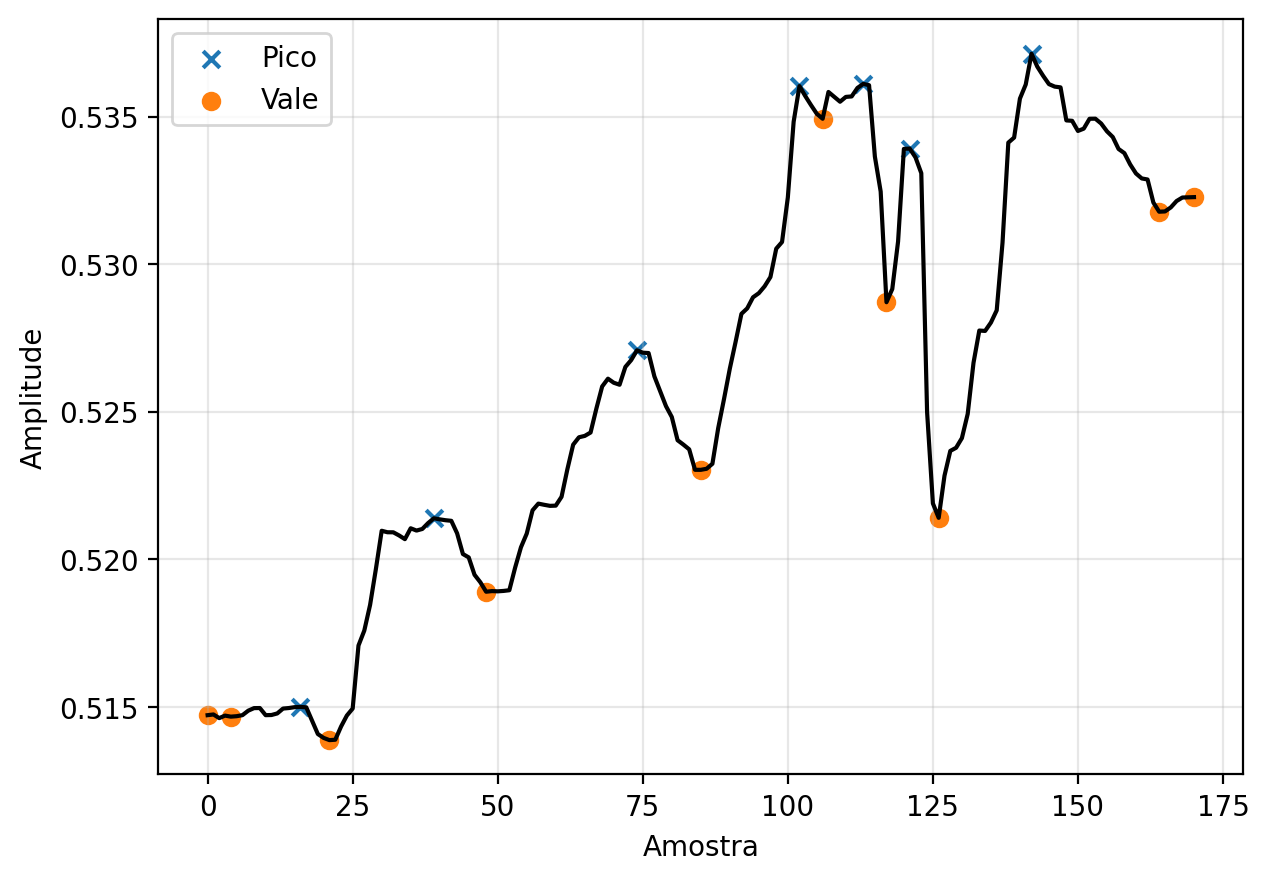

largura do passo:  0.003687739372253418
[ 6.39134645e-03  5.69081306e-03  8.94981623e-03  7.43269920e-05
 -2.19082832e-03  3.21096182e-03]
[-5.00082970e-05 -7.95364380e-04  5.02705574e-03  4.12917137e-03
  1.18927956e-02 -6.21557236e-03 -7.30431080e-03  1.03704333e-02
  4.94360924e-04]
n° de passos:  6
velocidade:  0.0038818309181614923
velocidade em passos:  1.0526315789473684
foot off:  -10.526315789473683


In [24]:
from findpeaks import findpeaks
fp = findpeaks(method='peakdetect', lookahead=5)

def plot_pv(results):
    #retorna os picos e vales apenas
    peak   = results['df'][results['df']['peak'] == True]
    valley = results['df'][results['df']['valley'] == True]

    #Mostra o gráfico
    plt.figure(dpi=200, figsize=(7,5))
    plt.grid(alpha=0.3)
    plt.plot(results['df']['x'], results['df']['y'], color='k')
    plt.scatter(peak['x'], peak['y'], label='Pico', marker='x')
    plt.scatter(valley['x'], valley['y'], label='Vale', marker='o')
    plt.xlabel('Amostra')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

    return peak, valley

results1 = fp.fit(foot29_x)
peak, valley = plot_pv(results1)

dist_peaks  = np.diff(peak['y'])
dist_valley = np.diff(valley['y'])

step_lenght = abs(np.average(dist_peaks))

print("largura do passo: ", step_lenght)
print(dist_peaks)
print(dist_valley)

n_passos = len(peak)-1
velocidade_m = (n_passos * step_lenght)/tx[-1]
velocidade_p = (n_passos)/tx[-1]
print("n° de passos: ", n_passos)
print("velocidade: ", velocidade_m)
print("velocidade em passos: ", velocidade_p)
picos = peak.y
amostra = peak.x
#step_lenght = (picos[-1] - picos[0])/len(picos)

def countX(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count 

foot29r = np.round(foot29_x-0.0005, 3)
nfoot_on = 0

for pico in picos:
    nfoot_on += countX(foot29r, round(pico-0.0005, 3))
    nfoot_on += countX(foot29r, round(pico-0.0006, 3))
    #foot_on += foot29_x
    nfoot_on += countX(foot29r, round(pico-0.0004, 3))
    #print(round(pico-0.0005, 3))
    
#print(nfoot_on)
#print(foot_on)
foot_off = ((len(foot29_x) - nfoot_on)/len(foot29_x)) *100
#print(len(foot29_x))
print("foot off: ", foot_off)

Obtenção do Centroide do Paralelogramo (Média entre as coordenadas dos vértices opostos)
(31x+30x/2,31y+30y/2)

In [25]:
centroidex = (foot31_x + foot30_x)/2
centroidey = (foot31_y + foot30_y)/2
centroide = (foot31_x + foot30_x)/2, (foot31_y + foot30_y)/2
print(centroidex)
print(centroidey)
transposta = list(map(lambda *i: [j for j in i], *centroide))
print(transposta)

#centroidex = transposta[:, 0]
#centroidey = transposta[:, 1]

[0.50215453 0.50281638 0.50462691 0.50549373 0.50624189 0.50623801
 0.50651319 0.50662877 0.50679186 0.50672321 0.50683862 0.50739308
 0.50753978 0.50790404 0.50798441 0.50818104 0.50814205 0.50828135
 0.50841865 0.50852218 0.50877438 0.5089975  0.50899781 0.50908306
 0.50961182 0.50977674 0.51036412 0.51144877 0.51293224 0.51374498
 0.51305529 0.51240729 0.51234347 0.51197314 0.512254   0.51262853
 0.51287657 0.51328954 0.51395035 0.51501676 0.51533812 0.51533398
 0.51542395 0.51523438 0.51486823 0.51469469 0.51415676 0.51408732
 0.51421836 0.51485676 0.51506099 0.51524177 0.51544976 0.51713964
 0.51751751 0.51872352 0.51949427 0.51991051 0.51946905 0.51918805
 0.51905239 0.51930058 0.51921028 0.5191783  0.51963943 0.52014199
 0.52046543 0.52021632 0.519651   0.51894727 0.5184007  0.51781702
 0.51785564 0.51789844 0.51810467 0.51806355 0.51800743 0.51802281
 0.51847202 0.51823187 0.51787934 0.51772991 0.51787063 0.5182378
 0.51807201 0.51753879 0.51784748 0.51803446 0.51834035 0.51833

Distância do CoG ao Centroide

[0.04340705 0.04465946 0.04352997 0.04284518 0.04250925 0.04374492
 0.04423691 0.04405894 0.04352537 0.04334904 0.0429211  0.04210982
 0.04133583 0.04199078 0.04166742 0.04106932 0.04008162 0.0400096
 0.04018321 0.04053958 0.04109592 0.04185718 0.04391945 0.04633841
 0.04889953 0.05039757 0.05102477 0.05021904 0.05036266 0.050091
 0.04872335 0.04770429 0.04745268 0.04553208 0.0447424  0.04471788
 0.04438475 0.04454859 0.04483441 0.04464716 0.04669668 0.05067057
 0.05342136 0.05540014 0.05652151 0.05740763 0.05767443 0.05740398
 0.05688836 0.05633661 0.05512044 0.05434842 0.05383724 0.05370949
 0.05502143 0.05593938 0.05740572 0.05841574 0.05940124 0.06160072
 0.06358359 0.06589621 0.06679916 0.06819848 0.06760408 0.0672049
 0.06636258 0.06731195 0.06711191 0.0655017  0.06457813 0.06562493
 0.06476067 0.06413236 0.06407368 0.06509405 0.06642504 0.06954993
 0.07234498 0.07461739 0.0782181  0.08033713 0.08162678 0.08029856
 0.08014129 0.08100671 0.08070057 0.08001094 0.07950757 0.08035072

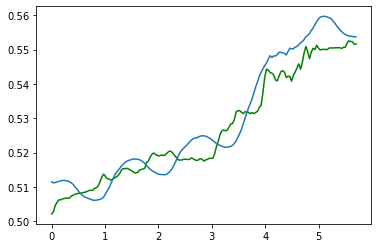

In [26]:
#Distância entre dois pontos
distancia_cog = np.sqrt((body_com_X-centroidex)**2) + ((body_com_Y-centroidey)**2)
print(distancia_cog)
print("distância média: ", np.average(distancia_cog))

for i in (distancia_cog):
    if(i != (len(distancia_cog)-1)):
        print(i, end=",")
    else: 
        print(i)

plt.plot(tx, centroidex, 'g')
plt.plot(tx, body_com_X)

Distância do CoG a borda da BoS

In [42]:
#Distância do ponto às 4 retas (usar o menor valor como distância)
from itertools import chain

norm = np.linalg.norm

# Creating points
p1 = np.array([foot31]) #ponta esquerda
p2 = np.array([foot29]) #calcanhar esquerdo
p3 = np.array([foot32]) #ponta direita
p4 = np.array([foot30]) #calcanhar direito
p5 = np.array([body_com]) #cog
'''
p1 = np.delete(foot31, 1, 1)
p2 = np.delete(foot29, 1, 1) #calcanhar esquerdo
p3 = np.delete(foot32, 1, 1) #ponta direita
p4 = np.delete(foot30, 1, 1) #calcanhar direito
p5 = np.delete(body_com, 1, 1) #cog
'''
# Finding distance of p3 from a 
# line connecting p1 and p2

dis12 = np.abs((np.cross(p2-p1, p1-p5))/norm(p2-p1))
dis13 = np.abs((np.cross(p3-p1, p1-p5))/norm(p3-p1))
dis24 = np.abs((np.cross(p2-p4, p4-p5))/norm(p2-p4))
dis34 = np.abs((np.cross(p3-p4, p4-p5))/norm(p3-p4))

#print(dis12)

#print(pp)

dis12x = dis12[:, :, 0]
dis13x = dis13[:, :, 0]
dis24x = dis24[:, :, 0]
dis34x = dis34[:, :, 0]

dis12y = dis12[:, :, 1]
dis13y = dis13[:, :, 1]
dis24y = dis24[:, :, 1]
dis34y = dis34[:, :, 1]

menor1x = np.minimum(dis12x, dis13x)
menor2x = np.minimum(dis24x, dis34x)
distanciax = np.minimum(menor1x, menor2x)
#print(distanciax)

menor1y = np.minimum(dis12y, dis13y)
menor2y = np.minimum(dis24y, dis34y)
distanciay = np.minimum(menor1y, menor2y)
#print(distanciay)

distancia_borda = np.minimum(distanciax, distanciay)
#print( distancia_borda)
distanciab_avg = np.average(distancia_borda)
distanciab_var = np.var(distancia_borda)
distanciab_desvio = np.std(distancia_borda)
print(distanciab_avg, distanciab_var, distanciab_desvio)
print("distância até a borda: ", distanciab_avg)
'''
menor1 = np.minimum(dis12, dis13)
menor2 = np.minimum(dis24, dis34)
distanciab = np.minimum(menor1, menor2)

distanciab_avg = np.average(distanciab)
distanciab_var = np.var(distanciab)
distanciab_desvio = np.std(distanciab)
print(distanciab_avg, distanciab_var, distanciab_desvio)
'''

0.0011415360063976058 1.42221185484819e-06 0.0011925652413382632
distância até a borda:  0.0011415360063976058


'\nmenor1 = np.minimum(dis12, dis13)\nmenor2 = np.minimum(dis24, dis34)\ndistanciab = np.minimum(menor1, menor2)\n\ndistanciab_avg = np.average(distanciab)\ndistanciab_var = np.var(distanciab)\ndistanciab_desvio = np.std(distanciab)\nprint(distanciab_avg, distanciab_var, distanciab_desvio)\n'

In [43]:
import math
#foot29 foot30 foot31 foot32
lado_direito = foot31_y - foot29_y
lado_esquerdo = foot32_y - foot30_y
diagonal_b = np.sqrt((foot29_x-foot30_x)**2) + ((foot29_y-foot30_y)**2)
diagonal_c = np.sqrt((foot31_x-foot32_x)**2) + ((foot31_y-foot32_y)**2)
#print(diagonal_b)
#print(diagonal_c)
centroide = [(diagonal_b+diagonal_c)/2, (lado_direito)]
h = foot29_x - foot30_x

Área da BoS

In [44]:
def calculate_area(c):

    '''
    Calculates the area of any quadrivaletral
    from a list of x,y coordinates in the following format:

    [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    '''

    first = c[0][0]*c[1][1] + c[1][0]*c[2][1] + c[2][0]*c[3][1] + c[3][0]*c[0][1]

    second = c[1][0]*c[0][1] + c[2][0]*c[1][1] + c[3][0]*c[2][1] + c[0][0]*c[3][1]

    area = 0.5*(first - second)

    return area

p1 = np.delete(foot31, 1, 1)
p2 = np.delete(foot29, 1, 1) #calcanhar esquerdo
p3 = np.delete(foot32, 1, 1) #ponta direita
p4 = np.delete(foot30, 1, 1) #calcanhar direito
c = np.concatenate((p1,p2,p3,p4), axis = 1)
area = calculate_area(c)
print(area)

-2.313649673679752e-06


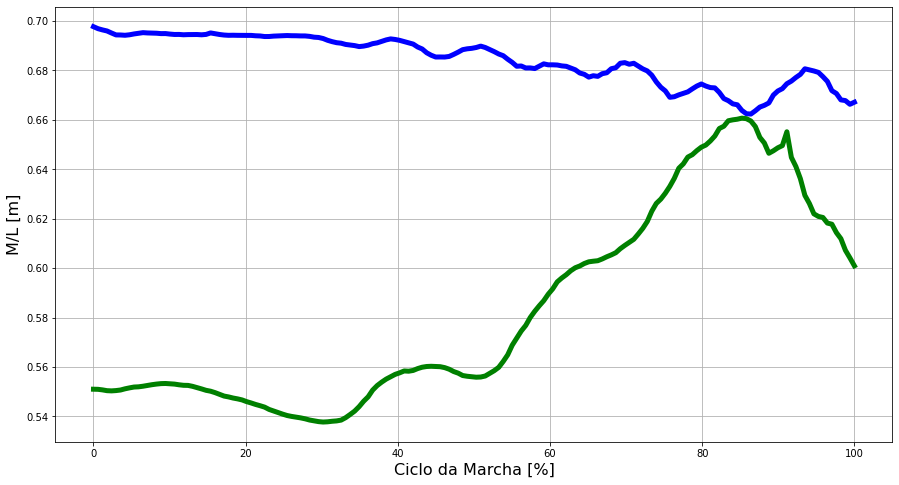

In [45]:
plt.figure(figsize=[15,8])
plt.plot(GaitCycle, body_com_Y, color = 'b', linewidth = 5)
plt.plot(GaitCycle, body_com_X, color = 'g', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(ty, foot29_y, 'go')
#plt.plot(ty, foot30_y, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

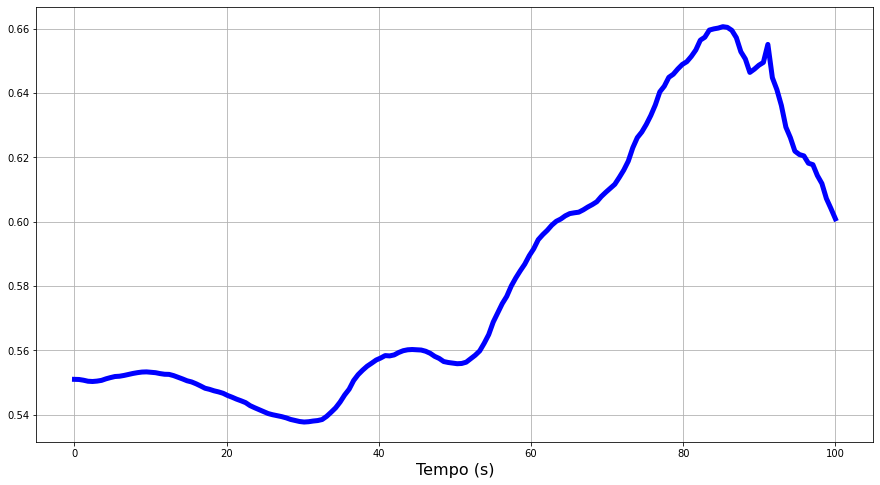

In [46]:
plt.figure(figsize=[15,8])
plt.plot(GaitCycle, body_com_X, color = 'b', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
#plt.ylabel('A/P', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(tx, foot29_x, 'go')
#plt.plot(tx, foot30_x, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

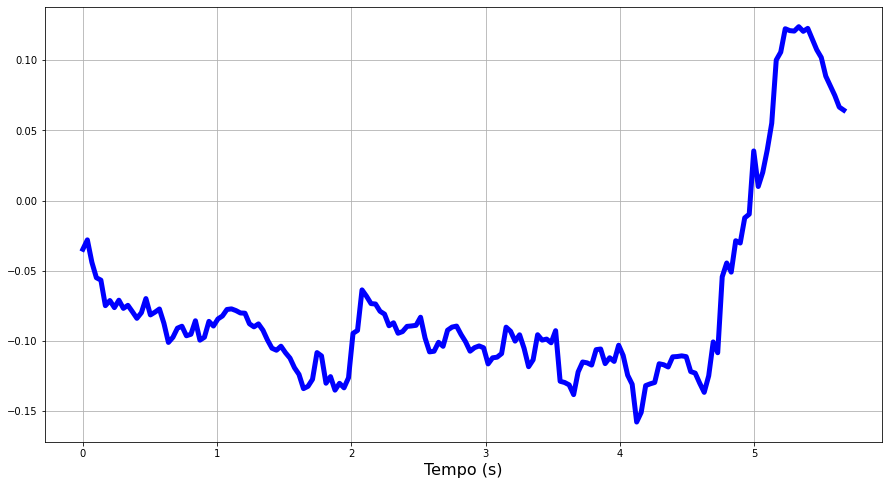

In [47]:

plt.figure(figsize=[15,8])
plt.plot(tz, body_com_Z, color = 'b', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
#plt.ylabel('A/P', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(tx, foot29_x, 'go')
#plt.plot(tx, foot30_x, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


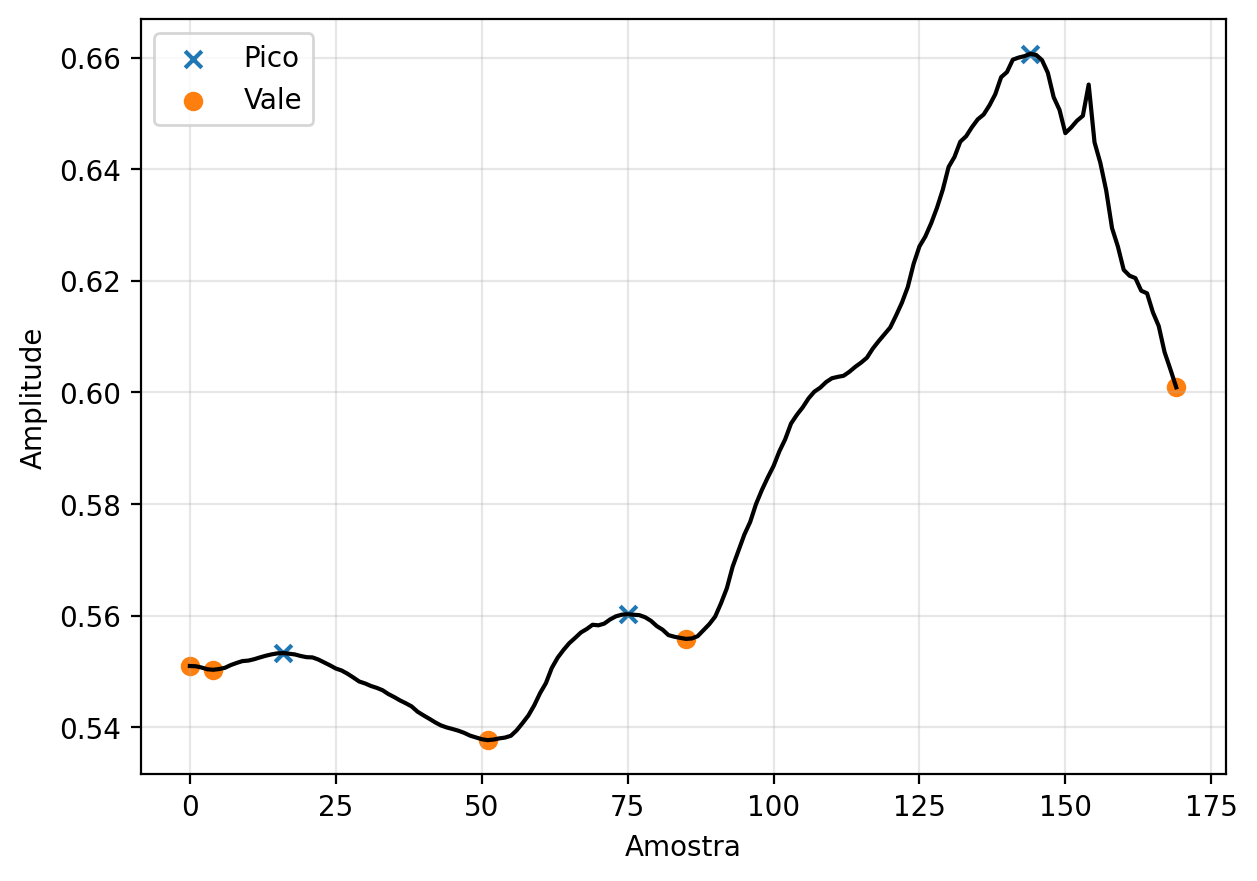

[59 69]
[ 4 47 34 84]


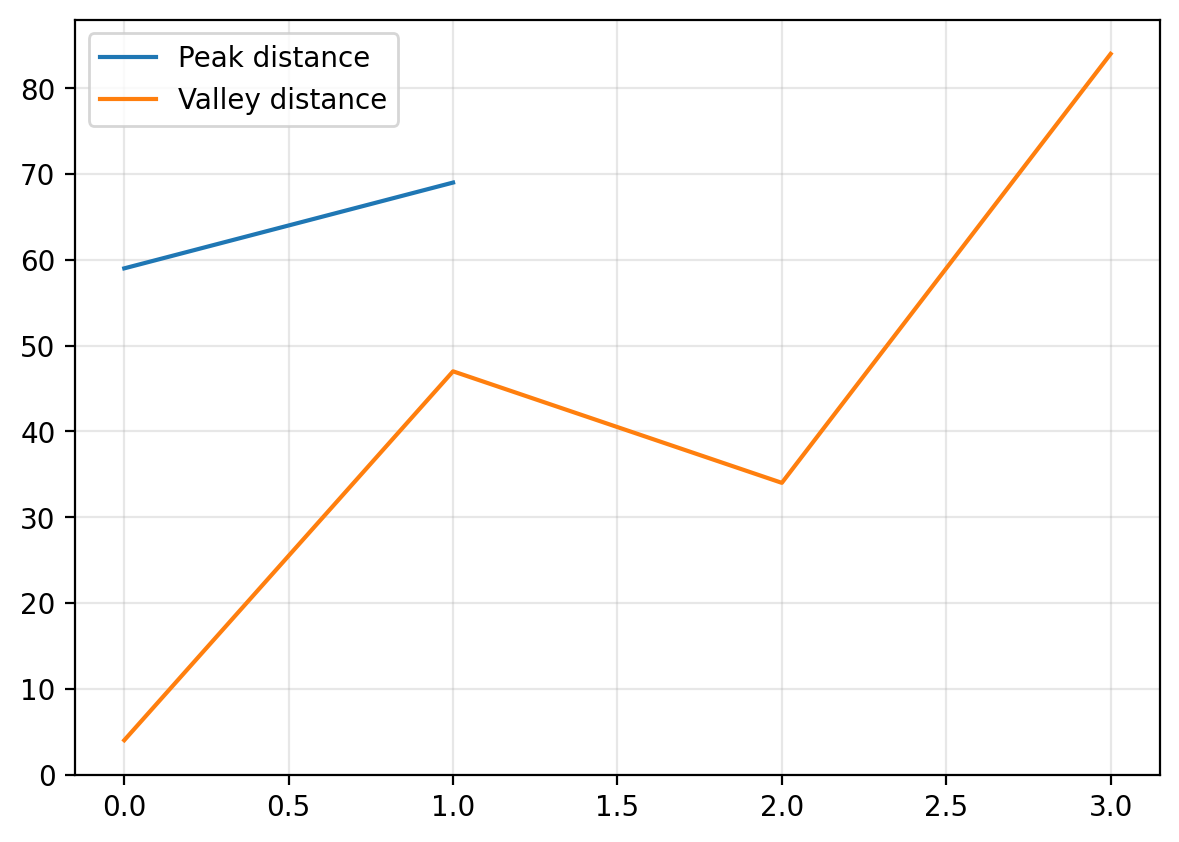

5


In [48]:


#Chama a função com os resultados obtidos anteriormente
#matriz = np.concatenate((tx, filteredx))
results = fp.fit(body_com_X)
peak, valley = plot_pv(results)

dist_peaks  = np.diff(peak['x'])
dist_valley = np.diff(valley['x'])

print(dist_peaks)
print(dist_valley)

plt.figure(dpi=200, figsize=(7,5))
plt.grid(alpha=0.3)
plt.plot(dist_peaks, label='Peak distance')
plt.plot(dist_valley, label='Valley distance')
plt.legend()
plt.show()

print(len(valley))

In [49]:
#print(2*filteredx[45]-filteredx[0])

# Filtragem

In [50]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

In [51]:
# apply a 2-pole lowpass filter at 0.15x Nyquist frequency (15 hz is half the max frequency of the video (30Hz))
bx, ax = scipy.signal.butter(2, 0.2)
filteredx = scipy.signal.filtfilt(bx, ax, body_com_X, axis=0)

by, ay = scipy.signal.butter(2, 0.2)
filteredy = scipy.signal.filtfilt(by, ay, body_com_Y, axis=0)

bz, az = scipy.signal.butter(2, 0.2)
filteredz = scipy.signal.filtfilt(bz, az, body_com_Z, axis=0)

b30z, a30z = scipy.signal.butter(2, 0.2)
filtered30z = scipy.signal.filtfilt(b30z, a30z, foot30_z, axis=0)

b29z, a29z = scipy.signal.butter(2, 0.2)
filtered29z = scipy.signal.filtfilt(b29z, a29z, foot29_z, axis=0)

b30y, a30y = scipy.signal.butter(2, 0.2)
filtered30y = scipy.signal.filtfilt(b30y, a30y, foot30_y, axis=0)

b29y, a29y = scipy.signal.butter(2, 0.2)
filtered29y = scipy.signal.filtfilt(b29y, a29y, foot29_y, axis=0)

b30x, a30x = scipy.signal.butter(2, 0.2)
filtered30x = scipy.signal.filtfilt(b30x, a30x, foot30_x, axis=0)

b29x, a29x = scipy.signal.butter(2, 0.2)
filtered29x = scipy.signal.filtfilt(b29x, a29x, foot29_x, axis=0)


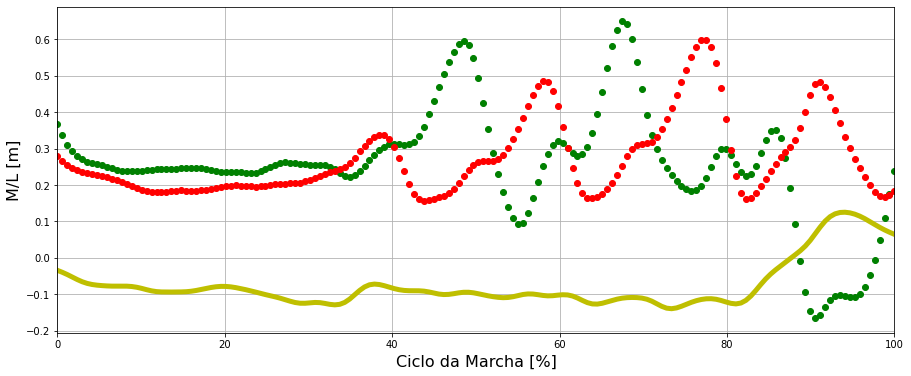

In [52]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredz, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30z, 'go')
plt.plot(GaitCycle, filtered29z, 'ro')
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.xlim(0, 100)
#plt.ylim(0.03, 0.07)
plt.grid()
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


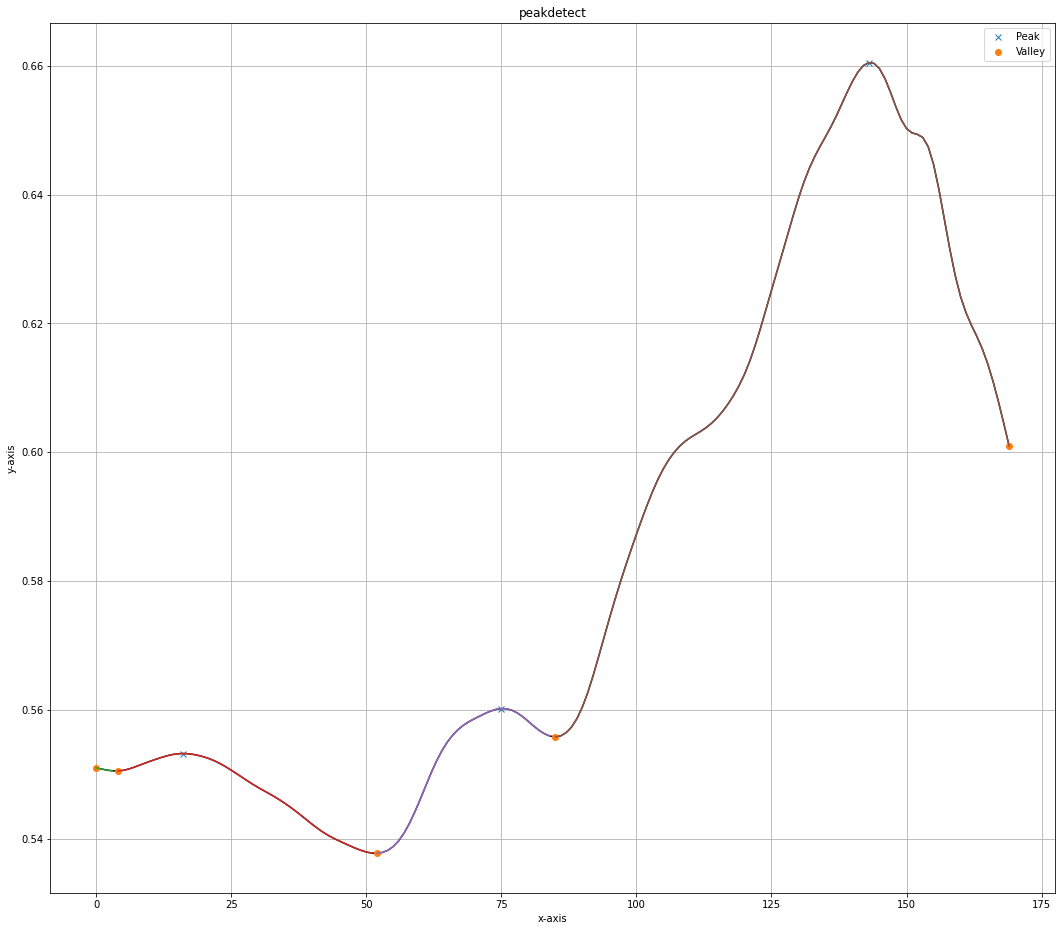

(None,
 <AxesSubplot:title={'center':'peakdetect'}, xlabel='x-axis', ylabel='y-axis'>)

In [53]:

results = fp.fit(filteredx)
fp.plot(figsize=(18,16))


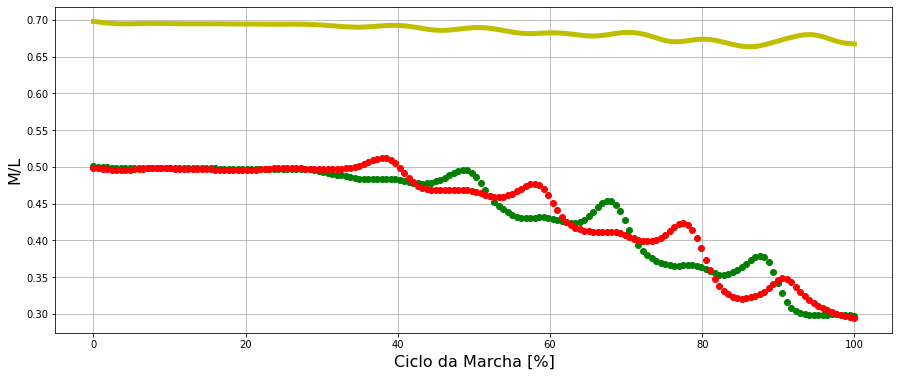

In [54]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredy, color = 'y', linewidth = 5)
plt.ylabel('M/L', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30y, 'go')
plt.plot(GaitCycle, filtered29y, 'ro')
#plt.ylim(0.6, 0.9)
#plt.title('', fontsize=16)
plt.grid()
plt.show()

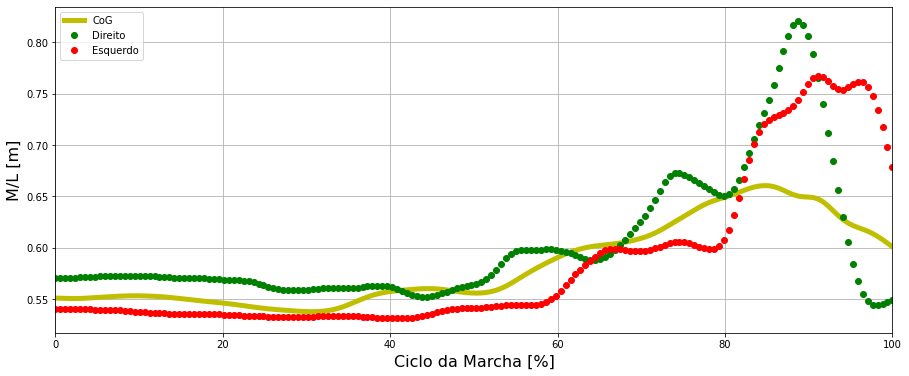

In [55]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredx, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30x, 'go')
plt.plot(GaitCycle, filtered29x, 'ro')
plt.xlim(0, 100)
plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

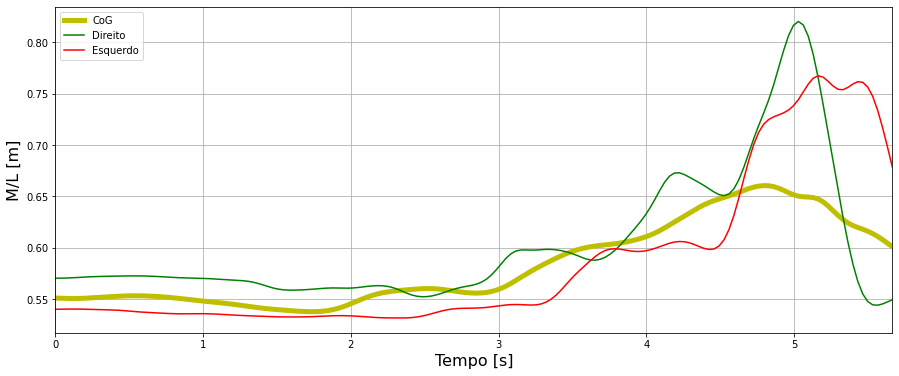

In [56]:
plt.figure(figsize=[15, 6])
plt.plot(tx, filteredx, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Tempo [s]', fontsize=16)
plt.plot(tx, filtered30x, 'g')
plt.plot(tx, filtered29x, 'r')
plt.xlim(0, tx[-1])
plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

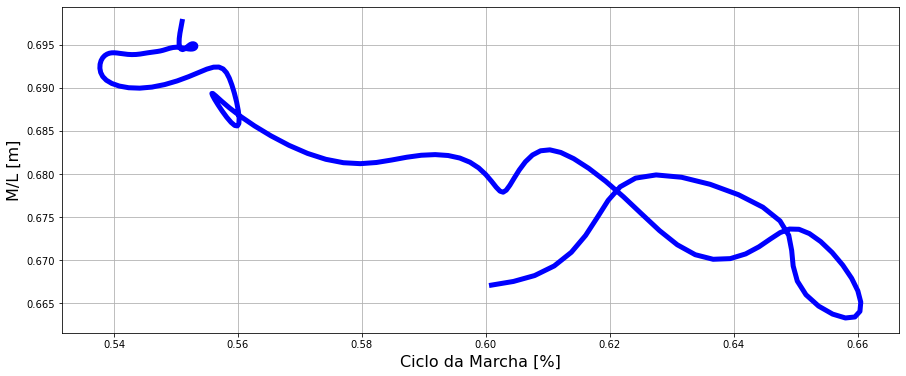

In [57]:
plt.figure(figsize=[15, 6])
#plt.plot(GaitCycle, filteredx, color = 'y', linewidth = 5)
plt.plot(filteredx, filteredy, color = 'b', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
#plt.plot(GaitCycle, filtered30x, 'go')
#plt.plot(GaitCycle, filtered29x, 'ro')
#plt.xlim(0, 100)
#plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

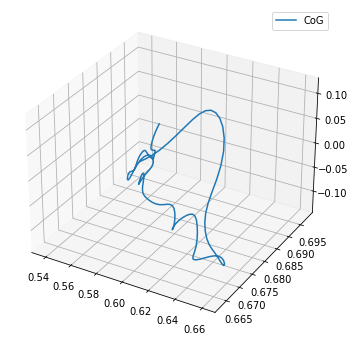

In [58]:
from mpl_toolkits.mplot3d import axes3d

ax = plt.figure(figsize=[15, 6]).add_subplot(projection='3d')

ax.plot(filteredx, filteredy, filteredz, label='CoG')
ax.legend()
plt.show()

ICC

In [33]:
d1 = [0.0514538389106871,0.05067407555523215,0.050786655776519384,0.05119854119469056,0.0512091565935511,0.0512068082263199,0.05139024660645839,0.05139091891612951,0.05147182860402087,0.05157026659754932,0.052129248145397176,0.05256850095240803,0.0528475067729817,0.05320108839536644,0.05380508095474877,0.05470797890008554,0.05534280727870653,0.05646912596959021,0.05710806899222877,0.05724891583477182,0.057870039554836585,0.05884511541396876,0.059516174584004565,0.060406345262364096,0.06078911358130997,0.060511301690721775,0.06051745881145319,0.06039500202629919,0.06017106845288897,0.05987657628473731,0.05893463217062185,0.057473962362409134,0.05665879643930896,0.05513627170330665,0.0500992848888252,0.04705704790875273,0.045875147915162034,0.044264766296892896,0.04276663353346177,0.04746627140691842,0.050981679893848726,0.05326399572637771,0.05624711232899608,0.05848399763889048,0.062105049474083636,0.06440879929859017,0.0644573549401099,0.05942404630806641,0.05762112130104745,0.05705269106433453,0.0574173907133797,0.056909736788318545,0.05606641937342522,0.05495405644258136,0.05258771399779398,0.05106228603723584,0.05098863144536144,0.050193193992828636,0.05060918507821834,0.05249805538663417,0.05716290888776622,0.06135010556348676,0.06320357589991607,0.0641440342429828,0.06775134850767615,0.07050361604967013,0.07568810653844366,0.07527359003101508,0.07102676067301583,0.0661155212972754,0.06375709110000824,0.06723056118009532,0.0706477756769121,0.07151099541673119,0.07311802462299118,0.07520057705442562,0.07273613370337143,0.07503528343734783,0.07706344558368053,0.07748880123518634,0.07817916617458072,0.07654723467364945,0.0752520332677328,0.07572719167088532,0.07519262028550686,0.07763825471259951,0.07961300369434354,0.07944023493515993,0.08058810918142915,0.08275258417495122,0.08467165933945593,0.08937704338162596,0.09706983969951406,0.10564442211211773,0.11547774668467238,0.121359626499424,0.12289464434221384,0.12138277040016462,0.12015970844434247,0.10448449526612037,0.10145596615825314,0.10295531029795646,0.10565452781420963,0.11619173119962604,0.10063594347477002,0.13115324795768998,0.14786624188431785,0.15165784900294735,0.1562006489445797,0.16399800933482858,0.1739436452453521,0.17729620274966826,0.18636961184860523,0.1884585214519291,0.19142616978442045,0.19098419663430355,0.18868295220800774,0.19297135209778654,0.18892205166572001,0.17780240062936808,0.16552179276587015,0.15875943103865398,0.15403017650828194,0.1521348803330284,0.15280513454533623,0.1513508453275237,0.14728372727513678,0.1443727004548917,0.1437235205966062,0.1432687069533755,0.1426998789866415,0.14159115574168546,0.13966241818904804,0.13889206824157757,0.13830788422705667,0.1372760393409114,0.1368858517206464,0.13490072678288448,0.13548449171648103,0.13503958202112465]

d2 = [0.044985027122347726,0.04490980897875556,0.04518652738650285,0.04538843942709318,0.045781510347313634,0.04585346513870181,0.04606616088736775,0.04552939257024828,0.04528768317632452,0.04511307752228244,0.04513976022849911,0.045009180712584224,0.044672802924393594,0.04449135701942339,0.04431509702923474,0.044082966252045185,0.0440849485544268,0.04425600156263805,0.04441494336708453,0.04477472781167476,0.04500555757998118,0.044820870275837914,0.045017178782620015,0.045409135725371814,0.0457909698197476,0.046044129153306114,0.0465261529145067,0.04711329461207663,0.04856927891449457,0.04968773854660907,0.049810853494798864,0.050160441551938204,0.05046686201176584,0.05071389190906226,0.05108318990071145,0.0514863900049067,0.051938696868865854,0.052337904711246636,0.052564350692091984,0.05329218226177436,0.05364241935592215,0.05339559060212022,0.05243066056047882,0.051698111264919855,0.051093966651097236,0.051209862985044416,0.051334786180803296,0.051706829071027645,0.05233846530767074,0.05271978853396929,0.053367570413269845,0.053367149392221404,0.05318017190571188,0.053468913937393274,0.05366719224857892,0.05378577121897088,0.052657075041759774,0.051384976974946615,0.04932908934804046,0.04776486414226605,0.04489594125039925,0.0435641052040041,0.04578216079115294,0.047657453441935296,0.04926044767423288,0.05116031175517018,0.05272796897988713,0.0560471570984123,0.05794355983169423,0.060057687671282625,0.06337247835148273,0.06528853131962153,0.06665057375827307,0.06555632927593598,0.061094457577541825,0.05911484171947219,0.05918748763427064,0.058679905564938586,0.05785179209207427,0.05614773697130386,0.05453312570627415,0.05242832716684361,0.05025589708108342,0.05049436138134647,0.05072745639624674,0.05198681465409205,0.05477512029817892,0.05726257063685623,0.05962480682705583,0.06123876876881942,0.0638027213165192,0.06588953726926519,0.06724942416246188,0.06573542509350798,0.06325519333839742,0.06737181005544884,0.07028909446221099,0.07211283973885682,0.07392529308607854,0.0753281376798503,0.0782523128900665,0.08249228863000797,0.08533105323779533,0.08595353119751474,0.08588887818807711,0.0870346682586097,0.08522473081649415,0.08303078298544614,0.08230316054297313,0.08011715463608388,0.07803176985208768,0.0753218697070325,0.07279453898122105,0.07026139582404009,0.06809517487352541,0.0705029391112614,0.07547891590834953,0.07964005862848256,0.08856313925446316,0.09534415674796769,0.10056105383333958,0.10418033923510667,0.10846576330290963,0.11454310076128822,0.11509092194843959,0.1128796374835533,0.1061200083115756,0.10127585636785558,0.09213938774994287,0.0888714227363242,0.09447997958971172,0.09479865851634874,0.1039561402686871,0.10878359001905306,0.11686176170774253,0.12727131970190142,0.13150588038371402,0.12158766622305704,0.1175821148974249,0.11912028234953213,0.12723376531282093,0.14334958257187033,0.14183348482559183,0.13268481873110302,0.13754453583145992,0.1438229275990391,0.15707773066518543,0.17320040620588803,0.17656812159552487,0.18438117457907932,0.19396143751734463,0.19802790531220837,0.2111042729487991,0.19975171840733635,0.18526204436744412,0.1791168520198318,0.15774147172297426,0.15851258847568397,0.1391572055056586,0.14291395048738106,0.1379110334545941,0.1466266831364337,0.14796503714487808,0.1460290884629667,0.13899539362805546,0.13538186031191177,0.13245168156621276,0.13665706408631687,0.14055761455692606,0.14201786898931712]

#d1 = [0.05218259866604461,0.05368955124138886,0.05313051939242357,0.05253105901501655,0.05139098916667298,0.050619822818092165,0.049821775600185456,0.04931356958235381,0.048864434531410726,0.048357861812582954,0.04825083195533678,0.04801078769005478,0.047622563261777245,0.047476256368749234,0.04749553370223807,0.04735465856266716,0.046779123289166696,0.04627477450875975,0.04601202107013559,0.04595867966995277,0.04597861130826121,0.046186240806465634,0.046765895683588625,0.04742022567553291,0.04776581846551662,0.04812567957004858,0.048445451011609734,0.048632232437996886,0.048632415849277896,0.048370543363686784,0.047447175763713066,0.04645522554786003,0.04561354170425726,0.04473951953070761,0.04352379575474023,0.04151318495877897,0.04006112734308726,0.04230173072987184,0.043786601935704564,0.04566254660446091,0.04694761530846551,0.048175998728973164,0.048794401722427806,0.04877641805514049,0.048214745614745466,0.04833849588277308,0.047539638173081725,0.046308190881016946,0.0461349461839632,0.046386319723316,0.04618904357138857,0.04598920481022516,0.045647600018715984,0.0457310161896429,0.04574177214099339,0.045151838720848866,0.043787838365728485,0.041453570789128355,0.03995903317047313,0.043098294752457966,0.044601129880983297,0.043749525981128294,0.044068340159362555,0.04577724166748883,0.04807132204294093,0.05034532551620054,0.054827839317300266,0.058801548955097,0.06170388543731432,0.06420045391503876,0.06390721755824136,0.06457819280027718,0.06233531198644723,0.061210822378340066,0.059367090854080186,0.0591693338737732,0.058576653782739976,0.05719190696329696,0.055428265625834486,0.05252698208958661,0.050014804834977986,0.04682431689401782,0.05286141559275533,0.058169424270798596,0.062468302485068704,0.06662707232304052,0.07052838561882718,0.07191375650429083,0.07431345454055978,0.07497569967687528,0.07609436571876492,0.07771114797320891,0.07636786744793098,0.07218158464803584,0.0671278772644875,0.06425273562424776,0.05952702143583554,0.056160359622296485,0.0510331774915925,0.051631427798207515,0.052994511014147865,0.05711039366277629,0.061570848070330184,0.06481132869729911,0.07108598901192777,0.07625421884683627,0.08221166640475361,0.08393650690026914,0.08492040308636581,0.08544551038539237,0.08227739892486993,0.07902470072748774,0.07492415596556758,0.07197220691100188,0.06911387297724508,0.07452093820546957,0.07609903435438846,0.0802142717590355,0.08220954314758909,0.08551743795759618,0.0894675704547369,0.09220823057692852,0.09533266437576332,0.0998770740560047,0.098217671228583,0.09798295110616041,0.10033259470027217,0.10150616620573277,0.10126934801135595,0.09929141719600017,0.09624918241033496,0.089976248586689,0.08108381161379159,0.0791362626230103,0.08078185882445145,0.0828134227653337,0.08585168790283447,0.08877735740536966,0.09392964848174588,0.10152749547899653,0.1073518912014129,0.11134014024559435,0.11936686083007347,0.12102618687428413,0.12452941837005968,0.12530675070183755,0.1231210388996493,0.12100321153448294,0.11693311119670412,0.11215673308466036,0.11384715935741911,0.11273391575783338,0.11707601372731888,0.12068873037864337,0.1287803358033806,0.13777049706057273,0.13883162925254167,0.13484815529521255,0.12670261475924344,0.12190355451702924,0.12415985817591242,0.1267167088861216,0.1306704077688538,0.13189231154138825,0.13236518703837136,0.13139968814544817,0.13092216458225692,0.1318331287582455,0.12955492635363802,0.13025094648487356,0.12444221512985112,0.12305947676644677,0.1214654583692876,0.11631575041362564,0.11307915496276405,0.11430294590833898,0.11121820836291495,0.10801628470169791,0.1117066827809963,0.114719978462394,0.11657884105878097,0.11856606205660934,0.11755711986564552,0.11637170123606037,0.11660309190747771,0.12840137979636146,0.12835667345585877,0.13017167424456882,0.12623561106383846,0.12597344178989753,0.12334946915507801,0.12250936461691969,0.1235519185699398,0.124092156910526,0.12430525136342443,0.12250878710710167]

#d2 = [0.04340704576529795,0.04465945545799271,0.0435299658672152,0.04284518243065186,0.04250924741096838,0.04374492427470717,0.04423690769558536,0.04405894357573614,0.04352536696408003,0.04334904328878029,0.042921095687417074,0.04210982487438147,0.0413358286370782,0.04199078237409511,0.04166742359902962,0.041069321994715115,0.04008161893802771,0.0400095990002495,0.04018320538119942,0.0405395783230877,0.04109591548445063,0.04185718209504027,0.04391944559892374,0.04633840907993502,0.04889952636982991,0.05039756730727721,0.0510247685697364,0.05021904314556925,0.050362663275970825,0.05009099777822265,0.04872335293368538,0.04770428986387356,0.047452678289763024,0.04553207898074179,0.0447424036676573,0.044717877298399225,0.044384748297204804,0.04454859009844061,0.04483440546300702,0.044647158552402894,0.046696680833596745,0.05067056715967338,0.05342136196249481,0.05540013700783553,0.056521508124769804,0.05740763357871994,0.05767443228786414,0.05740398390471298,0.05688836197920729,0.05633661051953083,0.055120435874827574,0.054348422978512174,0.053837235707431826,0.05370949393215093,0.05502143212780144,0.0559393777929309,0.05740571805569172,0.058415741622357555,0.05940124008519516,0.06160072354926803,0.06358358965734451,0.06589621420732684,0.06679915865506764,0.06819848005986026,0.06760408273166152,0.06720489513752931,0.06636257776165078,0.06731195230483135,0.06711191334395107,0.0655017042933181,0.06457813014134267,0.06562492656935837,0.06476067498498565,0.06413235907042894,0.06407368265586472,0.06509405074151862,0.06642504056590054,0.06954993093634454,0.0723449768638487,0.07461739189240092,0.07821809891495077,0.08033713471329527,0.08162677982275143,0.0802985616806791,0.08014129280593467,0.08100670719730982,0.08070057379375677,0.08001094422469633,0.07950756846747269,0.08035071868614396,0.08154291972374429,0.08097035994034191,0.07646072332503877,0.07478043741623575,0.07723296454366099,0.07932492095604103,0.08218260300667946,0.08587768996242927,0.0903649630383333,0.09392109121453683,0.0961847801794498,0.09453043895324505,0.09441089417951821,0.09477528606235998,0.0944316988778881,0.09523647504048764,0.09465636521254975,0.09343837647875523,0.09222757325631972,0.09066761555167926,0.08910868957494998,0.089599912529303,0.08997815736325934,0.09394496212361415,0.0957571730839426,0.10207868459645905,0.10731288622499367,0.11186007573025232,0.11125889943086373,0.10920311258610448,0.10837495486186402,0.10876582341010603,0.11187943355387947,0.11276820986100275,0.11483373293623618,0.11589887456545603,0.11810377809812572,0.11989853665477605,0.11936426627819252,0.11872222237277148,0.11752559560345513,0.11592515126729143,0.11632068124717779,0.11775469054222981,0.11966625777632944,0.12084337647127696,0.12111890858042038,0.12077072938814877,0.1197488756681467,0.11931560219304382,0.11639632264698095,0.11372824854826803,0.11237287005801166,0.11389011067743628,0.11585783116004664,0.11463623195526519,0.11246823187081752,0.1137692990923682,0.11189419200528528,0.11332544938134773,0.11545207403975224,0.11825357375921255,0.11813406403402646,0.11853535679374014,0.11840177391881707,0.11760715786781853,0.11698830312056342,0.11609862342505706,0.11548436732651537,0.11476314983534153,0.11394676160872509,0.11352128621005032,0.11255351106592901,0.11138640362493674,0.11131906537092764,0.10902549819005641,0.10777634416356806,0.10819029795474341,0.10807116211793352,0.10868858670207288,0.10840167963195517]

In [34]:
freq_amostragem = 30 # frames por segundo

td = np.linspace(0, len(d1) / freq_amostragem, len(d1))

In [35]:
tam1 = np.size(d1)
tam2 = np.size(d2)
#tam3 = np.size(filtered3)
#print(np.concatenate((t1, t2, t3), axis=None))
#print(np.ones(tam1)*2)
nteste = np.concatenate(((np.ones(tam1), (np.ones(tam2)*2))))
ndeslocamento = np.concatenate((d1, d2), axis=None)
ntempo = np.concatenate((td, td), axis=None)
nj = np.ones(np.size(nteste))
mm = np.concatenate((list(range(tam1)), list(range(tam2))), axis=None)

print(np.size(nteste))
print(np.size(ndeslocamento))
print(np.size(mm))
print(np.size(ntempo))
#print(mm)

310
310
310
280


In [36]:
import pandas as pd
df = pd.DataFrame({'teste': mm, 'video': nteste, 'deslocamento': ndeslocamento, 'tempo': nteste})
df.head()

,teste,video,deslocamento,tempo
0,0,1.0,0.051454,1.0
1,1,1.0,0.050674,1.0
2,2,1.0,0.050787,1.0
3,3,1.0,0.051199,1.0
4,4,1.0,0.051209,1.0


In [37]:
import pingouin as pg

icc = pg.intraclass_corr(data=df, targets='teste', raters='video', ratings='tempo', nan_policy='omit')

icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,-1.0,0.0,139,140,1.0,"[-1.0, -1.0]"
ICC2,Single random raters,0.0,NaN,139,139,NaN,"[nan, nan]"
ICC3,Single fixed raters,NaN,NaN,139,139,NaN,"[nan, nan]"
ICC1k,Average raters absolute,-inf,0.0,139,140,1.0,"[-inf, -inf]"
ICC2k,Average random raters,0.0,NaN,139,139,NaN,"[nan, nan]"
ICC3k,Average fixed raters,NaN,NaN,139,139,NaN,"[nan, nan]"


In [38]:
icc = pg.intraclass_corr(data=df, targets='teste', raters='video', ratings='deslocamento', nan_policy='omit')

icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.453170,2.657447,139,140,7.741667e-09,"[0.31, 0.58]"
ICC2,Single random raters,0.509515,4.583001,139,139,4.959412e-18,"[0.09, 0.73]"
ICC3,Single fixed raters,0.641770,4.583001,139,139,4.959412e-18,"[0.53, 0.73]"
ICC1k,Average raters absolute,0.623699,2.657447,139,140,7.741667e-09,"[0.47, 0.73]"
ICC2k,Average random raters,0.675071,4.583001,139,139,4.959412e-18,"[0.16, 0.84]"
ICC3k,Average fixed raters,0.781802,4.583001,139,139,4.959412e-18,"[0.7, 0.84]"
